## Goals of Script

1. Automate the process of writing notes in a natural language format of each tract in a BLM Oil and Gas Lease Sale

2.  Creaete visualizaitons tract by tract of permitting, new production, and leasing activity within a given radius

3.  Create a predictive model to estimate the purchase price based on historical activity, production, permits, and commodity prices

### Pending Tasks

* Add functionality to create concatenated dataframes for lease tracts with multiple polygons - This will create separate filters for each polygons individual centroid and compile the data as 1 dataframe for visualization and analysis

* Separate large file into sub notebooks for handling cleaning, filtering, note creation, modeling, etc

* fix bug in note generation where leases with high variabliity in bonus price skews the summary (remove outliars)


In [1]:
import pandas as pd
import geopandas as gp
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import shapely
import math
import datetime as dt
import pdb

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
#had to add GDAL_DATA variable to system variables and set value to the folder of gdal in C:\Users\mishaun\AppData\Local\Continuum\anaconda3\Library\share\gdal on my work computer
'GDAL_DATA' in os.environ

False

In [ ]:
%run GlobalFuncts_n_Vars.py

***
# Machine Learning and Price Projections Section
***

## Data Preparation

### Gathering Oil and Gas Prices

In [2]:
#get historical oil price data
oilPrices = pd.read_excel("Data/oilPrices.xls", sheet_name="Data 1", header=2)

oilPrices.columns

Index(['Date', 'Cushing, OK WTI Spot Price FOB (Dollars per Barrel)'], dtype='object')

In [3]:
#renaming price column to something more concise 
oilPrices.rename(columns = {'Cushing, OK WTI Spot Price FOB (Dollars per Barrel)' : "WTI Price"} , inplace = True)


In [4]:
#appending data to the data frame for missing months manually - setting march 2020 price to $25/bbl
oilPrices = oilPrices.append({'Date': pd.to_datetime('2020-03-15', format='%Y-%m-%d', errors='ignore'), 'WTI Price': 25}, ignore_index = True)

#Setting the index of the dataframe as the date and then filtering to data within last 10 years
oilPrices.set_index("Date", inplace = True)
oilPrices = oilPrices.loc[oilPrices.index.year > 1999] 

In [5]:
#confirming data appended is present
oilPrices[oilPrices.index.year == 2020]

#view summary of oil prices throughout the years
oilPrices.groupby(oilPrices.index.year).describe()

WTI Price
Date                 
2020-01-15      57.52
2020-02-15      50.54
2020-03-15      25.00

WTI Price                                                           \
         count       mean        std    min      25%      50%       75%   
Date                                                                      
2000      12.0  30.300833   2.668215  25.72  28.7025   29.770   32.1425   
2001      12.0  25.947500   3.568282  19.39  25.1925   27.310   27.8575   
2002      12.0  26.115000   3.174783  19.72  25.2725   26.660   28.5025   
2003      12.0  31.120833   2.317446  28.11  29.8325   30.935   32.3350   
2004      12.0  41.443333   5.867064  34.31  36.7475   40.530   45.1600   
2005      12.0  56.492500   6.260930  46.84  52.1925   57.335   60.1225   
2006      12.0  66.018333   5.476898  58.89  61.8775   64.645   70.8675   
2007      12.0  72.318333  13.217301  54.51  62.7050   69.925   81.3900   
2008      12.0  99.571667  29.067578  41.12  88.8800  104.780  118.8525   
2009      12.0  61.654167  13.795144  39.09  49.2225   66.780   71.9050   
2010      12.0  79.395000   4.722221  73.74  76.0750   77.465   82.4800   
2011      12.0  94.874167   7.671223  85.52  88.0175   96.710   99.1450   
2012      12.0  94.110833   7.566593  82.30  87.8900   94.320  100.7525   
2013      12.0  97.905833   5.278863  92.02  94.3475   95.540  101.5725   
2014      12.0  93.258333  13.768110  59.29  91.0075   98.670  102.0975   
2015      12.0  48.688333   6.755165  37.19  44.8275   47.520   51.7875   
2016      12.0  43.144167   6.837864  30.32  39.9500   44.950   47.2225   
2017      12.0  50.884167   3.813093  45.18  48.3700   50.440   52.7425   
2018      12.0  64.938333   6.458830  49.52  62.6050   67.060   70.0425   
2019      12.0  56.984167   3.394762  51.38  54.7725   56.990   58.5825   
2020       3.0  44.353333  17.119981  25.00  37.7700   50.540   54.0300   

              
         max  
Date          
2000   34.42  
2001   29.61  
2002   29.66  
2003   35.83  
2004   53.28  
2005   65.59  
2006   74.41  
2007   94.77  
2008  133.88  
2009   77.99  
2010   89.15  
2011  109.53  
2012  106.16  
2013  106.57  
2014  105.79  
2015   59.82  
2016   51.97  
2017   57.88  
2018   70.98  
2019   63.86  
2020   57.52

WTI Price
Date                 
2000-01-15      27.26
2000-02-15      29.37
2000-03-15      29.84
2000-04-15      25.72
2000-05-15      28.79

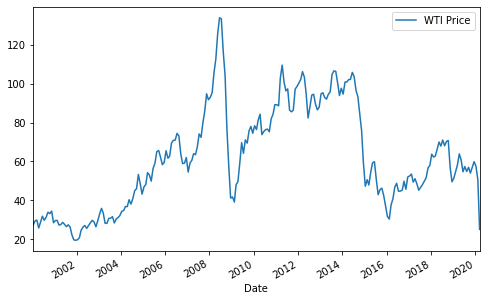

In [6]:
oilPrices.head()

oilPrices.plot(figsize=(8,5))

In [7]:
#get historical gas price data
gasPrices = pd.read_excel("Data/gasPrices.xls", sheet_name="Data 1", header=2)

gasPrices.set_index('Date', inplace = True)
gasPrices.rename(columns = {'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)': 'Gas Price'}, inplace = True)
gasPrices = gasPrices.loc[gasPrices.index.year > 1999] 


gasPrices.groupby(gasPrices.index.year).describe()

Gas Price                                                         
         count      mean       std   min     25%    50%      75%    max
Date                                                                   
2000      12.0  4.309167  1.769753  2.42  2.9775  4.140   5.0300   8.90
2001      12.0  3.956667  1.812790  2.19  2.4300  3.415   5.2000   8.17
2002      12.0  3.366667  0.707856  2.32  3.0200  3.345   3.6725   4.74
2003      12.0  5.485833  0.894310  4.47  4.9000  5.345   5.8475   7.71
2004      12.0  5.900000  0.476521  5.15  5.4050  6.035   6.2850   6.58
2005      12.0  8.811667  2.704981  6.14  6.8375  7.405  10.6625  13.42
2006      12.0  6.745000  0.966423  4.90  6.2000  6.810   7.2225   8.69
2007      12.0  6.976667  0.621806  6.08  6.4675  7.105   7.4125   8.00
2008      12.0  8.861667  2.102349  5.82  7.4375  8.400  10.4075  12.69
2009      12.0  3.948333  0.749471  2.99  3.4700  3.815   4.1375   5.35
2010      12.0  4.386667  0.675861  3.43  3.9950  4.270   4.6725   5.83
2011      12.0  4.000000  0.460810  3.17  3.8175  4.075   4.3375   4.54
2012      12.0  2.752500  0.484489  1.95  2.4525  2.755   3.0425   3.54
2013      12.0  3.728333  0.303160  3.33  3.5725  3.660   3.8825   4.24
2014      12.0  4.391667  0.670384  3.48  3.9175  4.350   4.6725   6.00
2015      12.0  2.630000  0.334229  1.93  2.5425  2.775   2.8425   2.99
2016      12.0  2.515000  0.559667  1.73  1.9725  2.570   2.8600   3.59
2017      12.0  2.985833  0.139835  2.82  2.8800  2.980   3.0325   3.30
2018      12.0  3.166667  0.529843  2.67  2.8000  2.965   3.4275   4.09
2019      12.0  2.565833  0.276256  2.22  2.3600  2.600   2.6600   3.11
2020       3.0  1.906667  0.115036  1.79  1.8500  1.910   1.9650   2.02

## Read and Clean Data for Training Data

Data read in consists of ALL historical leases, leases, and horizontal production within training boundaries set by an AOI shapefile/trace on drillinginfo

In [8]:
AOI = gp.read_file("zip://Data/Training Data/AOI.zip")

In [9]:
#read in csv into pandas first and then convert it into a geopandas dataframe and set crs and geometry column
trainLeasesPandasDF = pd.read_csv("Data/Training Data/LeaseTraining.CSV")
trainLeases = gp.GeoDataFrame(trainLeasesPandasDF, crs = {'init': 'epsg:4326'}, geometry=gp.points_from_xy(trainLeasesPandasDF["Longitude (WGS84)"], trainLeasesPandasDF["Latitude (WGS84)"]))

trainPermits = gp.read_file("zip://Data/Training Data/PermitsTraining.zip")
trainProd = gp.read_file("zip://Data/Training Data/ProdTraining.zip")

In [10]:
trainLeases.info()
trainPermits.info()
trainProd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4289 entries, 0 to 4288
Data columns (total 42 columns):
State/Province                        4289 non-null object
Effective Date                        2063 non-null object
Record Date                           4289 non-null object
Expiration of Primary Term            4288 non-null object
Term (Months)                         4203 non-null float64
Grantor                               4289 non-null object
Grantee Alias                         4266 non-null object
Royalty                               2082 non-null float64
Bonus                                 877 non-null float64
Area (Acres)                          4069 non-null float64
Section                               4289 non-null float64
Township                              4289 non-null float64
Township Direction                    4289 non-null object
Range                                 4289 non-null float64
Range Direction                       4289 non-null o

In [11]:
trainLeases.columns


Index(['State/Province', 'Effective Date', 'Record Date',
       'Expiration of Primary Term', 'Term (Months)', 'Grantor',
       'Grantee Alias', 'Royalty', 'Bonus', 'Area (Acres)', 'Section',
       'Township', 'Township Direction', 'Range', 'Range Direction',
       'Vol/Page', 'Record Number', 'Instrument Type', 'Instrument Date',
       'County/Parish', 'Options/Extensions', 'DI Basin', 'Ext. Bonus',
       'Ext. Term (Months)', 'Abstract', 'Block', 'BLM', 'State Lease',
       'Grantee', 'Grantor Address', 'Grantee Address', 'Max Depth',
       'Majority Legal Assignee', 'DI Subplay', 'Min Depth',
       'Majority Assignment Effective Date', 'Latitude (WGS84)', 'DI Play',
       'Majority Legal Assignee Interest', 'Longitude (WGS84)',
       'Majority Assignment Vol/Page', 'geometry'],
      dtype='object')

In [12]:
#Only keeping pertinent columns for train leases
#dropping leases with no bonus information - bonus will be our response feature
trainLeases = trainLeases.loc[:,["Record Date", "Record Number", "Bonus", "Section", "Township", "Range", "geometry"]]
trainLeases.dropna(axis=0, subset = ["Bonus"], inplace = True)


In [13]:
trainPermits.columns

Index(['API10UWI', 'WGID', 'PermitNo', 'Country', 'OFS_Reg', 'State', 'County',
       'DIBasin', 'DIPlay', 'DISubplay', 'District', 'OpAlias', 'OpCompany',
       'OpReported', 'OpTicker', 'LeaseName', 'WellNo', 'LeaseNo', 'Field',
       'Formation', 'PermitType', 'WellType', 'DrillType', 'PermDepth',
       'PermDUOM', 'TVD', 'TVD_UOM', 'PermStatus', 'WellStatus', 'FiledDate',
       'AprvdDate', 'AmendDate', 'CntctName', 'CntctPhone', 'OperAddrs',
       'OperCity', 'OperState', 'OperZip', 'OperCity30', 'OperCity50',
       'Section', 'Township', 'Range', 'Block', 'Survey', 'Abstract',
       'H2S_Area', 'Latitude', 'Longitude', 'Btm_Lat', 'Btm_Lon', 'ExpDate',
       'geometry'],
      dtype='object')

In [14]:
trainPermits.drop(columns=['Country', 'OFS_Reg', 'State', 'County',
       'DIBasin', 'DIPlay', 'DISubplay', 'District', 'OpAlias', 'OpCompany',"DISubplay",'AmendDate', 'CntctName', 'CntctPhone', 'OperAddrs',
       'OperCity', 'OperState', 'OperZip', 'OperCity30', 'OperCity50', 'H2S_Area'], inplace = True)

In [15]:
pd.options.display.max_columns = None
trainProd.info()



<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7471 entries, 0 to 7470
Columns: 111 entries, APIUWI to geometry
dtypes: float64(66), geometry(1), int64(2), object(42)
memory usage: 6.3+ MB


In [16]:
trainProd.drop(columns = ['EntityType','OCS_Area', 'PGC_Area','EntityId', 'OpTicker', 'OpReported', 'OpCompany',
                          'OtherNo','DIBasin', 'DIPlay','DISubplay','CumWtr','CumMMCFGE','CumBCFGE', 
                          'PrcIPCFGED','PracIP_BOE','LastTestDt','LastFlwPrs','LastWHSIP','2moGOR','LatestGOR',
                          'CumGOR','Lst12Yield','2moYield','LatestYld','PeakGas','PkGasMoNo','PeakLiq','PkLiqMoNo',
                          'PeakBOE','PkBOEMoNo','PkMMCFGE','PkMMCFGMoN','TopPerf','BtmPerf','GasGrav',
                          'OilGrav','CompDate','Field','Country','State','District','GeoProvin'], inplace = True)

In [17]:
#finding any columns containing water information and dropping them
watercols = list(filter(lambda x: "wtr" in x.lower() or "water" in x.lower(), trainProd.columns))

In [18]:
trainProd.drop(columns = watercols, inplace=True)


trainProd.columns

Index(['APIUWI', 'OpAlias', 'LeaseName', 'WellNo', 'County', 'Reservoir',
       'ProdType', 'ProdStatus', 'DrillType', 'LeaseNo', 'FstPrdDate',
       'LstPrdDate', 'CumGas', 'CumLiq', 'CumBOE', 'DailyGas', 'DailyLiq',
       '1moLiq', '1moGas', '6moLiq', '6moGas', '6moBOE', '12moLiq', '12moGas',
       '12moBOE', '12MMCFGE', '24moLiq', '24moGas', '24moBOE', '24moMMCFGE',
       '60moLiq', '60moGas', '60moBOE', '60moMMCFGE', 'PracIP_Liq',
       'PracIP_Gas', 'LatestLiq', 'LatestGas', 'Prior12Liq', 'Prior12Gas',
       'WellCount', 'MaxActvWel', 'MoProd', 'GasGather', 'LiqGather',
       'SpudDate', 'TD', 'TVD', 'PerfLength', 'Section', 'Township', 'Range',
       'Abstract', 'Block', 'Survey', 'Latitude', 'Longitude', 'Last12Liq',
       'Last12Gas', 'geometry'],
      dtype='object')

In [19]:
# from GlobalFunctions import convertoDateTime
# from GlobalFunctions import convertCRS
%run GlobalFuncts_n_Vars.py

<Figure size 432x288 with 0 Axes>

In [20]:
#dropping production where there are null values for first prod date
trainProd.dropna(subset=['FstPrdDate'], inplace=True)

#convert date columns to date time for date filtering 
convertoDateTime(trainProd, trainLeases,trainPermits)

#convert CRS for each dataframe
convertCRS(AOI, trainProd, trainLeases, trainPermits)

{'init': 'epsg:4326'}
Converted to:
{'init': 'epsg:26913', 'no_defs': True}


{'init': 'epsg:4326'}
Converted to:
{'init': 'epsg:26913', 'no_defs': True}


{'init': 'epsg:4326'}
Converted to:
{'init': 'epsg:26913', 'no_defs': True}


{'init': 'epsg:4326'}
Converted to:
{'init': 'epsg:26913', 'no_defs': True}




In [21]:
trainLeases.info()
trainPermits.info()
trainProd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 877 entries, 57 to 4288
Data columns (total 7 columns):
Record Date      877 non-null datetime64[ns]
Record Number    877 non-null object
Bonus            877 non-null float64
Section          877 non-null float64
Township         877 non-null float64
Range            877 non-null float64
geometry         877 non-null geometry
dtypes: datetime64[ns](1), float64(4), geometry(1), object(1)
memory usage: 54.8+ KB
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2799 entries, 0 to 2798
Data columns (total 33 columns):
API10UWI      2799 non-null object
WGID          2799 non-null object
PermitNo      2799 non-null object
OpReported    2799 non-null object
OpTicker      1479 non-null object
LeaseName     2799 non-null object
WellNo        2799 non-null object
LeaseNo       2462 non-null object
Field         2799 non-null object
Formation     2799 non-null object
PermitType    2799 non-null object
WellType      2799 non-null 

## Testing Out Data gathering and modeling on sample tract

 import training data for certain AOI
 permit data will include all permits for new wells in the AOI
 prod data will include wells within last 8 years
 training will be don by looking at a lease sold with a bonus price, then determine how many permits, production, etc there was for that particular lease during the time of the sale
 therefore, we will to filter down the dataset for a buffer around that lease
 then using custom measures,  oil price, bbls per month per well, number of permits by type, permits by type * avg prod in area, etc = lease bonus


### Initializing Learning Columns

In [23]:
#creating buffer column with 3 mi radius for each lease datapoint in training Leases data
trainLeases["buffers"] = trainLeases.buffer(milesbuffer)

In [24]:
#creating list of columns for learning variables on particular lease
learningCols = ["Total Permits", "Total Wells", "Avg First 6 Mo Oil", "Avg First 6 Mo Gas", "Qi Oil", "Qi Gas", "6 Mo Oil Revenue $", "6 Mo Gas Rev $", "Oil Price", "Gas Price" ]

In [25]:
#initializing null values to colums containing varialbes to learn
for col in learningCols:
    trainLeases[col] = np.nan

In [26]:
#creating a list for response and predictor features in order to easily call exploratory plots 
MLPredandResponseCols = []
MLPredandResponseCols.append("Bonus")
for col in learningCols:
    MLPredandResponseCols.append(col)
MLPredandResponseCols

['Bonus',
 'Total Permits',
 'Total Wells',
 'Avg First 6 Mo Oil',
 'Avg First 6 Mo Gas',
 'Qi Oil',
 'Qi Gas',
 '6 Mo Oil Revenue $',
 '6 Mo Gas Rev $',
 'Oil Price',
 'Gas Price']

## Test Code for getting training measures

In [27]:
#testing
leaseDf = trainLeases[trainLeases["Record Number"] == 'WYW182806']
leaseDf = leaseDf.iloc[0]

#pulling date from lease for evaluations to create filter on permit and prod datasets
filterDate = leaseDf["Record Date"]
filterDate

#filtering production dataframe to within buffer of lease for evaluation & only wells taht had started producing before the date lease was recorded
prodFilter = trainProd.loc[trainProd.within(leaseDf["buffers"])]
prodFilter = trainProd.loc[trainProd["FstPrdDate"] <= filterDate]

#filtering production dataframe to within buffer of lease for evaluation & only wells taht had started producing before the date lease was recorded
permFilter = trainPermits.loc[trainPermits.within(leaseDf["buffers"])]

#creating a filter to only show active permits within time lease was purchased
permFilter = trainPermits.loc[(trainPermits["ExpDate"]>=filterDate) & (trainPermits["AprvdDate"]<=filterDate)]



Timestamp('2014-02-11 00:00:00')

In [28]:
#saving learning variable: total number of active permits
totalActivePermits = len(permFilter)

totalActivePermits

233

In [29]:
#finding month in oil and gas price dataframes based on record date of lease
#formatting data to find by month and year only
searchMonthYr = "{}-{}".format(filterDate.month, filterDate.year)

#saving gas and oil price from the time of the record date of the lease
oilPriceYr = oilPrices.loc[searchMonthYr]["WTI Price"].iloc[0]
gasPriceYr = gasPrices.loc[searchMonthYr]["Gas Price"].iloc[0]

oilPriceYr, gasPriceYr

(100.82, 6.0)

In [30]:


#getting variables to learn on from production dataframe
totalWells = len(prodFilter)
Avg6MoOilProd = prodFilter["6moLiq"].mean()
Avg6MoGasProd = prodFilter["6moGas"].mean()

#multiplying Initial production daily rates for the given month by 30 to get it into a Qi monthly rate
IPoil = prodFilter["PracIP_Liq"].mean() * 30
IPgas = prodFilter["PracIP_Gas"].mean() * 30

totalWells, Avg6MoOilProd,Avg6MoGasProd, IPoil, IPgas

(412,
 17446.01265822785,
 23989.017721518987,
 4731.334951456311,
 6415.339805825243)

In [31]:
learningCols

#making a list of all the learning variables saved
learningVals = [totalActivePermits, totalWells, Avg6MoOilProd,Avg6MoGasProd, IPoil, IPgas, oilPriceYr, gasPriceYr]

#converting all learning variables to integers to drop float decimals
learningVals = list(map(int, learningVals))

#zipping learning value with the column name it belongs to as a tuple pair
learningPairs = list(zip(learningCols, learningVals))


['Total Permits',
 'Total Wells',
 'Avg First 6 Mo Oil',
 'Avg First 6 Mo Gas',
 'Qi Oil',
 'Qi Gas',
 '6 Mo Oil Revenue $',
 '6 Mo Gas Rev $',
 'Oil Price',
 'Gas Price']

In [32]:
trainLeases[trainLeases["Record Number"] == 'WYW182806'].index
trainLeases.loc[trainLeases.index == 2420]
 
#appending learning value to its corresponding dataframe column for the given lease
for pair in learningPairs:
    trainLeases.loc[trainLeases.index == 2420, pair[0]] = pair[1]
    
trainLeases.loc[trainLeases.index == 2420]

Int64Index([2420, 2421], dtype='int64')

Record Date Record Number   Bonus  Section  Township  Range  \
2420  2014-02-11     WYW182806  3900.0     10.0      39.0   72.0   

                            geometry  \
2420  POINT (460251.600 4801972.654)   

                                                buffers  Total Permits  \
2420  POLYGON ((465079.620 4801972.654, 465056.372 4...            NaN   

      Total Wells  Avg First 6 Mo Oil  Avg First 6 Mo Gas  Qi Oil  Qi Gas  \
2420          NaN                 NaN                 NaN     NaN     NaN   

      6 Mo Oil Revenue $  6 Mo Gas Rev $  Oil Price  Gas Price  
2420                 NaN             NaN        NaN        NaN

Record Date Record Number   Bonus  Section  Township  Range  \
2420  2014-02-11     WYW182806  3900.0     10.0      39.0   72.0   

                            geometry  \
2420  POINT (460251.600 4801972.654)   

                                                buffers  Total Permits  \
2420  POLYGON ((465079.620 4801972.654, 465056.372 4...          233.0   

      Total Wells  Avg First 6 Mo Oil  Avg First 6 Mo Gas  Qi Oil  Qi Gas  \
2420        412.0             17446.0             23989.0  4731.0  6415.0   

      6 Mo Oil Revenue $  6 Mo Gas Rev $  Oil Price  Gas Price  
2420               100.0             6.0        NaN        NaN

## Function for gathering training measures on learning cols based on test code above

In [33]:
learningCols

['Total Permits',
 'Total Wells',
 'Avg First 6 Mo Oil',
 'Avg First 6 Mo Gas',
 'Qi Oil',
 'Qi Gas',
 '6 Mo Oil Revenue $',
 '6 Mo Gas Rev $',
 'Oil Price',
 'Gas Price']

In [34]:
def getTrainingMeasures(LeasesForEval, leaseIndex, trainProd, trainPermits):
    
    '''
    This function will take in 3 dataframes
    1. LeasesForEval will be the cleaned dataframe that holds lease information with bonus prices
    2. trainProd is the cleaned dataframe that holds production necessary for evaluating leases
    3. trainPermits is the cleaned dataframe that holds permits necessary for evaluating leases
    
    The function will take in an index from the LeasesForEval to perform the following actions:
        - The fuction will filter and retrieve permit and production data within a 3 mile radius from the lease point
        - It will also find the oil/gas price for the month the lease was recorded
        - Filters will be applied to the found permit and production data in order to get a snapshot of the data that existed during the time of purchasing the lease
        - Measures such as average First 6 month oil production and total number of wells will be stored in columns as the inputs (x vars) for the ML model
    '''
    
    #Getting single lease from data 
    leaseDf = LeasesForEval.loc[LeasesForEval.index == leaseIndex]
    leaseDf = leaseDf.iloc[0]
    
    
    #pulling date from lease for evaluations to create filter on permit and prod datasets
    filterDate = leaseDf["Record Date"]

    #filtering production dataframe to within buffer of lease for evaluation & only wells taht had started producing before the date lease was recorded
    prodFilter = trainProd.loc[trainProd.within(leaseDf["buffers"])]
    prodFilter = prodFilter.loc[prodFilter["FstPrdDate"] <= filterDate]

    #filtering permit dataframe to within buffer of lease for evaluation & only permits that were active time of the lease
    permFilter = trainPermits.loc[trainPermits.within(leaseDf["buffers"])]

    #creating a filter to only show active permits within time lease was purchased
    permFilter = permFilter.loc[(permFilter["ExpDate"]>=filterDate) & (permFilter["AprvdDate"]<=filterDate)]

    #saving learning variable: total number of active permits
    totalActivePermits = len(permFilter)
    
    #finding month in oil and gas price dataframes based on record date of lease
    #formatting data to find by month and year only
    searchMonthYr = "{}-{}".format(filterDate.month, filterDate.year)

    #saving gas and oil price from the time of the record date of the lease
    oilPriceYr = oilPrices.loc[searchMonthYr]["WTI Price"].iloc[0]
    gasPriceYr = gasPrices.loc[searchMonthYr]["Gas Price"].iloc[0]
    
    #getting variables to learn on from production dataframe
    totalWells = len(prodFilter)
    Avg6MoOilProd = prodFilter["6moLiq"].mean()
    Avg6MoGasProd = prodFilter["6moGas"].mean()

    #multiplying Initial production daily rates for the given month by 30 to get it into a Qi monthly rate
    IPoil = prodFilter["PracIP_Liq"].mean() * 30
    IPgas = prodFilter["PracIP_Gas"].mean() * 30
    
    First6MoOilRev = Avg6MoOilProd*oilPriceYr
    First6MoGasRev = Avg6MoGasProd*gasPriceYr
    
    #making a list of all the learning variables saved
    learningVals = [totalActivePermits, totalWells, Avg6MoOilProd,Avg6MoGasProd, IPoil, IPgas, First6MoOilRev, First6MoGasRev, oilPriceYr, gasPriceYr]


    #zipping learning value with the column name it belongs to as a tuple pair
    learningPairs = list(zip(learningCols, learningVals))
    
    #appending learning value to its corresponding dataframe column for the given lease
    for pair in learningPairs:
        LeasesForEval.loc[LeasesForEval.index == leaseIndex, pair[0]] = pair[1]
    
    #storing state of filter in order to review for quality assurance - will append to list when function is called in loop
    permFilter["LeaseIndex"] = leaseIndex
    prodFilter["LeaseIndex"] = leaseIndex
    
    return permFilter, prodFilter
    

### Running function to get training measures on all leases from Lease Training Data

In [35]:
trainPermFilters = []
trainProdFilters = []
for index in trainLeases.index:
    FilteredTrainingPerm, FilteredTrainingProd = getTrainingMeasures(trainLeases, index, trainProd, trainPermits)
    
    trainPermFilters.append(FilteredTrainingPerm)
    trainProdFilters.append(FilteredTrainingProd)

### Exporting Training Measures to File

In [36]:
#saving file with learning features values into an excel file
trainLeases.to_excel("Output Data/Training Leases Activity Data/TrainLeases - Learning Features.xlsx")

#saving filtered permits around training leases for quality assurance and validation
pd.concat(trainPermFilters).to_excel('Output Data/Training Leases Activity Data/Full Permit Data On Training Leases.xlsx')

#saving filtered prod around training leases for quality assurance and validation
pd.concat(trainProdFilters).to_excel('Output Data/Training Leases Activity Data/Full Prod Data On Training Leases.xlsx')

# Exploratory Data on Features and Target

### Reading In DataFrame with Training Mesures

In [37]:
#importing Trainleases with training measure from export/output folder to prevent re-running script
trainLeases = pd.read_excel("Output Data/Training Leases Activity Data/TrainLeases - Learning Features.xlsx")

#creating columns wiht combined township and range in order to groupby each TWR on a single row
trainLeases["TWSHP"] = trainLeases["Township"].apply(lambda x: str(x)) + " " + trainLeases["Range"].apply(lambda y: str(y))

#Adding record year as a column to use it as a metric to see how the data stacks up by year
trainLeases["Record Year"] = trainLeases["Record Date"].apply(lambda x: x.year)

In [38]:
trainLeases.head()
trainLeases.rename(columns={'Unnamed: 0': "LeaseIndex"}, inplace = True)
trainLeases.set_index("LeaseIndex", inplace = True)

Unnamed: 0 Record Date Record Number  Bonus  Section  Township  Range  \
0          57  2019-12-11     WYW189586   1527        3        39     73   
1          58  2019-12-11     WYW189586   1527        9        39     73   
2          59  2019-12-11     WYW189590    302       27        39     73   
3          60  2019-12-11     WYW189596   1535       32        40     73   
4          61  2019-12-11     WYW189593    752       28        40     73   

                                      geometry  \
0  POINT (450547.6131938574 4803344.147960225)   
1  POINT (448886.0374564391 4801760.549607107)   
2    POINT (450464.34694615 4796947.371161564)   
3  POINT (447329.5662888384 4804957.255790628)   
4   POINT (448968.4909649936 4806538.52595432)   

                                             buffers  Total Permits  \
0  POLYGON ((455375.6331938574 4803344.147960225,...              9   
1  POLYGON ((453714.0574564391 4801760.549607107,...             14   
2  POLYGON ((455292.36694615 4796947.371161564, 4...             10   
3  POLYGON ((452157.5862888384 4804957.255790628,...              6   
4  POLYGON ((453796.5109649936 4806538.52595432, ...              6   

   Total Wells  Avg First 6 Mo Oil  Avg First 6 Mo Gas       Qi Oil  \
0           49        15299.416667        46031.020833  3210.612245   
1           57        14679.767857        38966.214286  3319.473684   
2           38        17782.297297        49281.540541  3801.315789   
3           43         8980.725000        33128.175000  2092.325581   
4           26         7941.240000        20281.240000  1899.230769   

         Qi Gas  6 Mo Oil Revenue $  6 Mo Gas Rev $  Oil Price  Gas Price  \
0   9631.836735        9.161291e+05   102188.866250      59.88       2.22   
1   8427.894737        8.790245e+05    86504.995714      59.88       2.22   
2  10975.263158        1.064804e+06   109405.020000      59.88       2.22   
3   6826.046512        5.377658e+05    73544.548500      59.88       2.22   
4   4250.769231        4.755215e+05    45024.352800      59.88       2.22   

   TWSHP  Record Year  
0  39 73         2019  
1  39 73         2019  
2  39 73         2019  
3  40 73         2019  
4  40 73         2019

### Reading in Filtered Training Prod and Permits for Each Lease
 * will use to cross check and validate data accuracy if needed

In [39]:
#reading in filtered Training Production and Permit Data

DFtrainProdFilter = pd.read_excel('Output Data/Training Leases Activity Data/Full Prod Data On Training Leases.xlsx')
DFtrainPermFilter= pd.read_excel('Output Data/Training Leases Activity Data/Full Permit Data On Training Leases.xlsx')

DFtrainPermFilter.drop(DFtrainPermFilter.columns[0],axis = 1,  inplace = True)
DFtrainProdFilter.drop(DFtrainProdFilter.columns[0], axis = 1, inplace = True)

DFtrainPermFilter.set_index("LeaseIndex", inplace = True)
DFtrainProdFilter.set_index("LeaseIndex", inplace = True)


### Pair Plots on Response vs All Predictor Features

<Figure size 1008x648 with 0 Axes>

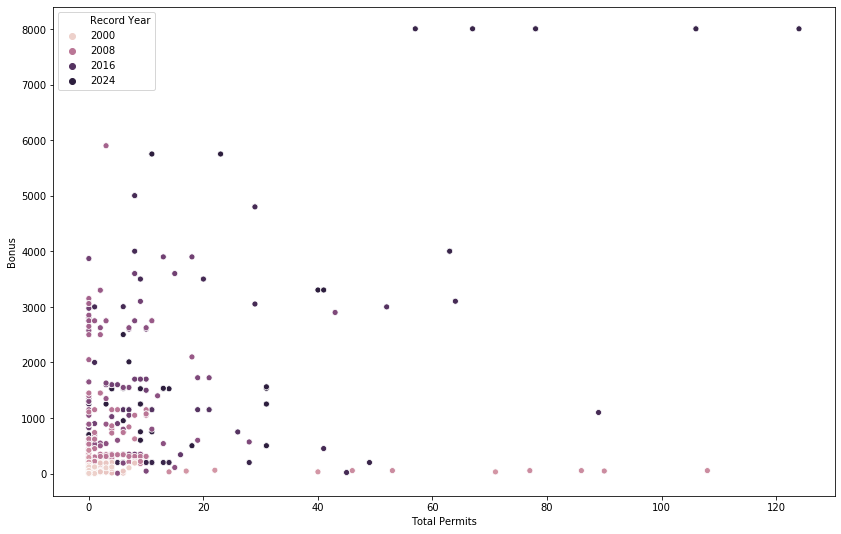

<Figure size 1008x648 with 0 Axes>

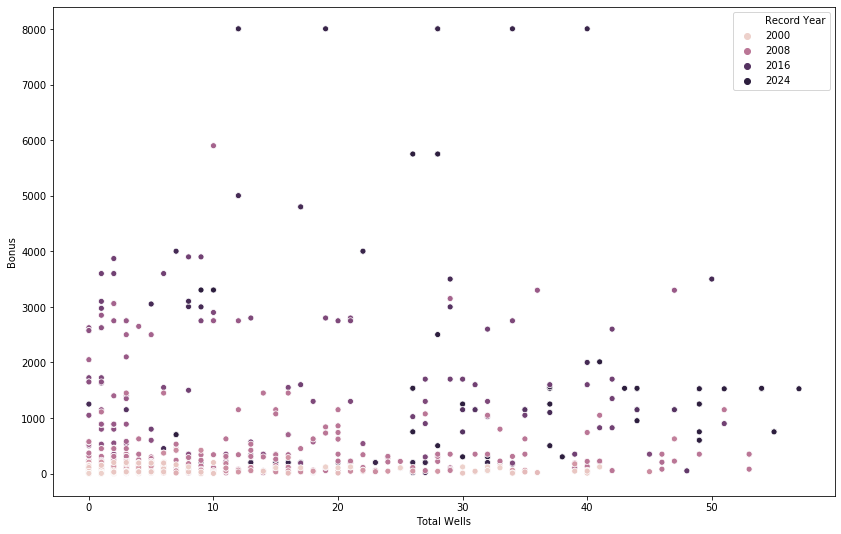

<Figure size 1008x648 with 0 Axes>

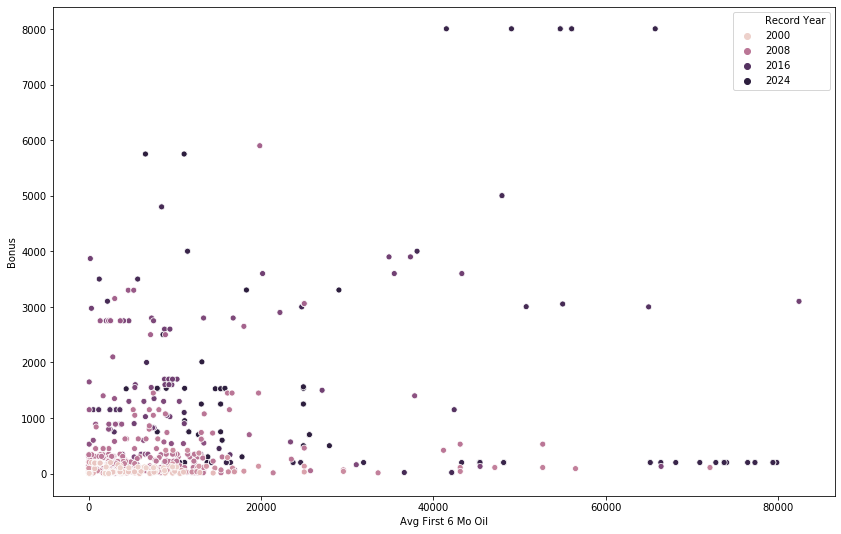

<Figure size 1008x648 with 0 Axes>

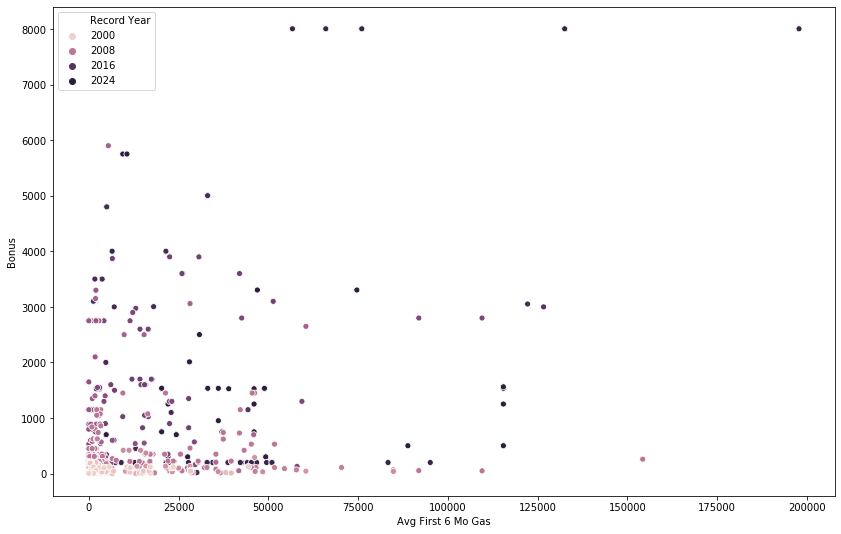

<Figure size 1008x648 with 0 Axes>

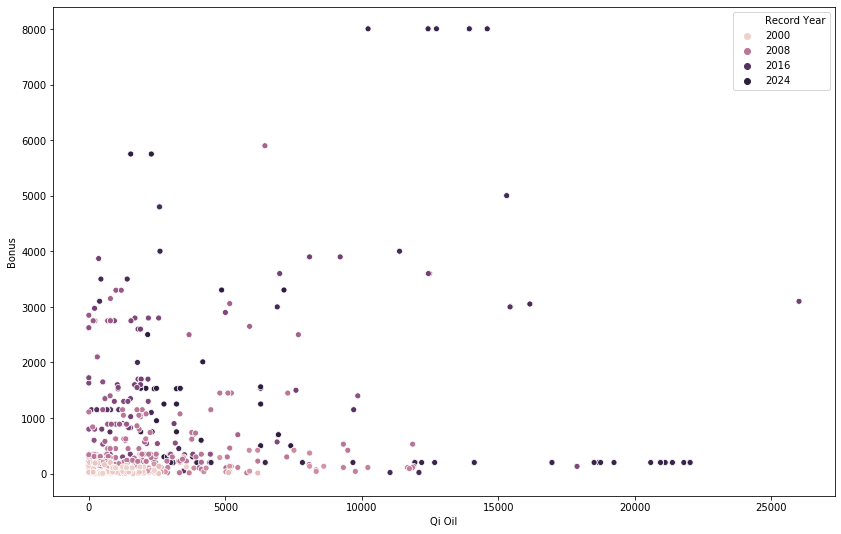

<Figure size 1008x648 with 0 Axes>

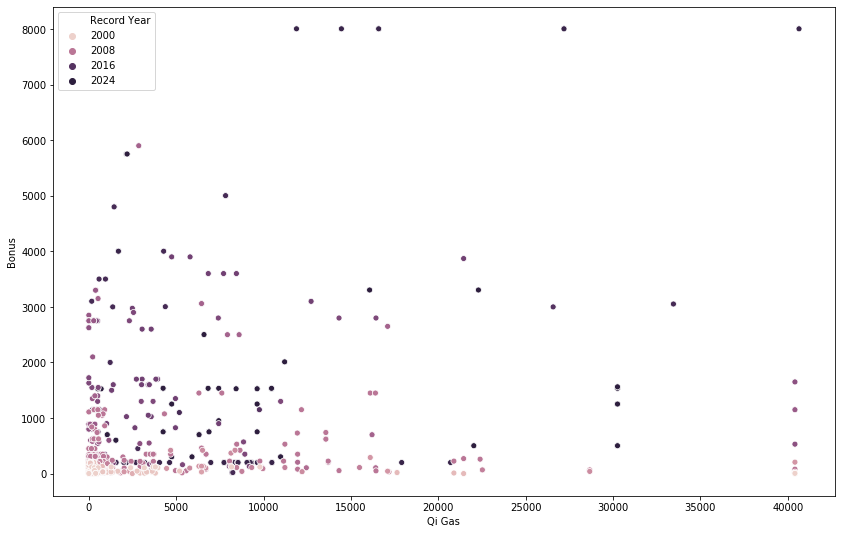

<Figure size 1008x648 with 0 Axes>

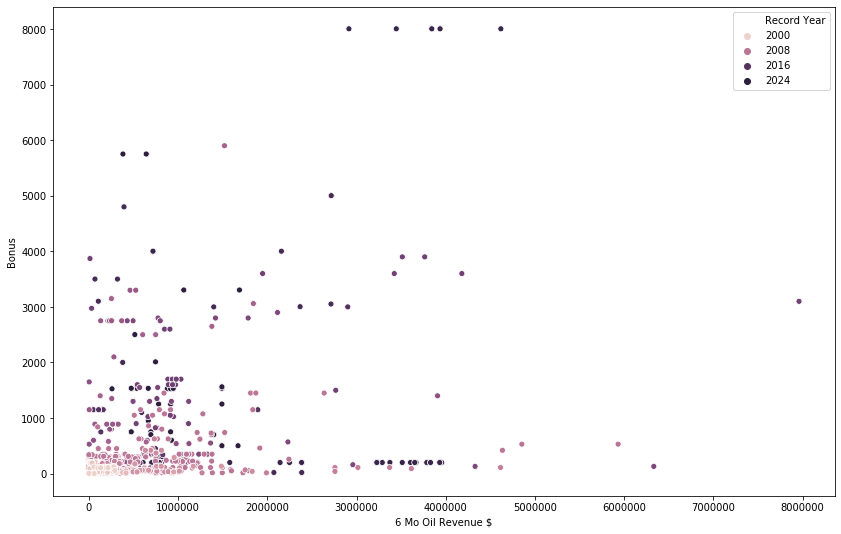

<Figure size 1008x648 with 0 Axes>

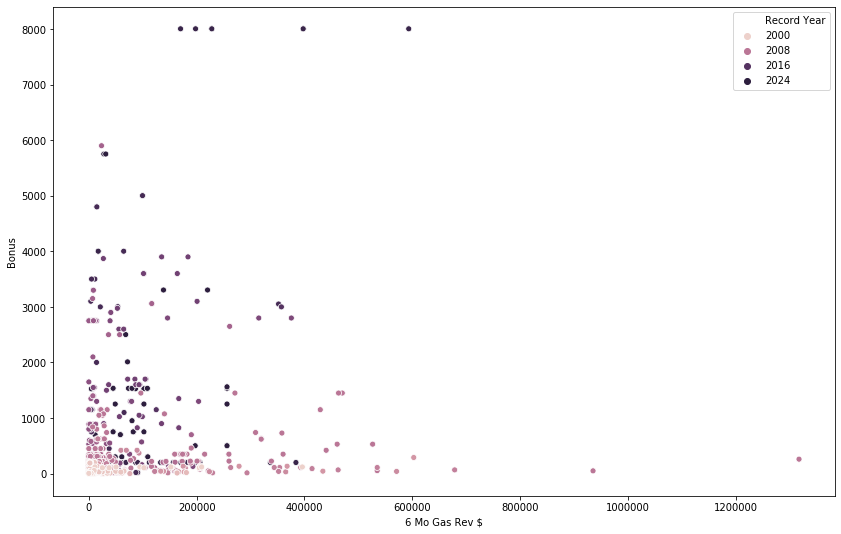

<Figure size 1008x648 with 0 Axes>

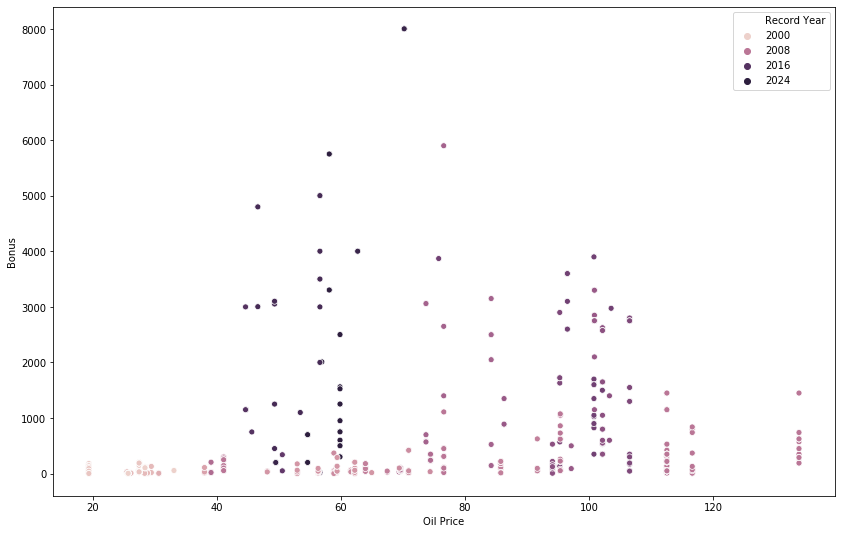

<Figure size 1008x648 with 0 Axes>

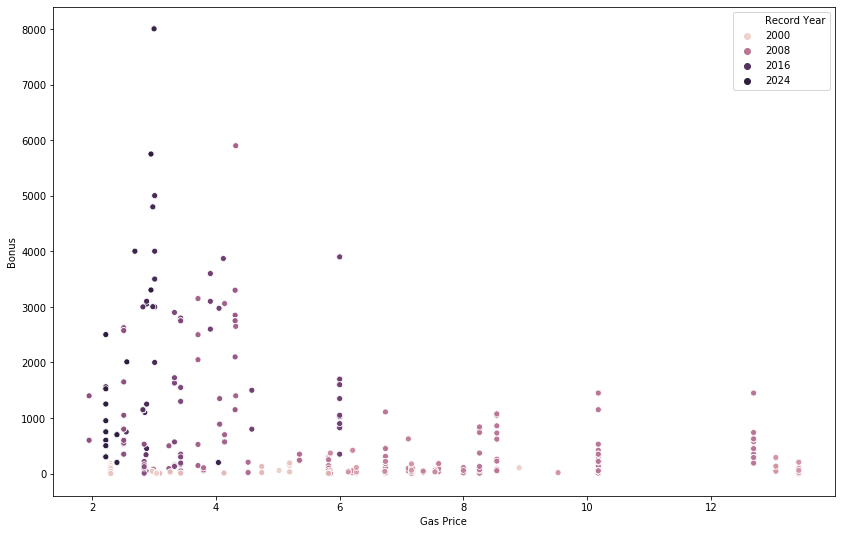

In [40]:
#Basically doing a pairplot for the features and the dependent/target variable (Bonus)
for col in learningCols:
    plt.figure(figsize = (14,9))
    sns.scatterplot(x = trainLeases[col], y = trainLeases["Bonus"], hue = trainLeases["Record Year"])
    plt.show()

we see that light colored dots do not correlate linearly with bonus price. This may tell us that the older data did not capture bonus price well and will hurt our model. Therefore, we will drop it bonus prices before 2008.

### Univariate Distributions on Each Predictor Feature

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total Permits - Histogram')

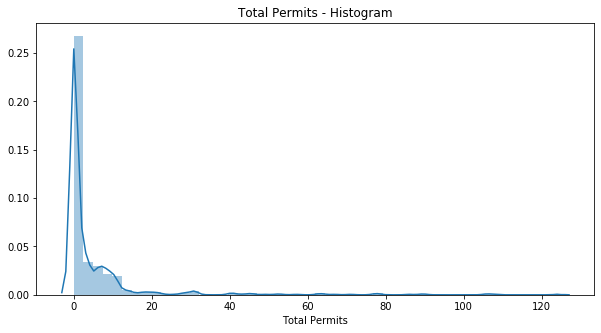

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total Wells - Histogram')

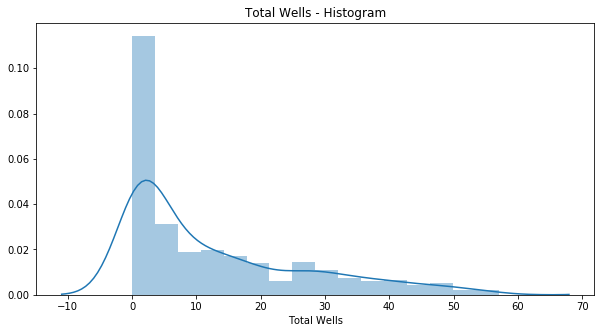

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Oil - Histogram')

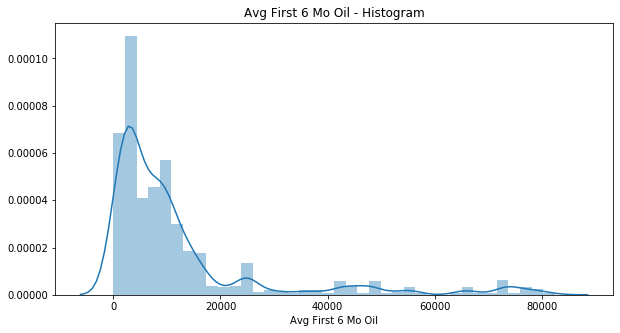

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Gas - Histogram')

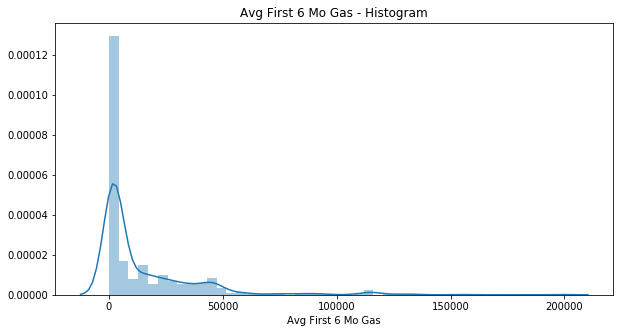

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Qi Oil - Histogram')

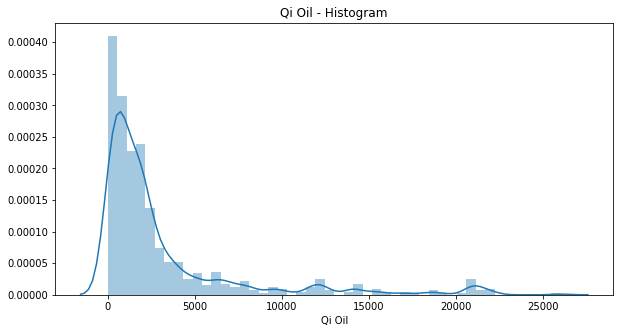

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Qi Gas - Histogram')

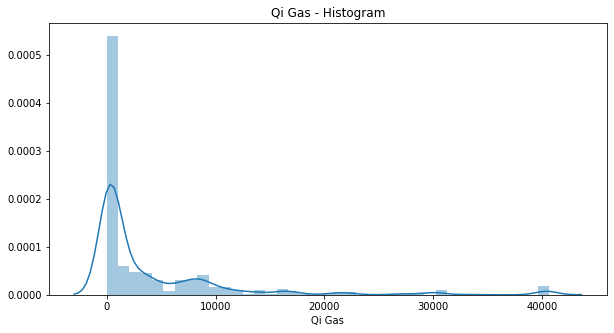

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, '6 Mo Oil Revenue $ - Histogram')

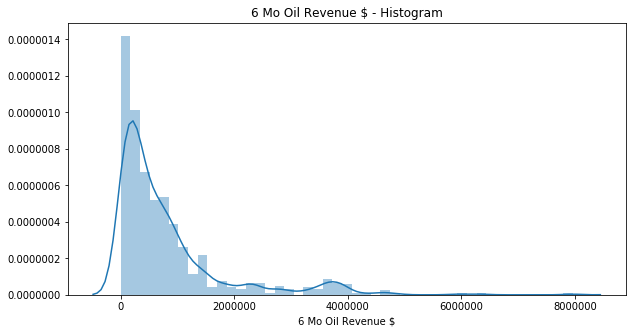

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, '6 Mo Gas Rev $ - Histogram')

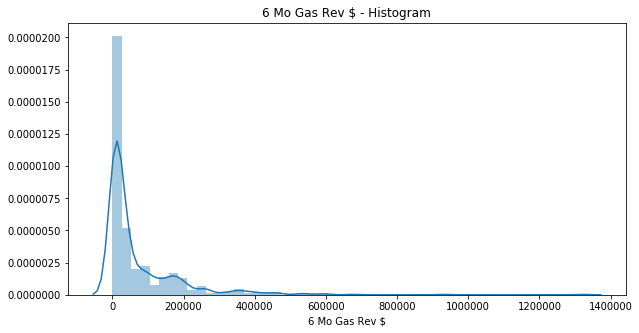

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Oil Price - Histogram')

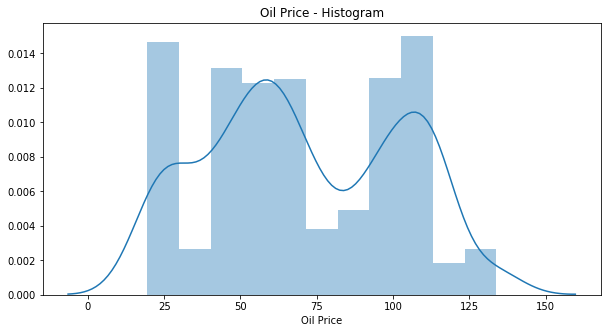

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Gas Price - Histogram')

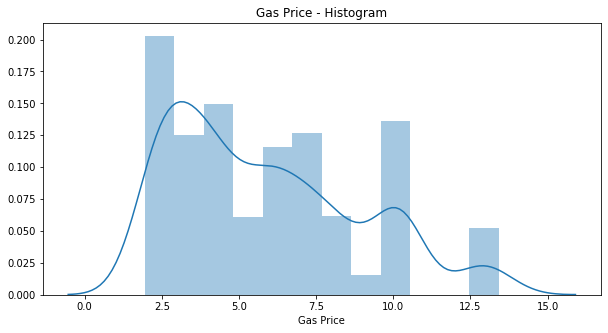

In [41]:
#looking at distributions of learning parameters
for col in learningCols:
    plt.figure(figsize = (10,5))
    sns.distplot(trainLeases[col].dropna())
    plt.title(col + " - Histogram")
    plt.show()

### Visualizing % Representing Each Year

In [42]:
#seeing what perecentage makes up the data by year in order to determine how much data we are losing by dropping older data
trainLeases["Record Year"].value_counts(normalize=True).sort_index(ascending=True)

2000    0.031927
2001    0.106043
2002    0.015964
2003    0.003421
2004    0.003421
2005    0.044470
2006    0.071836
2007    0.068415
2008    0.258837
2009    0.045610
2010    0.018244
2011    0.028506
2012    0.051311
2013    0.034208
2014    0.033067
2015    0.002281
2016    0.019384
2017    0.020525
2018    0.077537
2019    0.064994
Name: Record Year, dtype: float64

<Figure size 1440x720 with 0 Axes>

([<matplotlib.patches.Wedge at 0x1a38d8ec50>,
 [Text(-1.033198681391645, 0.7035627084848703, '2000'),
  Text(-1.2331493179402766, 0.2045550284481684, '2001'),
  Text(-1.2201677587962947, -0.27146020038677415, '2002'),
  Text(-1.2013849400648944, -0.34521620151040194, '2003'),
  Text(-1.193688218622569, -0.3709561115842115, '2004'),
  Text(-1.1246025590417401, -0.5456822190586476, '2005'),
  Text(-0.8553864344769856, -0.9114900151470392, '2006'),
  Text(-0.3849461064830525, -1.189250392097282, '2007'),
  Text(0.8195667943822419, -0.9438274575080003, '2008'),
  Text(1.2436675733257154, 0.1256621146492711, '2009'),
  Text(1.193688195830074, 0.37095618492747007, '2010'),
  Text(1.126550054022019, 0.5416502338068233, '2011'),
  Text(0.9569155908669236, 0.8042465741026237, '2012'),
  Text(0.7091041493257494, 1.0294033735174009, '2013'),
  Text(0.47737727339643116, 1.155253625332805, '2014'),
  Text(0.34641139340153193, 1.201040859638676, '2015'),
  Text(0.26392735138886514, 1.221819280085585

Text(0.5, 1.0, 'Percentage of Data in Train Leases by Record Year')

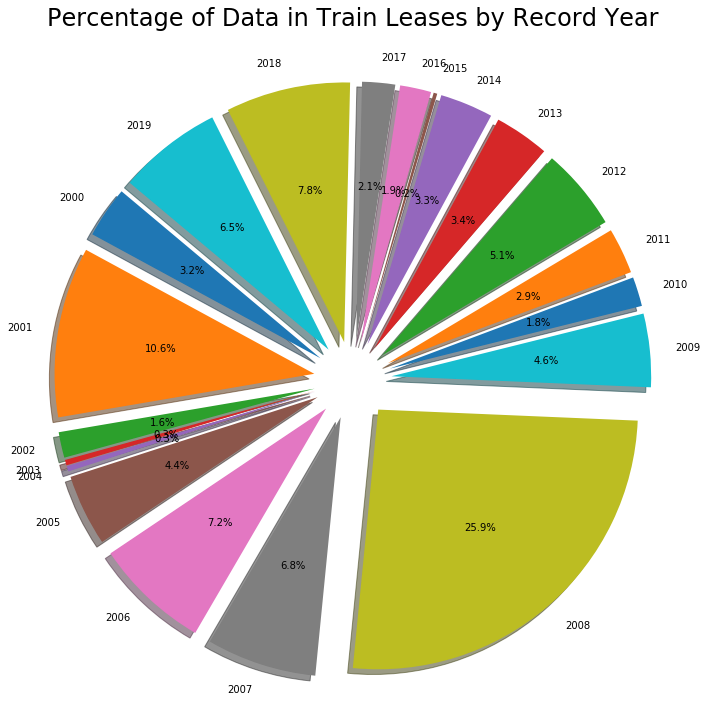

In [43]:
pielabels = trainLeases["Record Year"].value_counts(normalize=True).sort_index(ascending=True).index
separateSlices = np.ones(len(pielabels))*.15
plt.figure(figsize=(20,10))
plt.pie(trainLeases["Record Year"].value_counts().sort_index(ascending=True), explode=separateSlices, labels=pielabels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Percentage of Data in Train Leases by Record Year", size = 24, pad = 30.15)
plt.tight_layout()



### Statistical summary and correlation on training data

In [44]:
trainLeases[MLPredandResponseCols].describe().T

count           mean           std    min            25%  \
Bonus               877.0     574.142531  1.119453e+03   1.00      45.000000   
Total Permits       877.0       4.953250  1.305088e+01   0.00       0.000000   
Total Wells         877.0      12.681870  1.406014e+01   0.00       2.000000   
Avg First 6 Mo Oil  728.0   12233.081407  1.654634e+04   0.00    2934.222222   
Avg First 6 Mo Gas  728.0   14960.141044  2.403980e+04   0.00    1715.000000   
Qi Oil              752.0    3108.859605  4.504364e+03   0.00     650.000000   
Qi Gas              752.0    4186.644980  7.587845e+03   0.00     230.000000   
6 Mo Oil Revenue $  728.0  807317.924529  1.018906e+06   0.00  176369.887500   
6 Mo Gas Rev $      728.0   72771.292607  1.188171e+05   0.00    7564.168319   
Oil Price           877.0      71.015576  3.158620e+01  19.39      49.520000   
Gas Price           877.0       5.890046  3.034515e+00   1.95       3.260000   

                              50%            75%           max  
Bonus                  175.000000     502.000000  8.004000e+03  
Total Permits            0.000000       5.000000  1.240000e+02  
Total Wells              7.000000      20.000000  5.700000e+01  
Avg First 6 Mo Oil    7087.555556   12706.000000  8.244600e+04  
Avg First 6 Mo Gas    3621.500000   21388.916667  1.978497e+05  
Qi Oil                1590.000000    3132.132353  2.601000e+04  
Qi Gas                 648.000000    5012.924710  4.064368e+04  
6 Mo Oil Revenue $  460000.232558  949649.514677  7.959337e+06  
6 Mo Gas Rev $       22687.826667   93001.712500  1.317707e+06  
Oil Price               63.980000     100.900000  1.338800e+02  
Gas Price                5.190000       8.000000  1.342000e+01

#### Pearson Correlation

In [45]:
#seeing how bonus correlates with the other variables
trainLeases[MLPredandResponseCols].corr()
PearsonCorr = trainLeases[MLPredandResponseCols].corr().iloc[:,0].sort_values(ascending = False)

Bonus  Total Permits  Total Wells  Avg First 6 Mo Oil  \
Bonus               1.000000       0.520152     0.217971            0.232796   
Total Permits       0.520152       1.000000     0.225259            0.274472   
Total Wells         0.217971       0.225259     1.000000            0.152802   
Avg First 6 Mo Oil  0.232796       0.274472     0.152802            1.000000   
Avg First 6 Mo Gas  0.359016       0.408043     0.308820            0.649864   
Qi Oil              0.214482       0.243952     0.147313            0.978520   
Qi Gas              0.225148       0.242763     0.148268            0.364645   
6 Mo Oil Revenue $  0.311128       0.268723     0.129807            0.927851   
6 Mo Gas Rev $      0.159714       0.159058     0.194420            0.533837   
Oil Price           0.127339      -0.055912    -0.031209           -0.141128   
Gas Price          -0.276308      -0.222488    -0.158125           -0.223862   

                    Avg First 6 Mo Gas    Qi Oil    Qi Gas  \
Bonus                         0.359016  0.214482  0.225148   
Total Permits                 0.408043  0.243952  0.242763   
Total Wells                   0.308820  0.147313  0.148268   
Avg First 6 Mo Oil            0.649864  0.978520  0.364645   
Avg First 6 Mo Gas            1.000000  0.597319  0.657938   
Qi Oil                        0.597319  1.000000  0.377478   
Qi Gas                        0.657938  0.377478  1.000000   
6 Mo Oil Revenue $            0.646001  0.896771  0.353772   
6 Mo Gas Rev $                0.817183  0.482429  0.533151   
Oil Price                    -0.083125 -0.132582 -0.055267   
Gas Price                    -0.222803 -0.209496 -0.147296   

                    6 Mo Oil Revenue $  6 Mo Gas Rev $  Oil Price  Gas Price  
Bonus                         0.311128        0.159714   0.127339  -0.276308  
Total Permits                 0.268723        0.159058  -0.055912  -0.222488  
Total Wells                   0.129807        0.194420  -0.031209  -0.158125  
Avg First 6 Mo Oil            0.927851        0.533837  -0.141128  -0.223862  
Avg First 6 Mo Gas            0.646001        0.817183  -0.083125  -0.222803  
Qi Oil                        0.896771        0.482429  -0.132582  -0.209496  
Qi Gas                        0.353772        0.533151  -0.055267  -0.147296  
6 Mo Oil Revenue $            1.000000        0.590024   0.086221  -0.119409  
6 Mo Gas Rev $                0.590024        1.000000   0.028982   0.087014  
Oil Price                     0.086221        0.028982   1.000000   0.518483  
Gas Price                    -0.119409        0.087014   0.518483   1.000000

#### Spearman Correlation

In [46]:
trainLeases[MLPredandResponseCols].corr(method = "spearman")
SpearmanCorr = trainLeases[MLPredandResponseCols].corr(method = "spearman").iloc[:,0].sort_values(ascending=False)

Bonus  Total Permits  Total Wells  Avg First 6 Mo Oil  \
Bonus               1.000000       0.485974     0.395839            0.258122   
Total Permits       0.485974       1.000000     0.529393            0.315009   
Total Wells         0.395839       0.529393     1.000000            0.487900   
Avg First 6 Mo Oil  0.258122       0.315009     0.487900            1.000000   
Avg First 6 Mo Gas  0.287578       0.256708     0.487378            0.857125   
Qi Oil              0.268085       0.296514     0.496565            0.962857   
Qi Gas              0.281372       0.255448     0.492940            0.720563   
6 Mo Oil Revenue $  0.376300       0.278336     0.416832            0.913666   
6 Mo Gas Rev $      0.218746       0.142311     0.445887            0.802913   
Oil Price           0.318337      -0.096520    -0.031444           -0.093259   
Gas Price          -0.232622      -0.397700    -0.127102           -0.239028   

                    Avg First 6 Mo Gas    Qi Oil    Qi Gas  \
Bonus                         0.287578  0.268085  0.281372   
Total Permits                 0.256708  0.296514  0.255448   
Total Wells                   0.487378  0.496565  0.492940   
Avg First 6 Mo Oil            0.857125  0.962857  0.720563   
Avg First 6 Mo Gas            1.000000  0.822169  0.862537   
Qi Oil                        0.822169  1.000000  0.751857   
Qi Gas                        0.862537  0.751857  1.000000   
6 Mo Oil Revenue $            0.781442  0.889183  0.639941   
6 Mo Gas Rev $                0.946777  0.776870  0.817271   
Oil Price                    -0.075631 -0.044488 -0.079755   
Gas Price                    -0.238898 -0.204181 -0.227774   

                    6 Mo Oil Revenue $  6 Mo Gas Rev $  Oil Price  Gas Price  
Bonus                         0.376300        0.218746   0.318337  -0.232622  
Total Permits                 0.278336        0.142311  -0.096520  -0.397700  
Total Wells                   0.416832        0.445887  -0.031444  -0.127102  
Avg First 6 Mo Oil            0.913666        0.802913  -0.093259  -0.239028  
Avg First 6 Mo Gas            0.781442        0.946777  -0.075631  -0.238898  
Qi Oil                        0.889183        0.776870  -0.044488  -0.204181  
Qi Gas                        0.639941        0.817271  -0.079755  -0.227774  
6 Mo Oil Revenue $            1.000000        0.783162   0.266354  -0.069109  
6 Mo Gas Rev $                0.783162        1.000000   0.058546   0.036750  
Oil Price                     0.266354        0.058546   1.000000   0.500332  
Gas Price                    -0.069109        0.036750   0.500332   1.000000

### Plotting Spearman vs Pearson Correlation

Text(0.5, 1.0, 'Pearson vs Spearman Correlation')

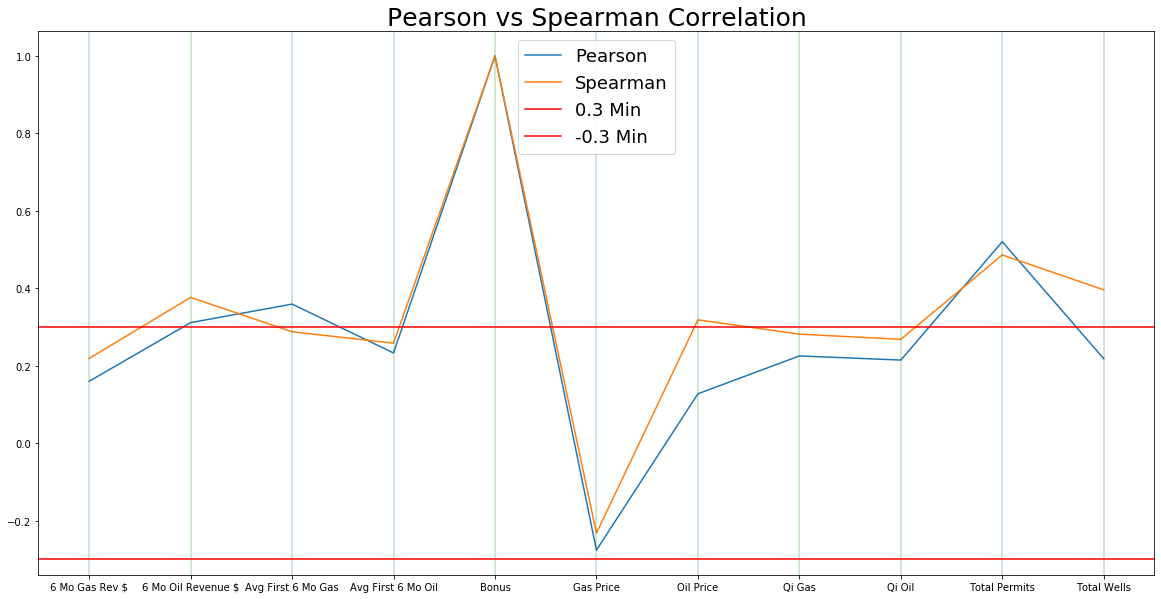

In [47]:
#Plotting spearman vs rank
fig, ax = plt.subplots(figsize = (20,10))
sns.lineplot(x=PearsonCorr.index, y=PearsonCorr.values, ax = ax, label = "Pearson")
sns.lineplot(x=SpearmanCorr.index, y=SpearmanCorr.values, ax = ax, label = "Spearman")
for i in SpearmanCorr.index:
    plt.axvline(i, color = 'green', alpha = .25)

plt.axhline(.3, color = 'r', label = "0.3 Min")
plt.axhline(-.3, color = 'r', label = "-0.3 Min")
ax.set_title("Pearson vs Spearman Correlation", size = 25)
plt.legend(prop={'size': 18})

### Univariate Distribution Response Feature

#### Log Transformation dude to high variance and magnitudes of response feature

In [48]:
#adding log bonus since bonus varies multiple magnitudes
trainLeases["Log Bonus"] = trainLeases["Bonus"].apply(lambda x: np.log(x))

Text(0.5, 1.0, 'Bonus - Histogram')

Text(0.5, 1.0, 'Log Bonus - Histogram')

Text(0.5, 1.025, 'Bonus Histogram vs. Log Bonus Histogram')

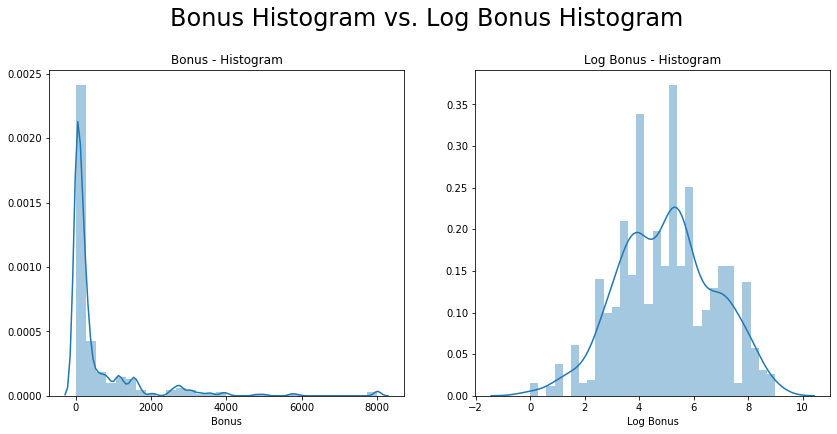

In [144]:
fig, ax = plt.subplots(1,2, figsize = (14,6))
sns.distplot(trainLeases["Bonus"], bins = round(math.sqrt(trainLeases.shape[0])), ax = ax[0])
ax[0].set_title("Bonus - Histogram")
sns.distplot(trainLeases["Log Bonus"],bins = round(math.sqrt(trainLeases.shape[0])),  ax = ax[1])
ax[1].set_title("Log Bonus - Histogram")
plt.suptitle("Bonus Histogram vs. Log Bonus Histogram", size = 24, y = 1.025)

<Figure size 1080x504 with 0 Axes>

Text(0.5, 1.0, 'Bonus Distribution - Under $10/acre')

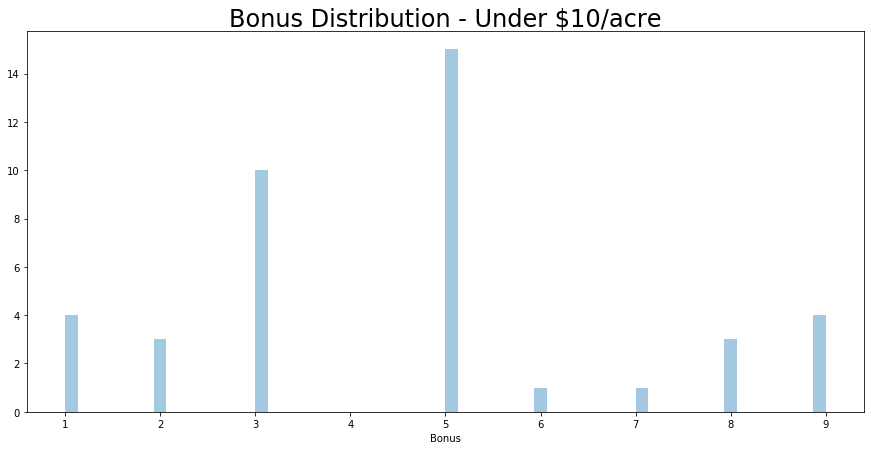

In [50]:
plt.figure(figsize=(15,7))
sns.distplot(trainLeases[trainLeases["Bonus"]<10]["Bonus"], kde = False, bins = 60)
plt.title("Bonus Distribution - Under $10/acre", size = 24)

### Evaluating records with null values for learning parameters but have bonus price

In [51]:
#seeing which columns have null values - this could be because there are 0 wells in the area
null_columns=trainLeases.columns[trainLeases.isnull().any()]
trainLeases[null_columns].isnull().sum()

Record Number          22
Avg First 6 Mo Oil    149
Avg First 6 Mo Gas    149
Qi Oil                125
Qi Gas                125
6 Mo Oil Revenue $    149
6 Mo Gas Rev $        149
dtype: int64

### Evaluating Leases Where There Are Null values for Training Parameters
* seeing how bonus price varies amongst these leases

Record Date Record Number  Bonus  Section  Township  Range  \
LeaseIndex                                                              
1860        2017-03-15      17-00125   1251       36        39     71   
2591        2013-02-05     WYW181745   1630       32        40     71   
2592        2013-02-05     WYW181746   1725       18        40     71   
2595        2013-02-05     WYW181741    145       31        39     70   
2597        2013-02-05     WYW181746   1725       19        40     71   
2630        2012-08-07     WYW181148    125       15        40     71   
2693        2012-02-07     WYW180598    530       10        38     71   
2694        2012-02-07     WYW180599   1050        4        39     71   
2696        2012-02-07     WYW180603   2625       21        40     71   
2698        2012-02-07     WYW180607   2625       29        40     71   
2712        2012-02-07     WYW180603   2625       20        40     71   
2713        2012-02-07     WYW180604   1650       22        40     71   
2714        2012-02-07     WYW180604   1650       27        40     71   
2715        2012-02-07     WYW180606   2575       28        40     71   
2716        2012-02-07     WYW180606   2575       33        40     71   
2717        2012-02-07     WYW180608    800       30        40     71   
2754        2011-11-02      11-00301    500       16        38     71   
2755        2011-11-02      11-00302     90       36        39     71   
2866        2011-05-04      11-00105   2850       35        38     72   
2895        2010-11-03      10-00781    525       36        38     70   
2896        2010-11-03      10-00782   2050       20        38     71   
2974        2010-05-11     WYW179133    570       35        37     71   
2978        2010-05-11     WYW179133    570       28        37     71   
3006        2009-12-01     WYW178792    230        5        38     70   
3007        2009-12-01     WYW178796    240       12        38     71   
3011        2009-12-01     WYW178796    240        1        38     71   
3022        2009-09-30           NaN     80       16        38     70   
3023        2009-09-30           NaN     30       19        38     71   
3037        2009-06-02     WYW178336     52       26        39     71   
3038        2009-06-02     WYW178336     52       29        39     71   
...                ...           ...    ...      ...       ...    ...   
4105        2001-12-04        154918    150       29        38     71   
4107        2001-12-04        154920    150       32        39     71   
4108        2001-12-04        154922    150       33        39     71   
4117        2001-12-04        154912     13       14        37     71   
4122        2001-12-04        154911      3       14        37     71   
4123        2001-12-04        154911      3       22        37     71   
4124        2001-12-04        154911      3       23        37     71   
4125        2001-12-04        154911      3       25        37     71   
4128        2001-12-04        154912     13       23        37     71   
4129        2001-12-04        154912     13       25        37     71   
4130        2001-12-04        154913     18       23        37     71   
4132        2001-12-04        154917     80       28        38     71   
4133        2001-12-04        154918    150       33        38     71   
4134        2001-12-04        154920    150       33        39     71   
4135        2001-12-04        154921    140       32        39     71   
4136        2001-12-04        154923    110       18        40     71   
4137        2001-12-04        154923    110       19        40     71   
4140        2001-12-04        155048     41       33        38     71   
4199        2001-04-03        153111     27       35        38     72   
4209        2001-04-03        153115    150       13        40     72   
4211        2001-04-03        153116    200       26        40     72   
4219        2001-04-03        153111     27       23        38     72

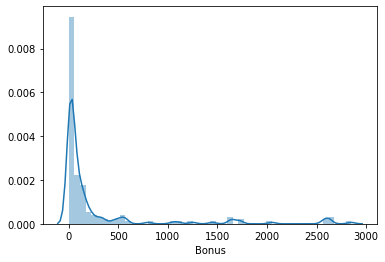

In [52]:
#looking how bonus varies with leases that have null values
trainLeases[trainLeases.isnull().any(axis=1)]
sns.distplot(trainLeases[trainLeases.isnull().any(axis=1)]["Bonus"])

 * ***We see that there are a few cases that bonuses are high and there are no wells or permits to justify this.  This will confuse and cause outliars in our model, so we will remove them***

In [53]:
#creating dataframe holding leases with negligible permits 1 or 0 wells with null revenue to see how bonus varies
zeroPermandProd = trainLeases[(trainLeases["Total Permits"]<2) & (trainLeases["Total Wells"] < 2)]
zeroPermandProd = zeroPermandProd[zeroPermandProd.isnull().any(axis =1)]
zeroPermandProd

Record Date Record Number  Bonus  Section  Township  Range  \
LeaseIndex                                                              
1860        2017-03-15      17-00125   1251       36        39     71   
2595        2013-02-05     WYW181741    145       31        39     70   
2630        2012-08-07     WYW181148    125       15        40     71   
2693        2012-02-07     WYW180598    530       10        38     71   
2694        2012-02-07     WYW180599   1050        4        39     71   
2713        2012-02-07     WYW180604   1650       22        40     71   
2714        2012-02-07     WYW180604   1650       27        40     71   
2715        2012-02-07     WYW180606   2575       28        40     71   
2716        2012-02-07     WYW180606   2575       33        40     71   
2755        2011-11-02      11-00302     90       36        39     71   
2866        2011-05-04      11-00105   2850       35        38     72   
2895        2010-11-03      10-00781    525       36        38     70   
2896        2010-11-03      10-00782   2050       20        38     71   
2974        2010-05-11     WYW179133    570       35        37     71   
2978        2010-05-11     WYW179133    570       28        37     71   
3006        2009-12-01     WYW178792    230        5        38     70   
3007        2009-12-01     WYW178796    240       12        38     71   
3011        2009-12-01     WYW178796    240        1        38     71   
3022        2009-09-30           NaN     80       16        38     70   
3023        2009-09-30           NaN     30       19        38     71   
3037        2009-06-02     WYW178336     52       26        39     71   
3038        2009-06-02     WYW178336     52       29        39     71   
3039        2009-06-02     WYW178337     67       34        39     71   
3045        2009-06-02     WYW178336     52       22        39     71   
3046        2009-06-02     WYW178336     52       27        39     71   
3047        2009-06-02     WYW178337     67       35        39     71   
3052        2009-02-04           NaN     13       36        40     70   
3054        2009-02-03     WYW178000     21       13        38     71   
3055        2009-02-03     WYW178000     21       19        38     71   
3056        2009-02-03     WYW178000     21       33        38     71   
...                ...           ...    ...      ...       ...    ...   
4104        2001-12-04        154916     50        8        38     71   
4105        2001-12-04        154918    150       29        38     71   
4107        2001-12-04        154920    150       32        39     71   
4108        2001-12-04        154922    150       33        39     71   
4117        2001-12-04        154912     13       14        37     71   
4122        2001-12-04        154911      3       14        37     71   
4123        2001-12-04        154911      3       22        37     71   
4124        2001-12-04        154911      3       23        37     71   
4125        2001-12-04        154911      3       25        37     71   
4128        2001-12-04        154912     13       23        37     71   
4129        2001-12-04        154912     13       25        37     71   
4130        2001-12-04        154913     18       23        37     71   
4132        2001-12-04        154917     80       28        38     71   
4133        2001-12-04        154918    150       33        38     71   
4134        2001-12-04        154920    150       33        39     71   
4135        2001-12-04        154921    140       32        39     71   
4136        2001-12-04        154923    110       18        40     71   
4137        2001-12-04        154923    110       19        40     71   
4140        2001-12-04        155048     41       33        38     71   
4199        2001-04-03        153111     27       35        38     72   
4209        2001-04-03        153115    150       13        40     72   
4219        2001-04-03        153111     27       23        38     72

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Bonus Distribution For Leases With Null Training Parameters (Oil Revenue, Wells, Etc)')

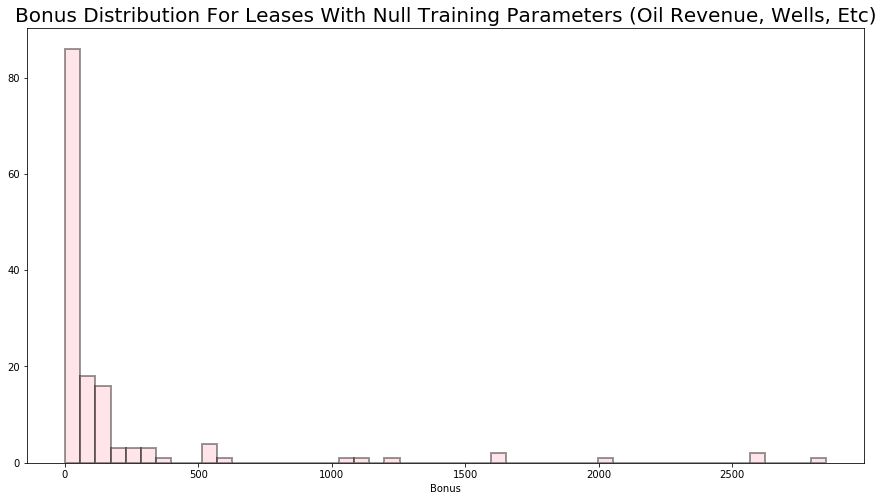

In [54]:
#creating a historgram of bonus prices wehn there are less than 2 permits or wells in area
plt.figure(figsize = (15,8))
sns.distplot(zeroPermandProd["Bonus"], kde = False, color ='pink', hist_kws=dict(edgecolor = 'k', linewidth=2))
plt.title("Bonus Distribution for Leases with null training parameters (oil revenue, wells, etc)".title(), size = 20)


#### Removing outliars from dataset

In [55]:
#obtaining the bonus price at the given quantile
quantile1 = zeroPermandProd["Bonus"].quantile(.80)
quantile1


150.0

In [56]:
#getting leases that are outliars based on high bonus prices where there is no data to support the high
zeroPermandProd[zeroPermandProd["Bonus"]>quantile1].count()
indexToDrop = zeroPermandProd[zeroPermandProd["Bonus"]>quantile1].index

Record Date           24
Record Number         23
Bonus                 24
Section               24
Township              24
Range                 24
geometry              24
buffers               24
Total Permits         24
Total Wells           24
Avg First 6 Mo Oil     0
Avg First 6 Mo Gas     0
Qi Oil                 4
Qi Gas                 4
6 Mo Oil Revenue $     0
6 Mo Gas Rev $         0
Oil Price             24
Gas Price             24
TWSHP                 24
Record Year           24
Log Bonus             24
dtype: int64

In [57]:
#dropping leases that could appear problematic based on EDA above
cleanedLeases = trainLeases.drop(index=indexToDrop)
cleanedLeases= trainLeases.dropna()

cleanedLeases = cleanedLeases.loc[cleanedLeases["Record Year"]>2007]

### Checking training data after cleaning data 




In [58]:
#unclean leases stat summary
trainLeases.describe()

#clean leases summary
cleanedLeases.describe()
cleanedLeases.isnull().any(axis=1).value_counts()

Bonus     Section    Township       Range  Total Permits  \
count   877.000000  877.000000  877.000000  877.000000     877.000000   
mean    574.142531   19.392246   38.291904   71.834664       4.953250   
std    1119.452950   10.551086    1.075502    1.052843      13.050879   
min       1.000000    1.000000   37.000000   70.000000       0.000000   
25%      45.000000   11.000000   37.000000   71.000000       0.000000   
50%     175.000000   20.000000   38.000000   72.000000       0.000000   
75%     502.000000   29.000000   39.000000   73.000000       5.000000   
max    8004.000000   36.000000   40.000000   74.000000     124.000000   

       Total Wells  Avg First 6 Mo Oil  Avg First 6 Mo Gas        Qi Oil  \
count   877.000000          728.000000          728.000000    752.000000   
mean     12.681870        12233.081407        14960.141044   3108.859605   
std      14.060138        16546.340344        24039.800775   4504.364424   
min       0.000000            0.000000            0.000000      0.000000   
25%       2.000000         2934.222222         1715.000000    650.000000   
50%       7.000000         7087.555556         3621.500000   1590.000000   
75%      20.000000        12706.000000        21388.916667   3132.132353   
max      57.000000        82446.000000       197849.722222  26010.000000   

             Qi Gas  6 Mo Oil Revenue $  6 Mo Gas Rev $   Oil Price  \
count    752.000000        7.280000e+02    7.280000e+02  877.000000   
mean    4186.644980        8.073179e+05    7.277129e+04   71.015576   
std     7587.844808        1.018906e+06    1.188171e+05   31.586204   
min        0.000000        0.000000e+00    0.000000e+00   19.390000   
25%      230.000000        1.763699e+05    7.564168e+03   49.520000   
50%      648.000000        4.600002e+05    2.268783e+04   63.980000   
75%     5012.924710        9.496495e+05    9.300171e+04  100.900000   
max    40643.684211        7.959337e+06    1.317707e+06  133.880000   

        Gas Price  Record Year   Log Bonus  
count  877.000000   877.000000  877.000000  
mean     5.890046  2009.118586    5.011540  
std      3.034515     5.419151    1.744290  
min      1.950000  2000.000000    0.000000  
25%      3.260000  2006.000000    3.806662  
50%      5.190000  2008.000000    5.164786  
75%      8.000000  2013.000000    6.218600  
max     13.420000  2019.000000    8.987697

Bonus     Section    Township       Range  Total Permits  \
count   484.000000  484.000000  484.000000  484.000000     484.000000   
mean    909.254132   18.280992   38.154959   72.024793       7.012397   
std    1374.880354   10.562815    1.078088    1.019177      14.303131   
min       7.000000    1.000000   37.000000   70.000000       0.000000   
25%     200.000000    9.000000   37.000000   71.000000       0.000000   
50%     340.000000   18.000000   38.000000   72.000000       3.000000   
75%    1150.000000   28.000000   39.000000   73.000000       8.000000   
max    8004.000000   36.000000   40.000000   74.000000     124.000000   

       Total Wells  Avg First 6 Mo Oil  Avg First 6 Mo Gas        Qi Oil  \
count   484.000000          484.000000          484.000000    484.000000   
mean     17.721074        14724.151944        18298.165023   3914.631214   
std      15.057608        18731.206323        27059.953711   5196.940369   
min       1.000000            0.000000            0.000000      0.000000   
25%       3.000000         3089.500000         1913.119048    825.000000   
50%      14.000000         8448.062500         4673.987778   1899.230769   
75%      28.000000        15299.416667        27535.870968   3955.384615   
max      57.000000        82446.000000       197849.722222  26010.000000   

             Qi Gas  6 Mo Oil Revenue $  6 Mo Gas Rev $   Oil Price  \
count    484.000000        4.840000e+02    4.840000e+02  484.000000   
mean    4918.525056        1.013048e+06    7.931435e+04   82.563554   
std     7848.808298        1.117732e+06    1.205738e+05   28.436637   
min        0.000000        0.000000e+00    0.000000e+00   39.090000   
25%      335.772727        2.804290e+05    9.089965e+03   54.660000   
50%     1322.500000        6.691757e+05    3.134103e+04   94.130000   
75%     7433.863636        1.196285e+06    1.086188e+05  112.580000   
max    40643.684211        7.959337e+06    1.317707e+06  133.880000   

        Gas Price  Record Year   Log Bonus  
count  484.000000   484.000000  484.000000  
mean     5.668967  2012.458678    5.889492  
std      3.178930     4.350144    1.458685  
min      1.950000  2008.000000    1.945910  
25%      3.000000  2008.000000    5.298317  
50%      4.060000  2012.000000    5.828946  
75%      8.540000  2018.000000    7.047517  
max     12.690000  2019.000000    8.987697

False    484
dtype: int64

<h5>
* *we lose about 50% of the training data which is not ideal - but our simple linear regression model will suffer without removing outliars*
</h5>

## Looking at correlation plots after cleaning data

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Total Permits vs Bonus')

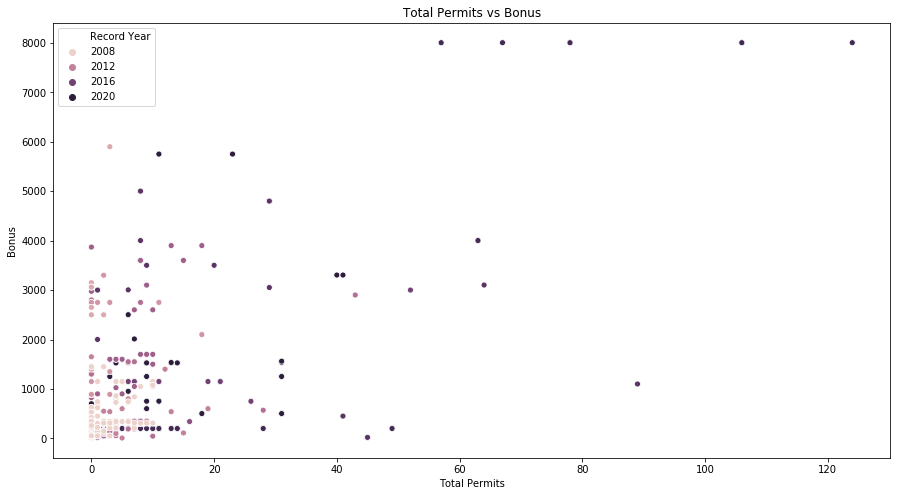

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Total Wells vs Bonus')

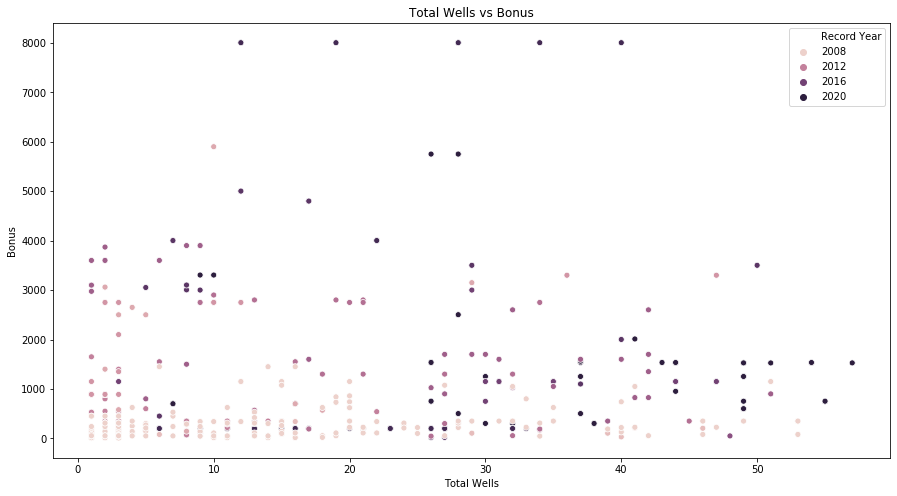

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Oil vs Bonus')

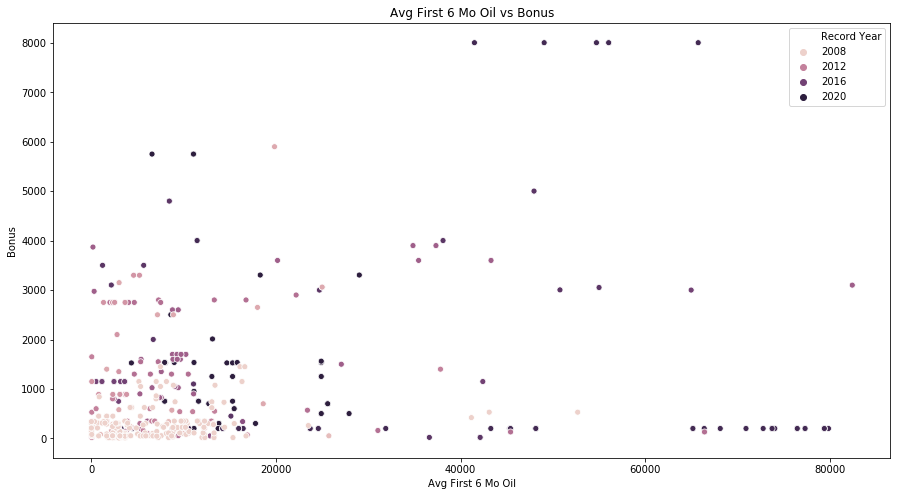

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Gas vs Bonus')

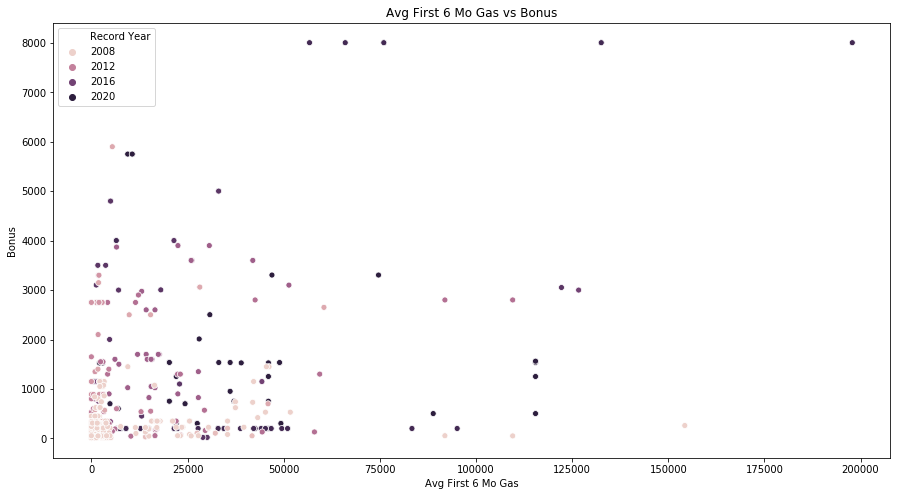

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Qi Oil vs Bonus')

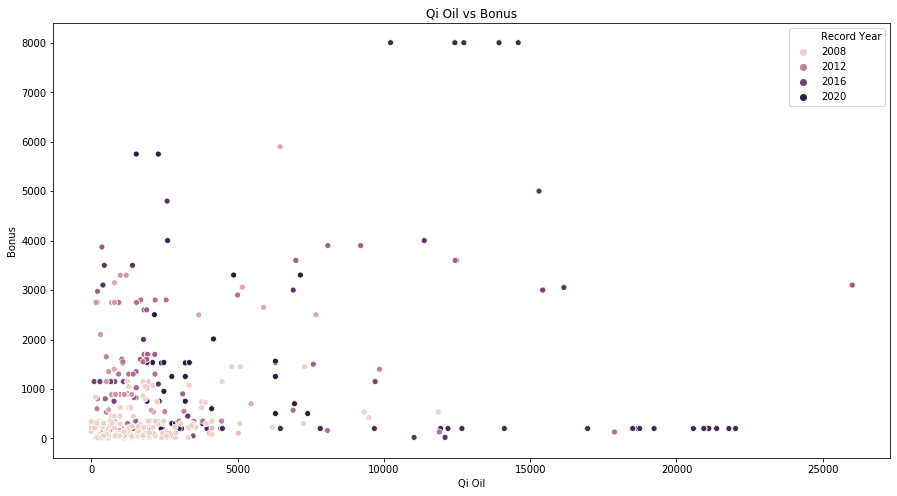

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Qi Gas vs Bonus')

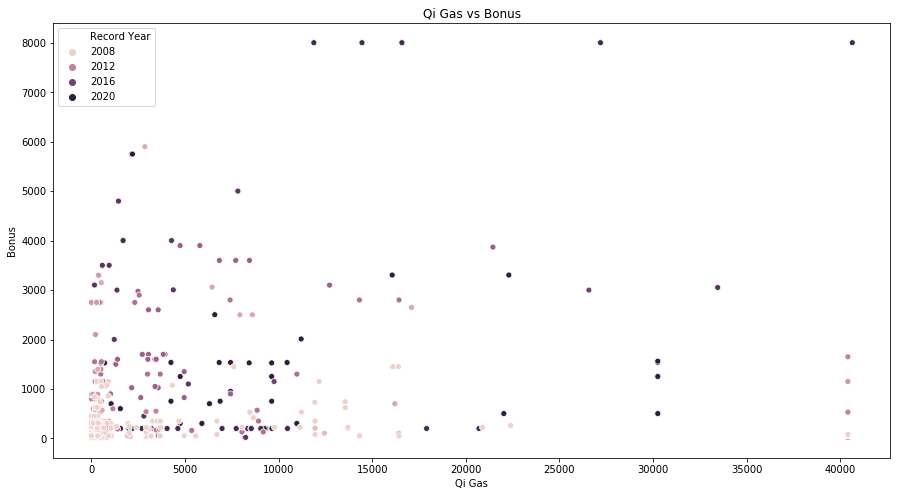

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, '6 Mo Oil Revenue $ vs Bonus')

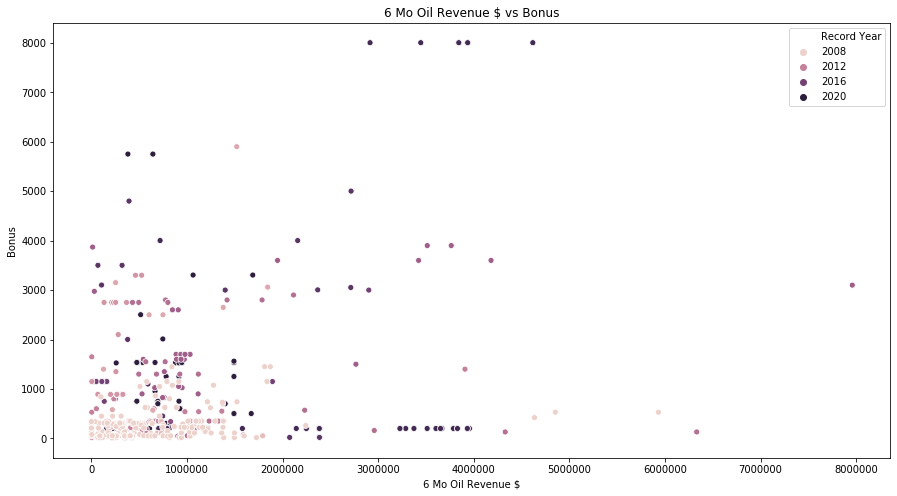

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, '6 Mo Gas Rev $ vs Bonus')

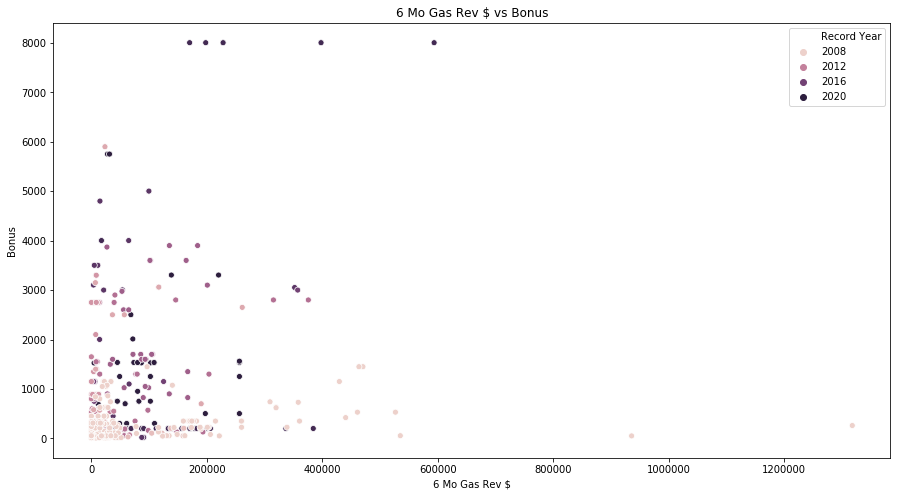

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Oil Price vs Bonus')

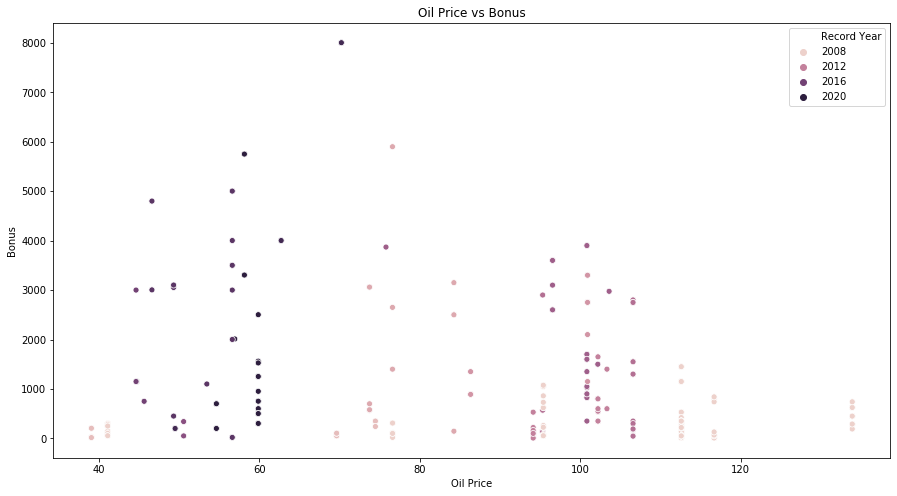

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Gas Price vs Bonus')

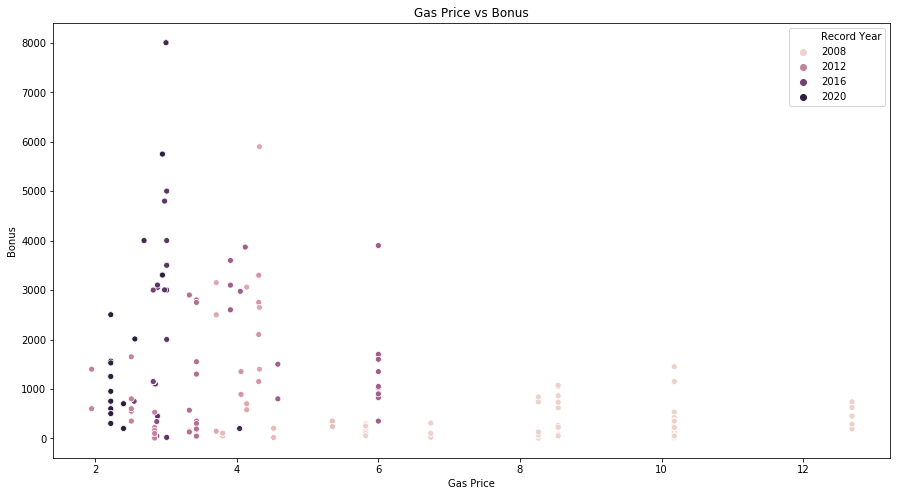

In [59]:
for col in learningCols:
    plt.figure(figsize = (15,8))
    plt.title(col + ' vs Bonus' )
    sns.scatterplot(x = cleanedLeases[col], y = cleanedLeases["Bonus"], hue = cleanedLeases["Record Year"])
    plt.show()

* We see that leases with less than 500 dollar bonus but high 6 mo oil revenue does not seem accurate
* Need to break down this data to see what type of data this is and to potentially clean it further

### Drilling Down on Potential Outliar Data

In [60]:
#getting dataframe of outliaars based on markdown comments above
outliars = cleanedLeases.loc[(cleanedLeases["6 Mo Oil Revenue $"]>2000000) & (cleanedLeases["Bonus"] < 1000)]

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 'ScatterPlot - Oil Revenue vs Bonus - Outliar Line')

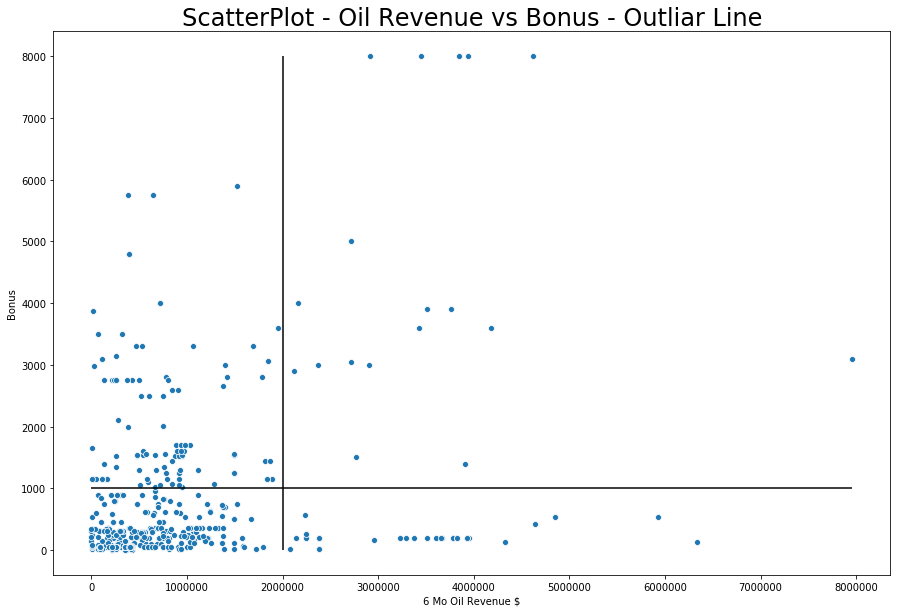

In [61]:
plt.figure(figsize = (15,10))
sns.scatterplot(cleanedLeases["6 Mo Oil Revenue $"], cleanedLeases["Bonus"])
plt.vlines(2000000, ymin = 0, ymax=cleanedLeases["Bonus"].max())
plt.hlines(1000, xmin = 0, xmax = cleanedLeases["6 Mo Oil Revenue $"].max())
plt.title("ScatterPlot - Oil Revenue vs Bonus - Outliar Line", size = 24)

* Bottom right rectangle shows outliars of low bonuses when oil revenue is high

In [62]:
len(outliars)

#filtering the full dataframe containing all prod around training lease to those only belonging to the outliar leases
outLiarTrainingProd = DFtrainProdFilter.loc[DFtrainProdFilter.index.isin(outliars.index)]


47

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 'Scatterplot of Oil Production with abnormal low bonus price')

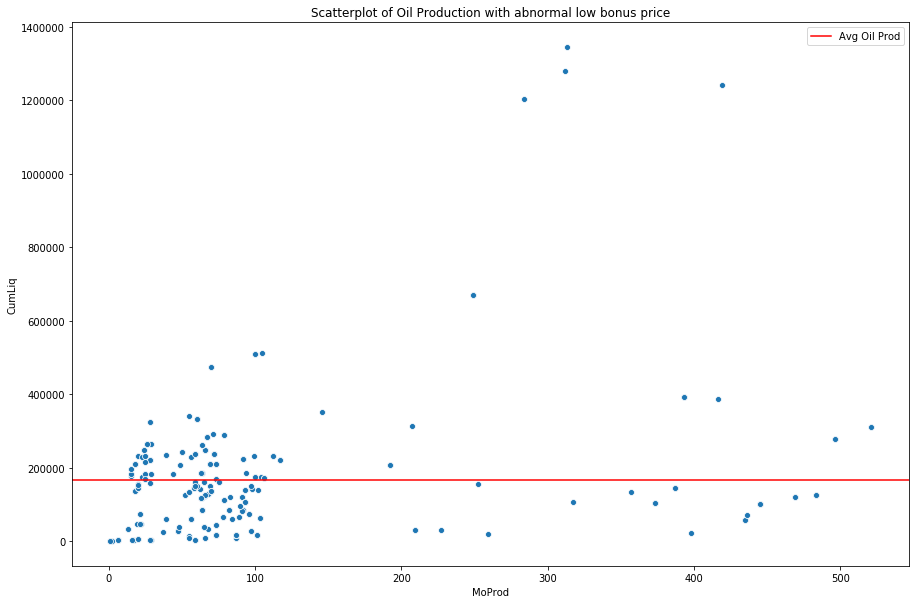

In [63]:
#creating scatterplot of outliar bonuses - showing production vs month prod to see if there are any...
#wells that would lead to low bonus prics
plt.figure(figsize=(15,10))
sns.scatterplot(outLiarTrainingProd["MoProd"], outLiarTrainingProd["CumLiq"])
plt.title("Scatterplot of Oil Production with abnormal low bonus price")
plt.axhline(outLiarTrainingProd["CumLiq"].mean(), color= 'r', label = "Avg Oil Prod")
plt.legend()

* plot shows that low bonus prices from outliars are indeed erraneous data - wells have good average cumulative oil

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

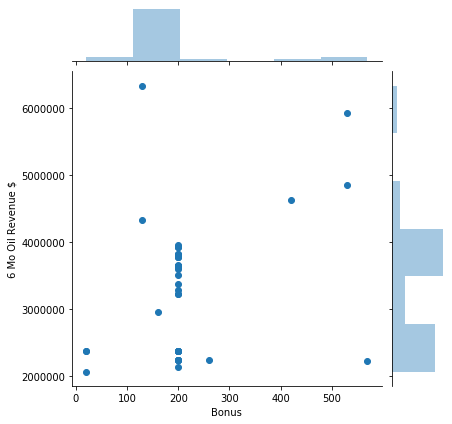

In [64]:
#plot to see how bonuses are distributed a month the outliar 
plt.figure(figsize = (15,7))
sns.jointplot(outliars["Bonus"], outliars["6 Mo Oil Revenue $"])

### Dropping Outliar Production and Regenerating Pairplots

In [65]:
#dropping outliars from cleanedLeases for further cleaning
cleanedLeases.drop(outliars.index, inplace = True)

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Total Permits vs Bonus')

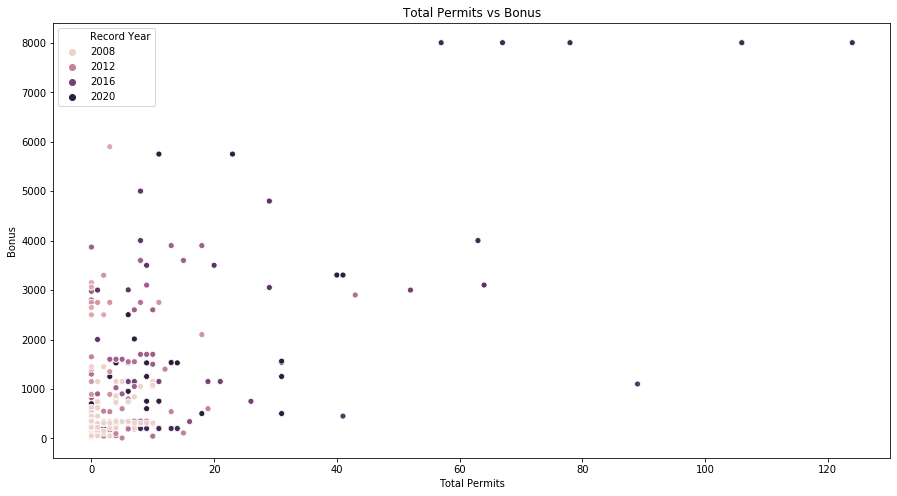

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Total Wells vs Bonus')

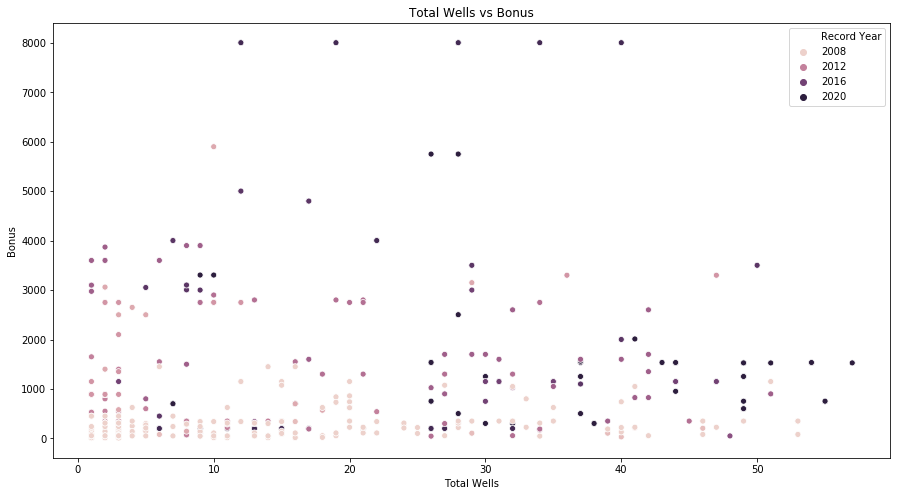

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Oil vs Bonus')

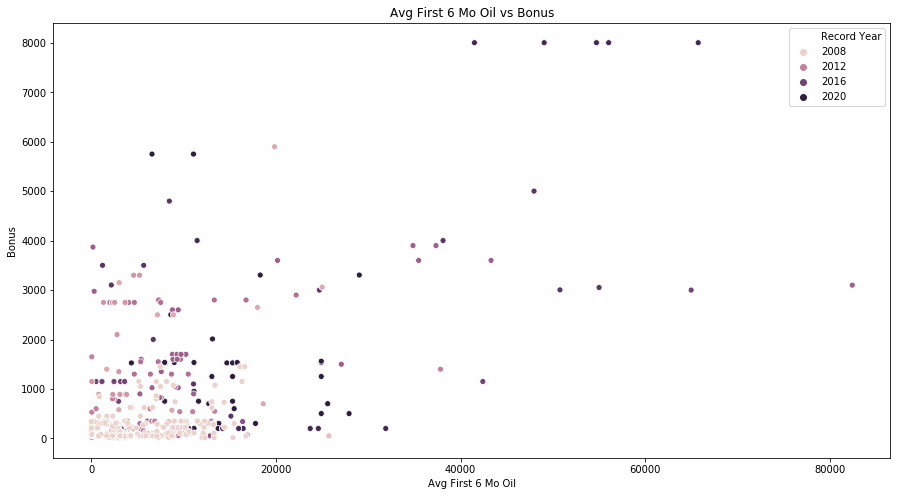

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Gas vs Bonus')

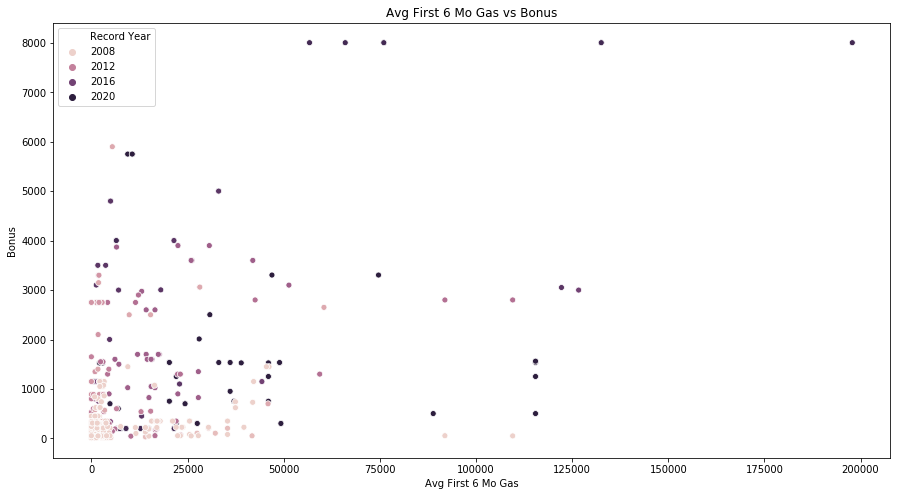

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Qi Oil vs Bonus')

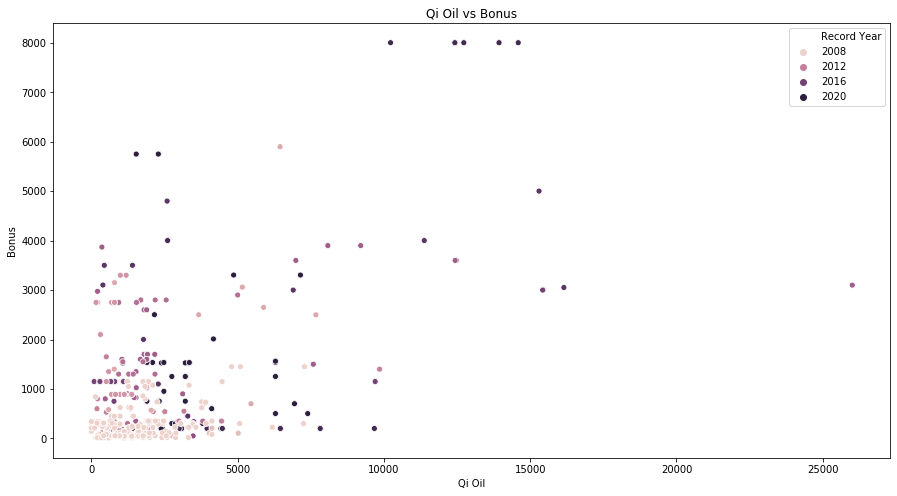

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Qi Gas vs Bonus')

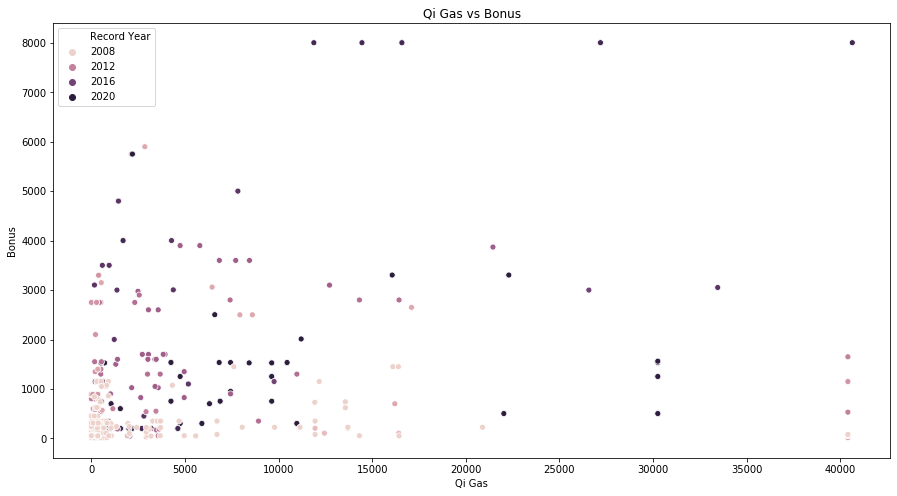

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, '6 Mo Oil Revenue $ vs Bonus')

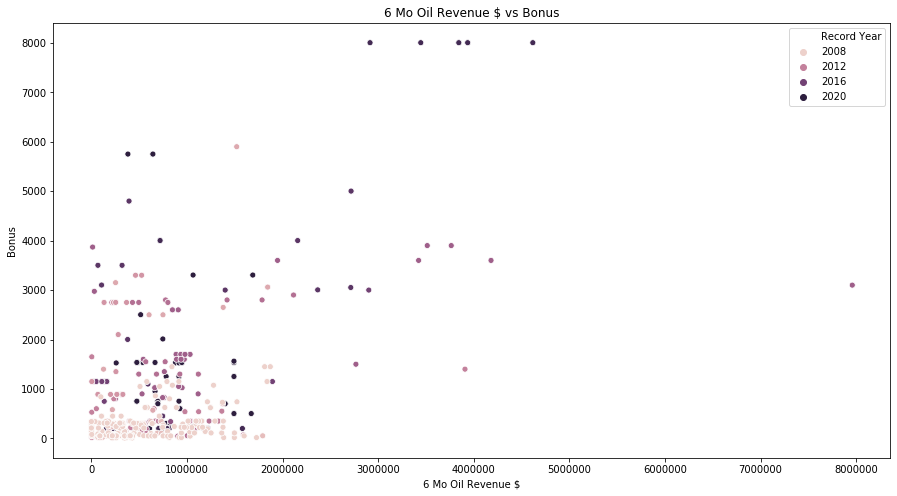

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, '6 Mo Gas Rev $ vs Bonus')

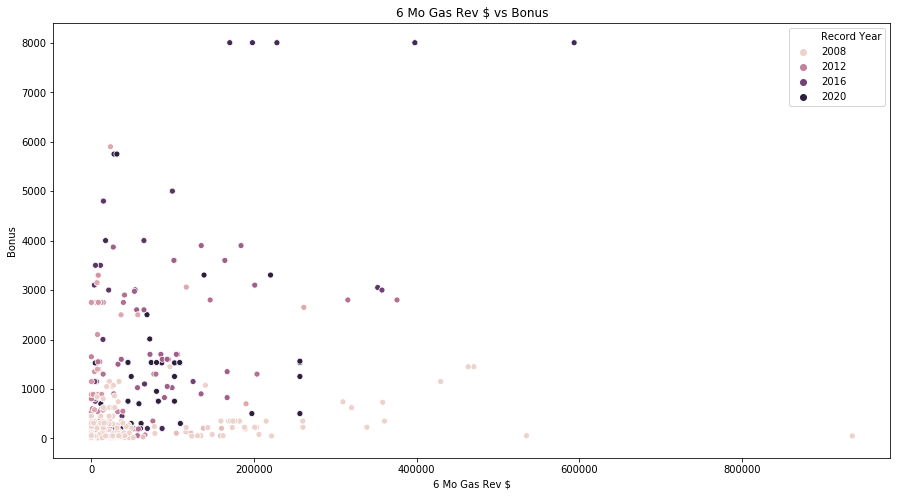

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Oil Price vs Bonus')

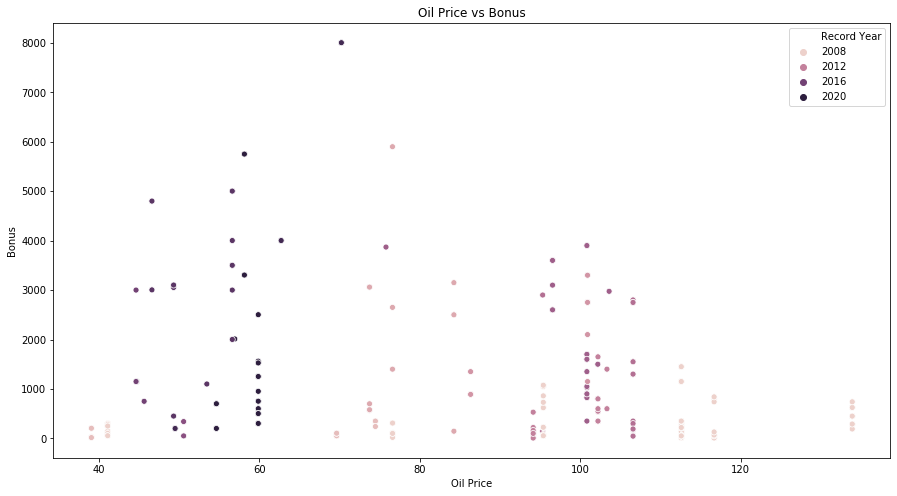

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Gas Price vs Bonus')

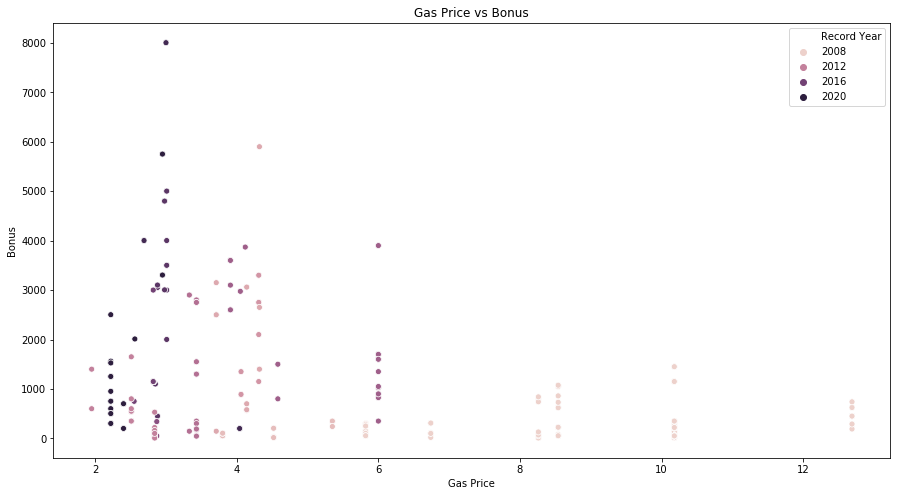

In [66]:
for col in learningCols:
    plt.figure(figsize = (15,8))
    plt.title(col + ' vs Bonus' )
    sns.scatterplot(x = cleanedLeases[col], y = cleanedLeases["Bonus"], hue = cleanedLeases["Record Year"])
    plt.show()

### Pairplot Plots

In [67]:
cleanedLeases[MLPredandResponseCols].shape

(437, 11)

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Bonus vs Bonus')

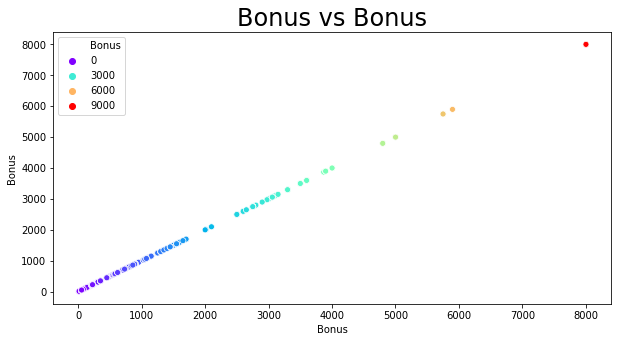

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Bonus vs Total Permits')

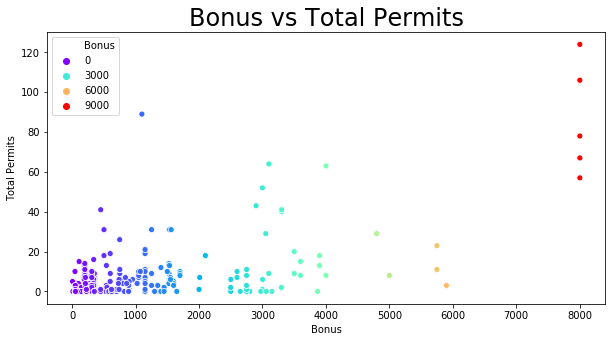

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Bonus vs Total Wells')

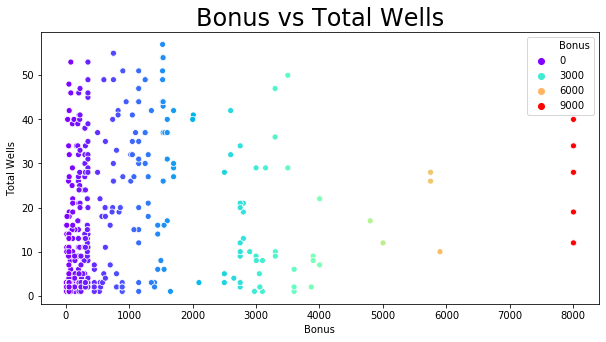

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Bonus vs Avg First 6 Mo Oil')

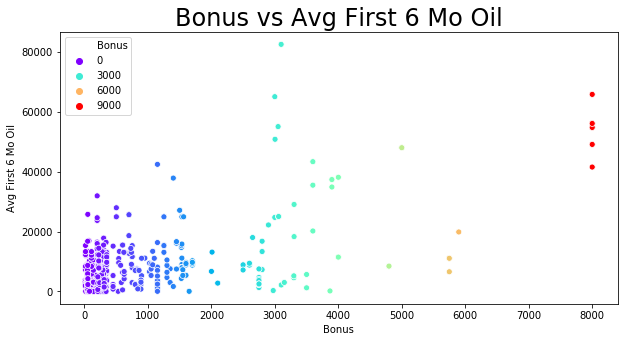

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Bonus vs Avg First 6 Mo Gas')

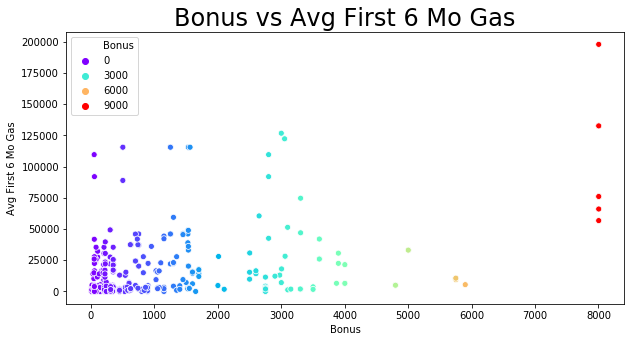

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Bonus vs Qi Oil')

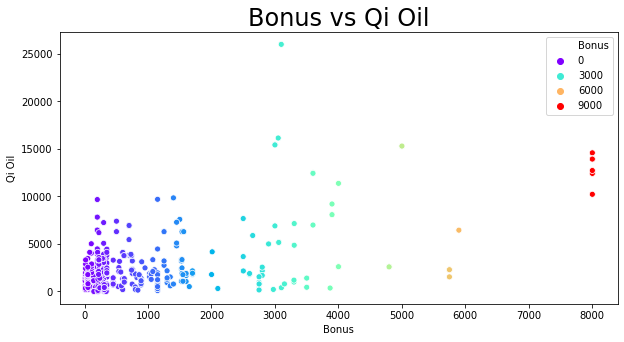

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Bonus vs Qi Gas')

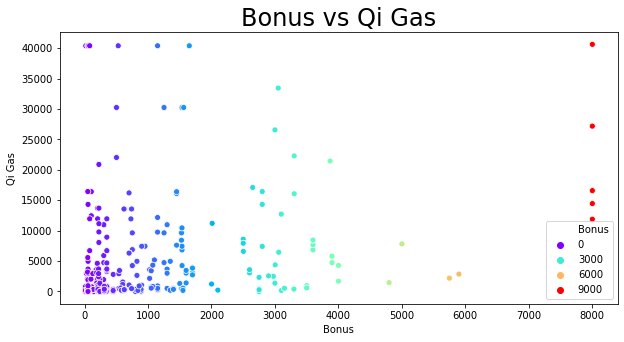

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Bonus vs 6 Mo Oil Revenue $')

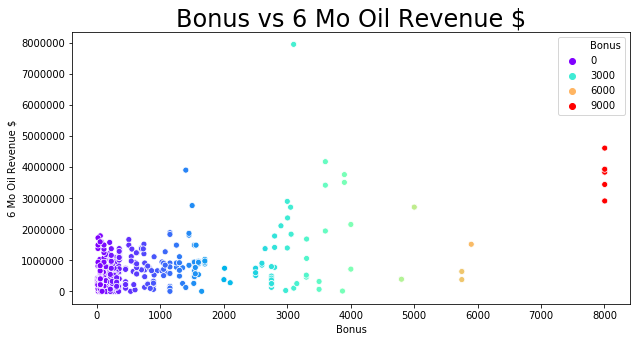

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Bonus vs 6 Mo Gas Rev $')

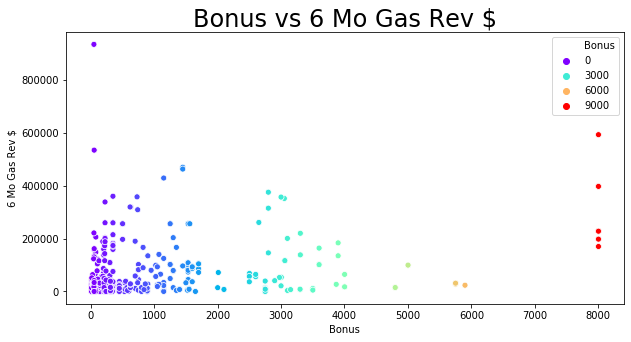

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Bonus vs Oil Price')

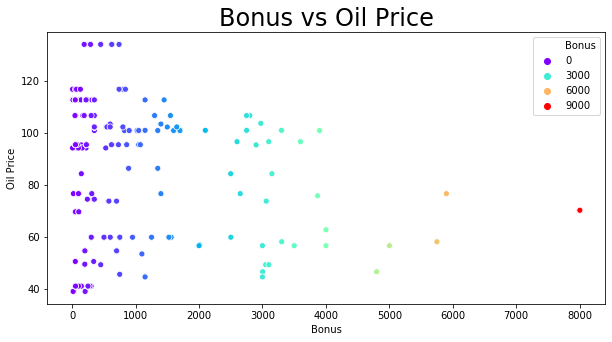

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Bonus vs Gas Price')

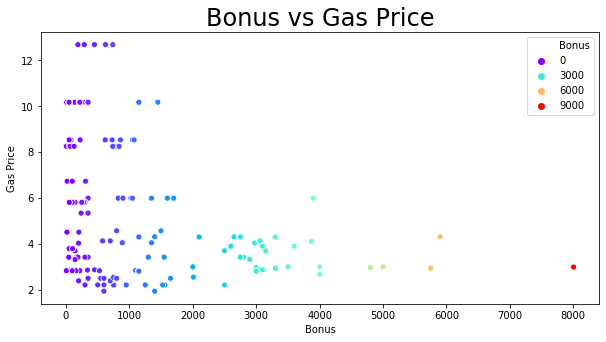

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total Permits vs Bonus')

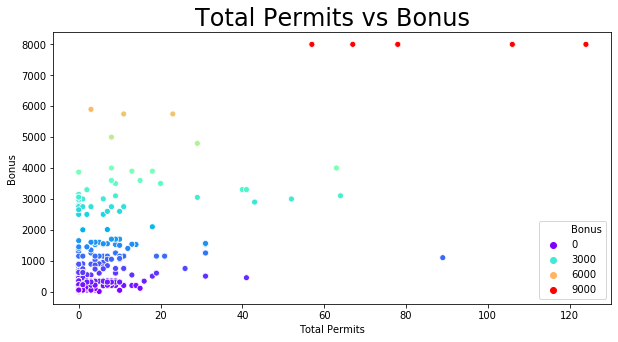

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total Permits vs Total Permits')

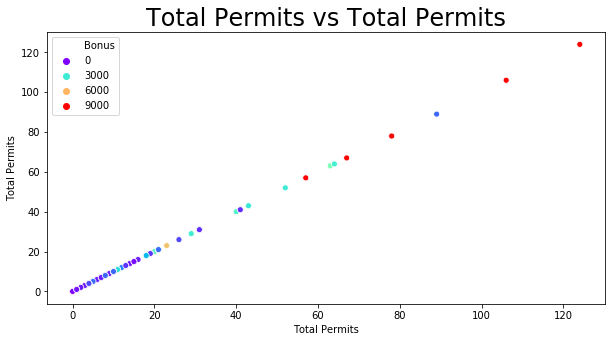

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total Permits vs Total Wells')

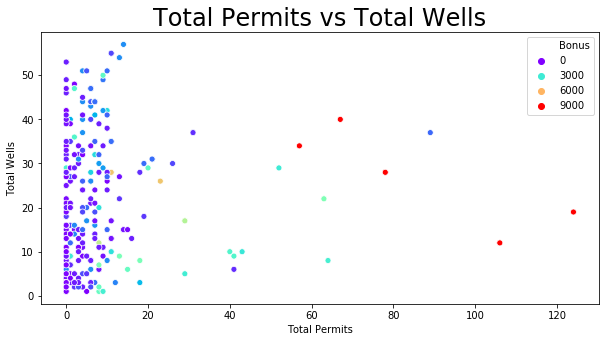

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total Permits vs Avg First 6 Mo Oil')

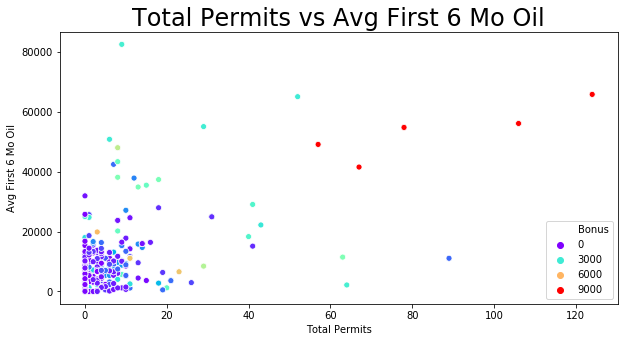

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total Permits vs Avg First 6 Mo Gas')

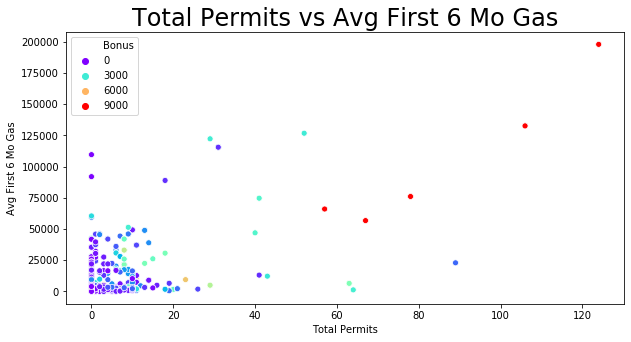

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total Permits vs Qi Oil')

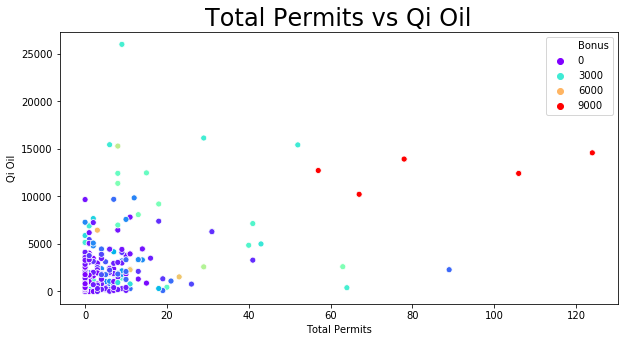

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total Permits vs Qi Gas')

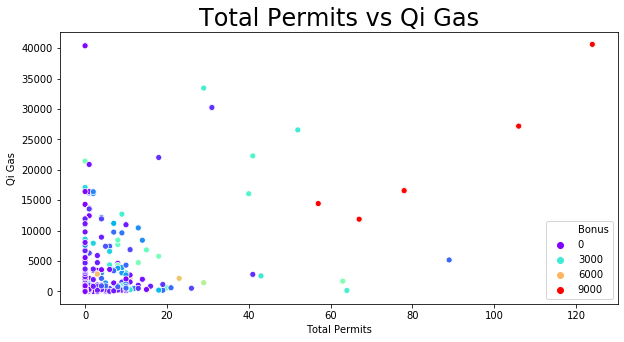

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total Permits vs 6 Mo Oil Revenue $')

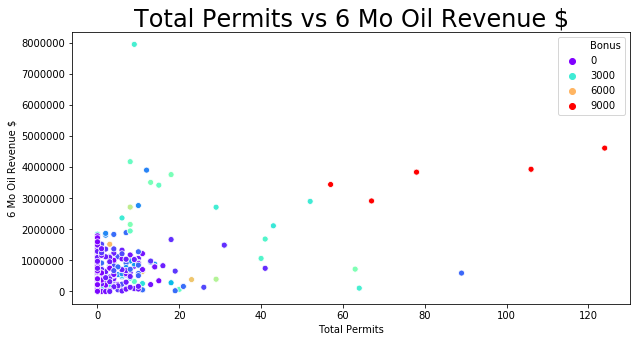

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total Permits vs 6 Mo Gas Rev $')

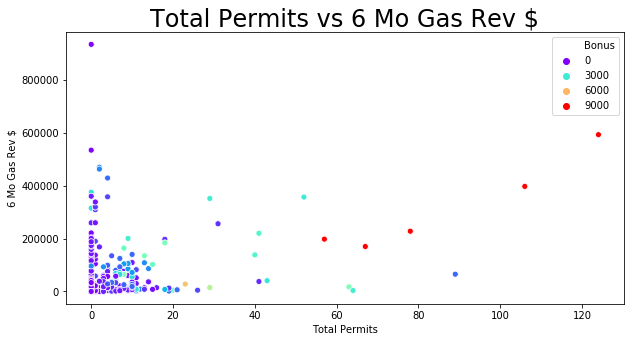

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total Permits vs Oil Price')

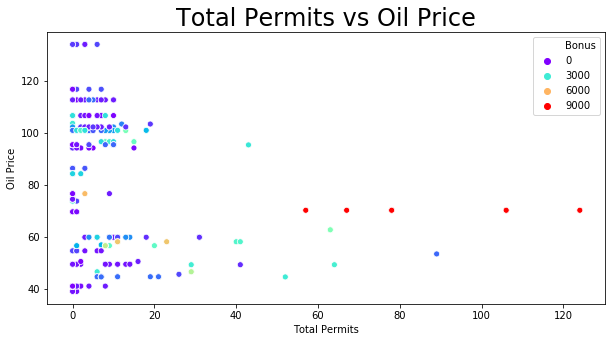

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total Permits vs Gas Price')

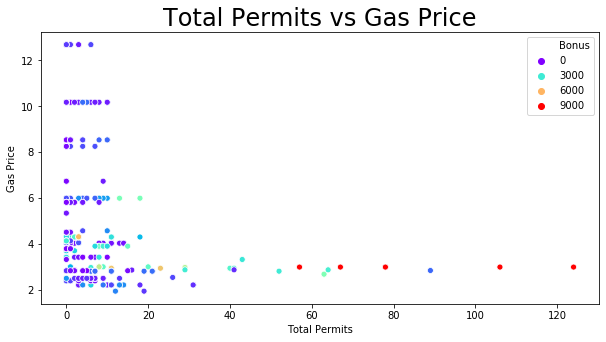

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total Wells vs Bonus')

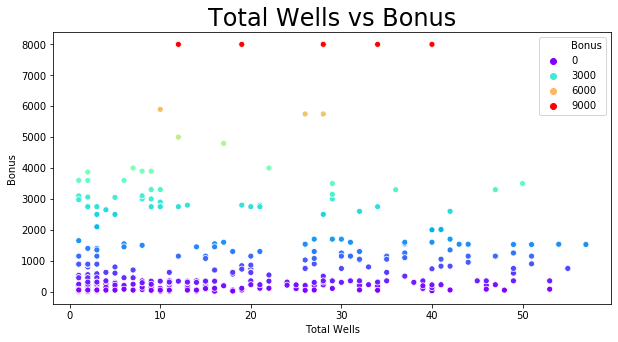

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total Wells vs Total Permits')

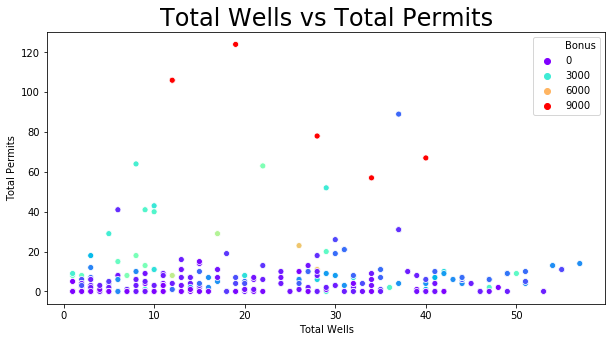

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total Wells vs Total Wells')

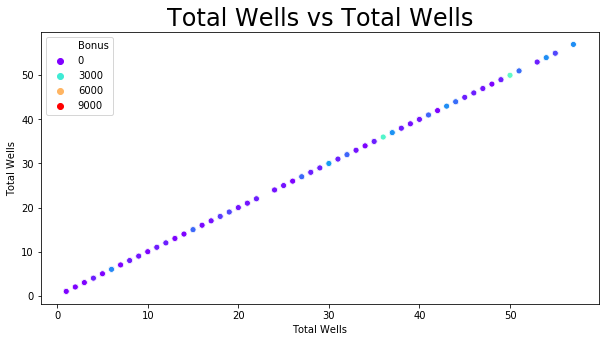

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total Wells vs Avg First 6 Mo Oil')

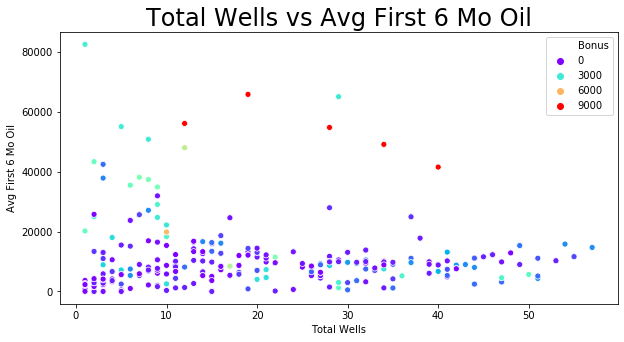

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total Wells vs Avg First 6 Mo Gas')

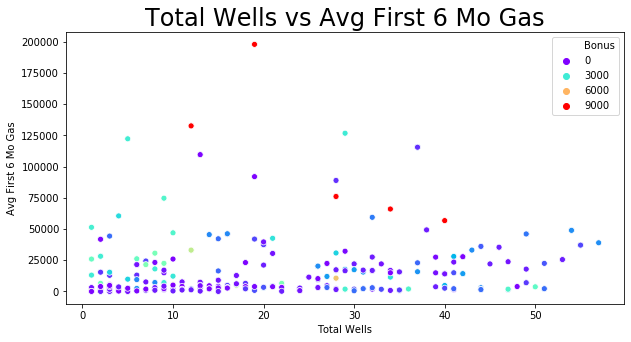

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total Wells vs Qi Oil')

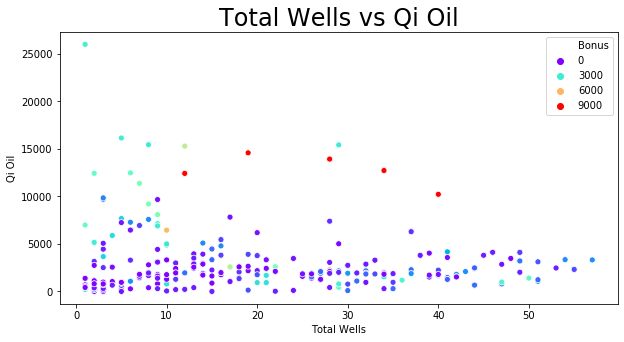

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total Wells vs Qi Gas')

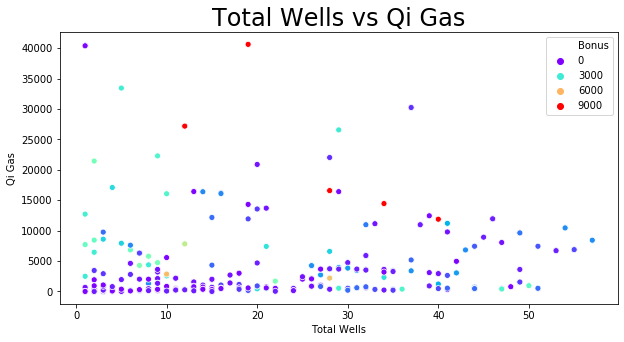

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total Wells vs 6 Mo Oil Revenue $')

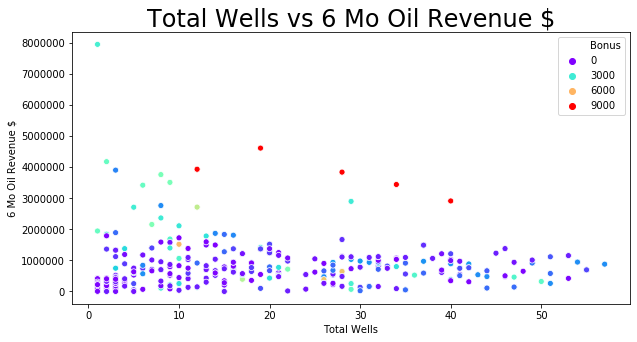

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total Wells vs 6 Mo Gas Rev $')

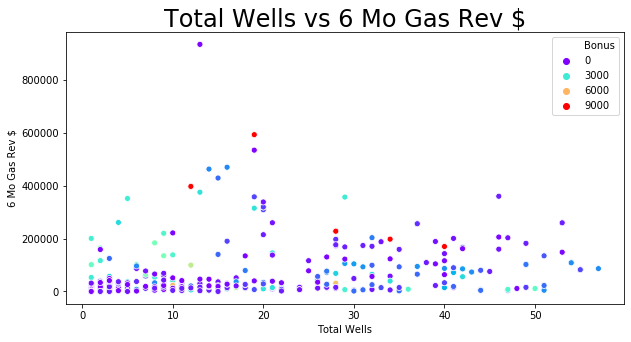

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total Wells vs Oil Price')

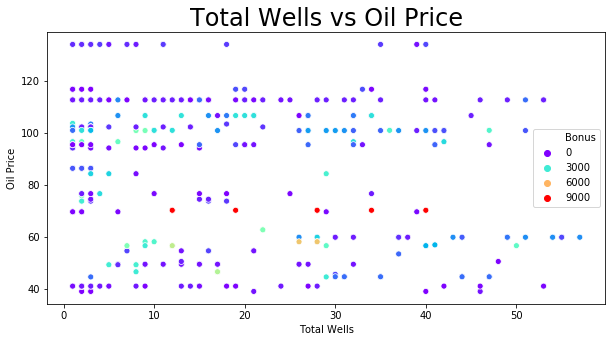

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total Wells vs Gas Price')

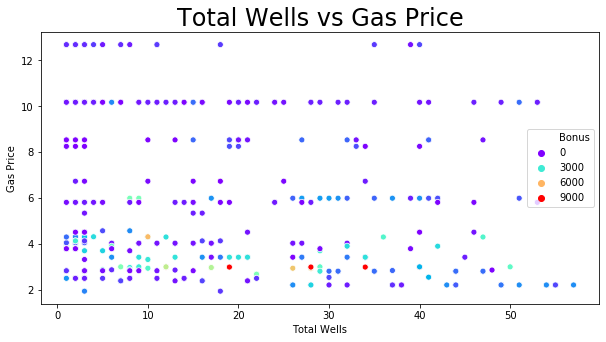

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Oil vs Bonus')

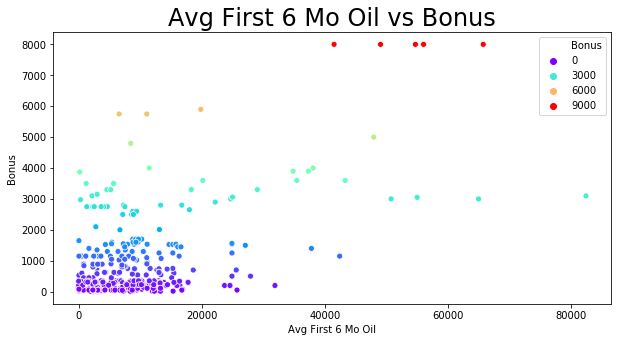

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Oil vs Total Permits')

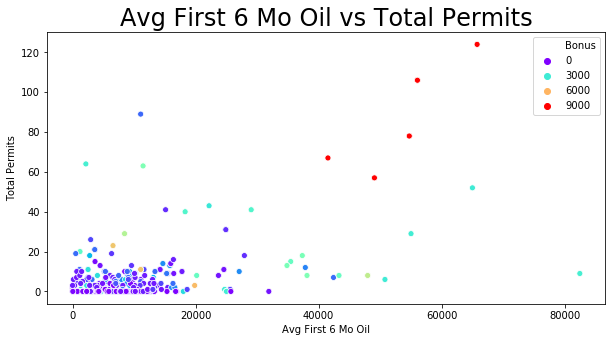

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Oil vs Total Wells')

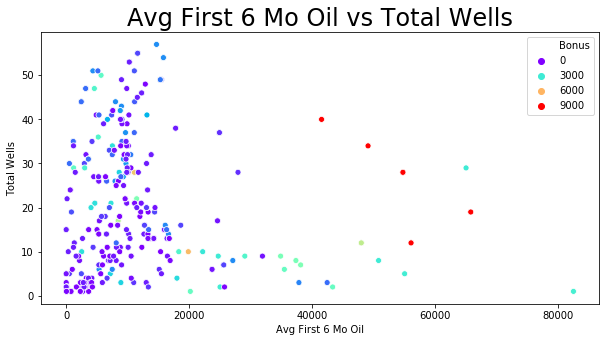

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Oil vs Avg First 6 Mo Oil')

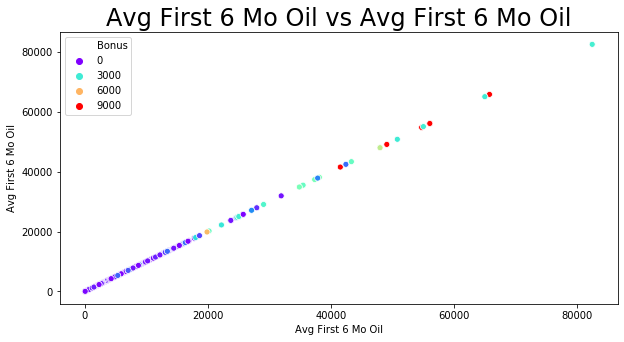

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Oil vs Avg First 6 Mo Gas')

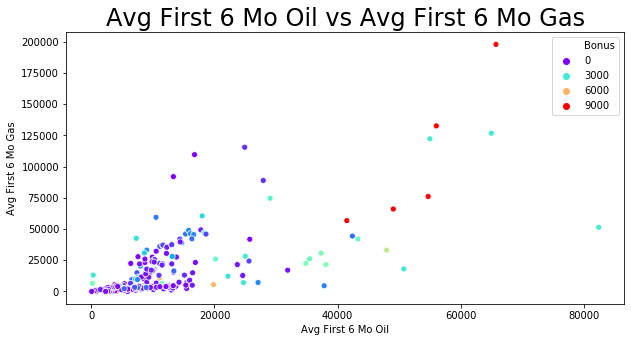

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Oil vs Qi Oil')

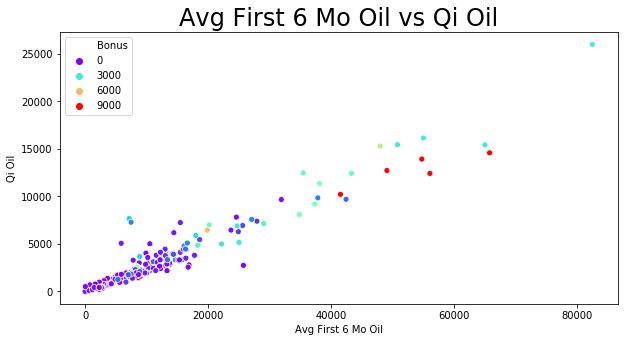

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Oil vs Qi Gas')

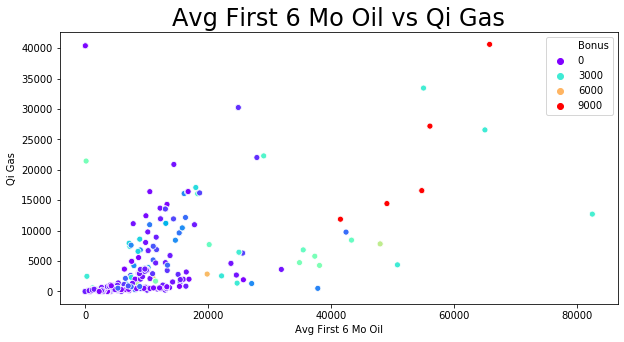

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Oil vs 6 Mo Oil Revenue $')

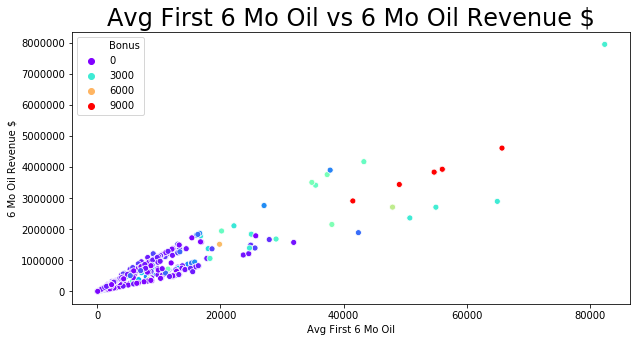

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Oil vs 6 Mo Gas Rev $')

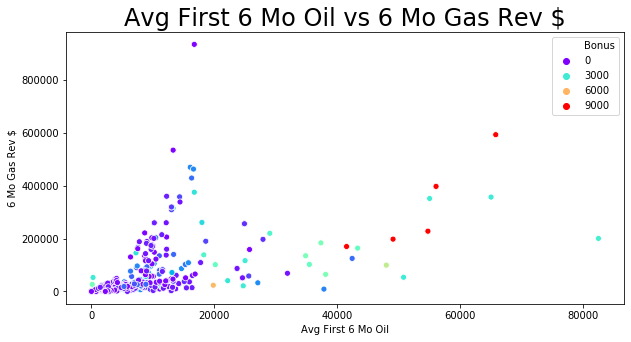

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Oil vs Oil Price')

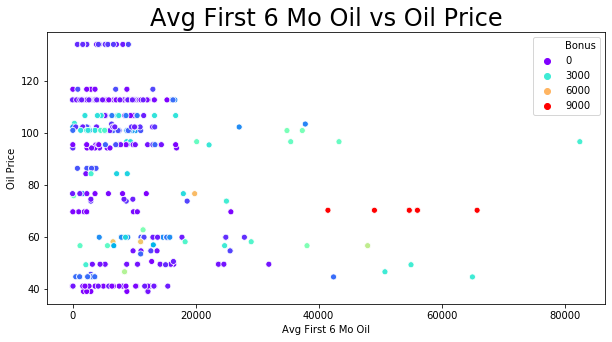

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Oil vs Gas Price')

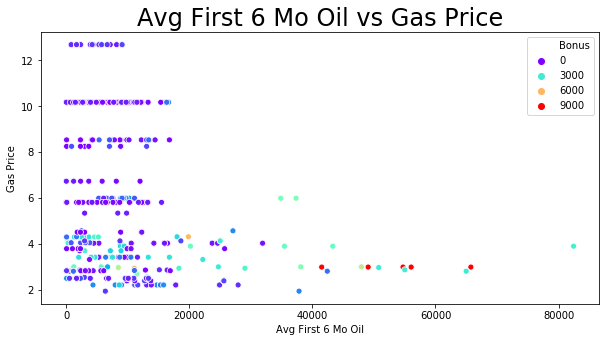

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Gas vs Bonus')

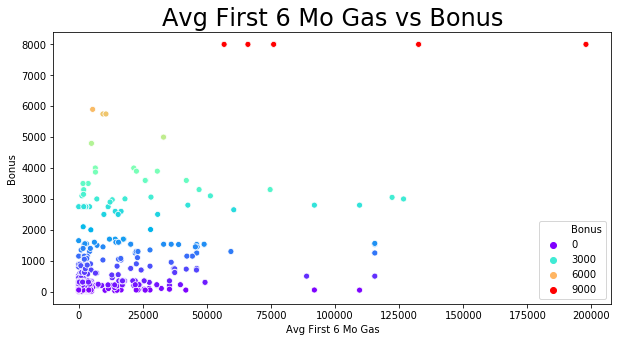

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Gas vs Total Permits')

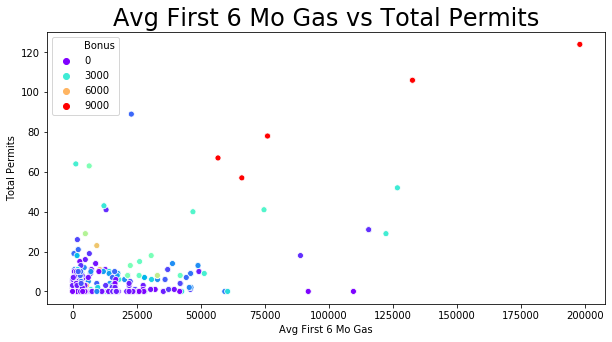

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Gas vs Total Wells')

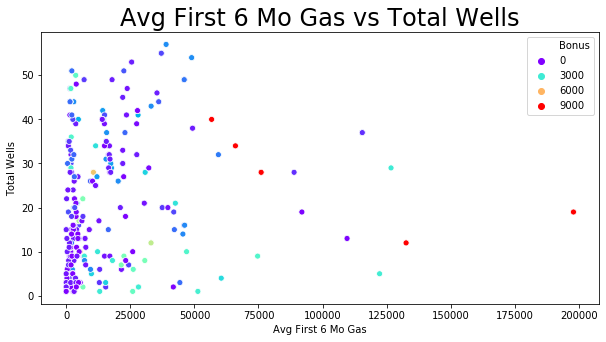

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Gas vs Avg First 6 Mo Oil')

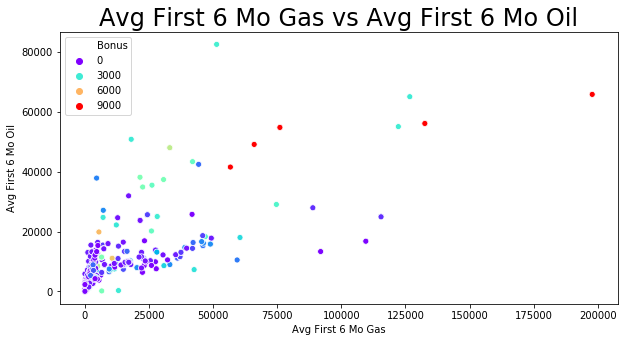

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Gas vs Avg First 6 Mo Gas')

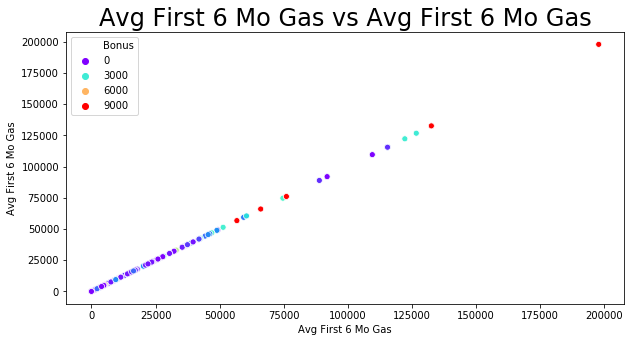

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Gas vs Qi Oil')

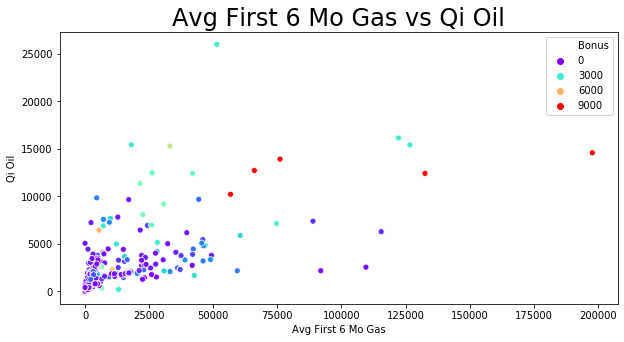

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Gas vs Qi Gas')

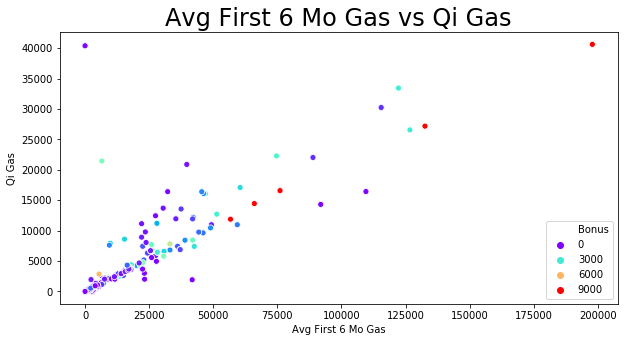

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Gas vs 6 Mo Oil Revenue $')

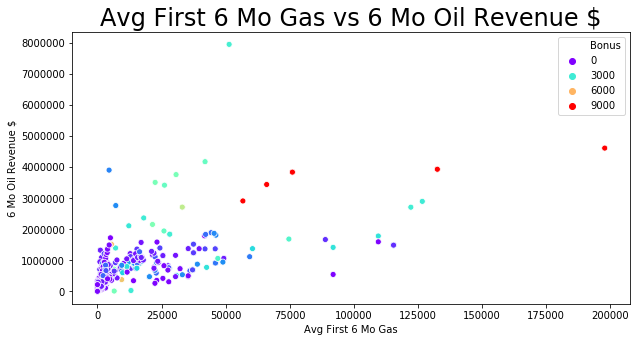

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Gas vs 6 Mo Gas Rev $')

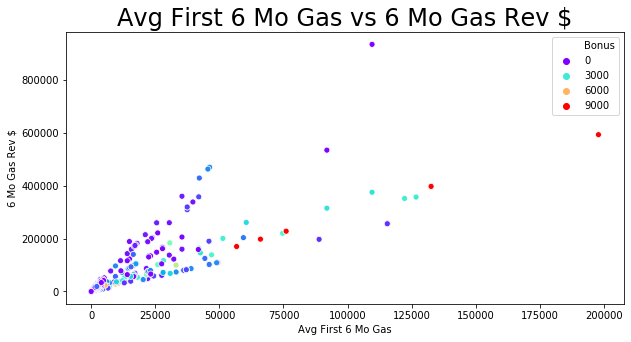

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Gas vs Oil Price')

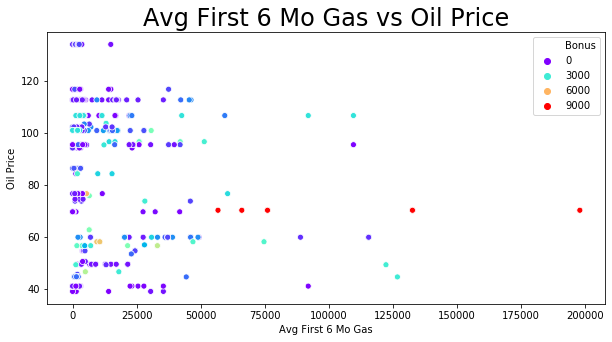

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Avg First 6 Mo Gas vs Gas Price')

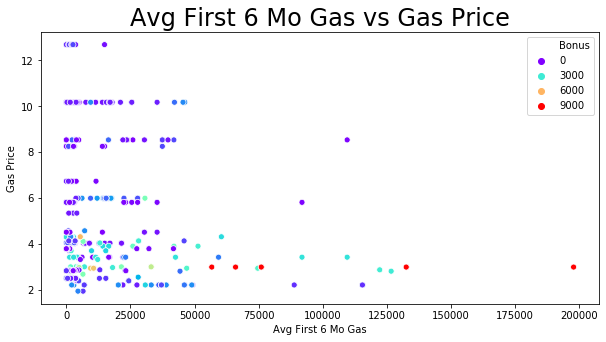

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Qi Oil vs Bonus')

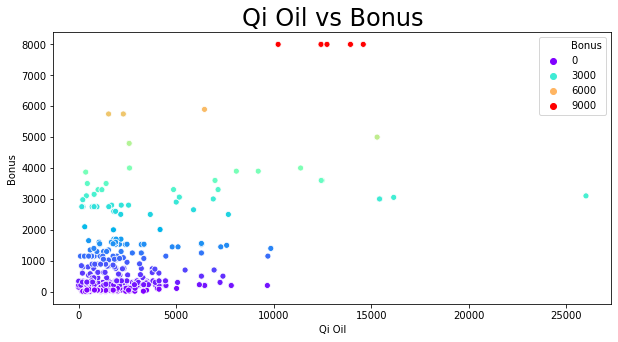

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Qi Oil vs Total Permits')

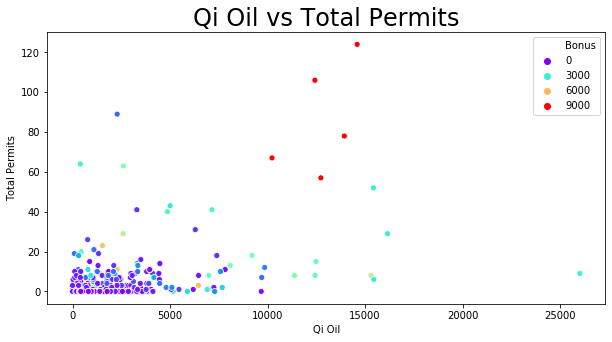

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Qi Oil vs Total Wells')

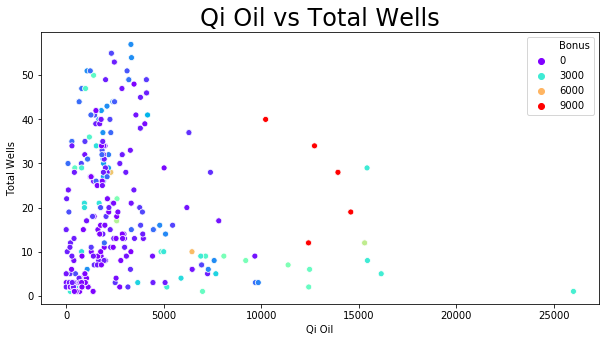

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Qi Oil vs Avg First 6 Mo Oil')

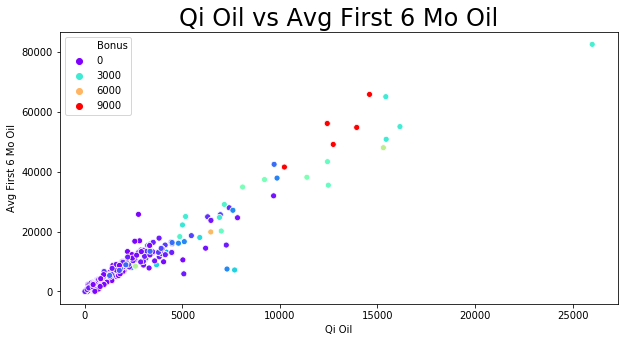

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Qi Oil vs Avg First 6 Mo Gas')

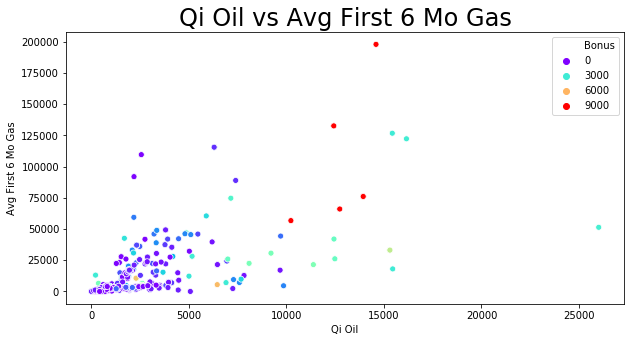

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Qi Oil vs Qi Oil')

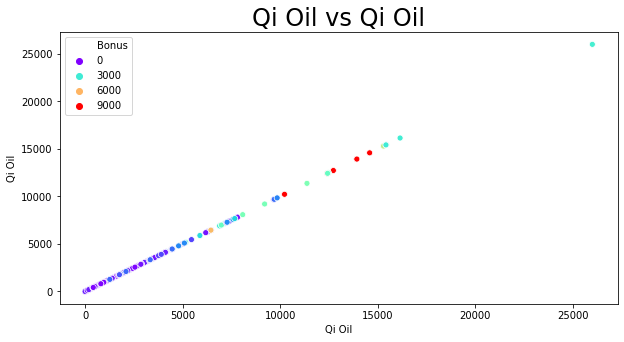

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Qi Oil vs Qi Gas')

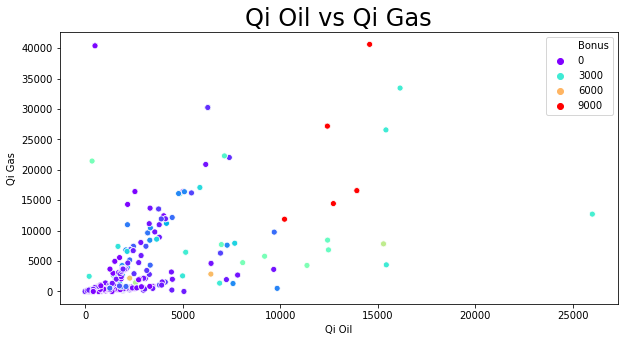

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Qi Oil vs 6 Mo Oil Revenue $')

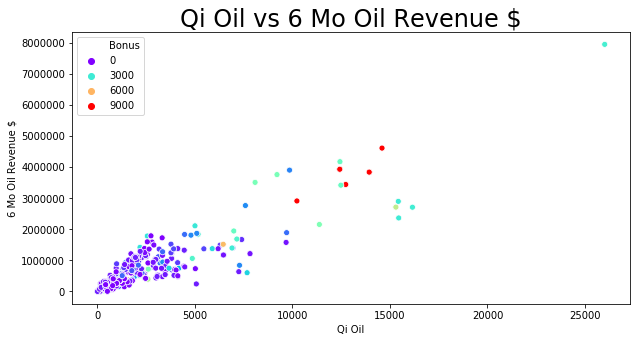

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Qi Oil vs 6 Mo Gas Rev $')

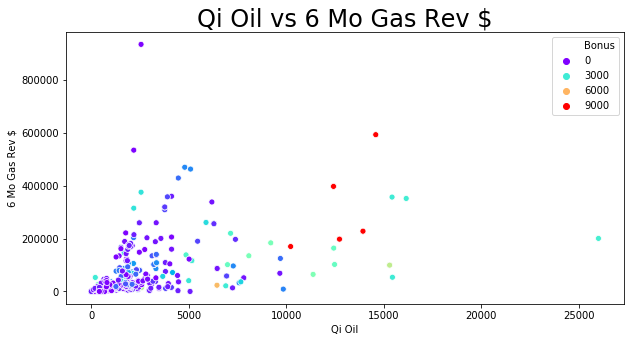

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Qi Oil vs Oil Price')

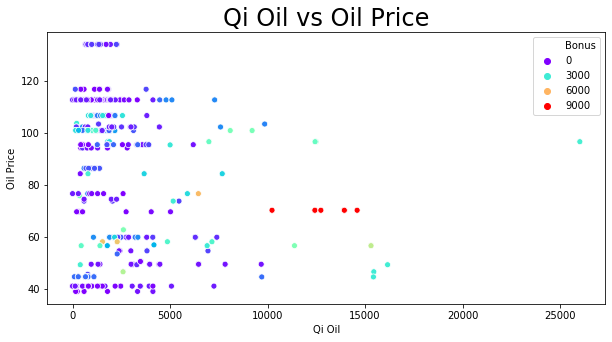

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Qi Oil vs Gas Price')

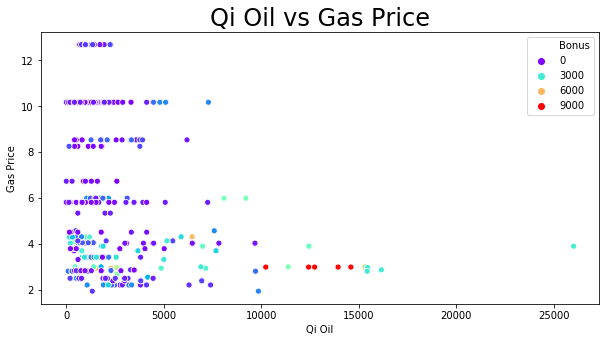

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Qi Gas vs Bonus')

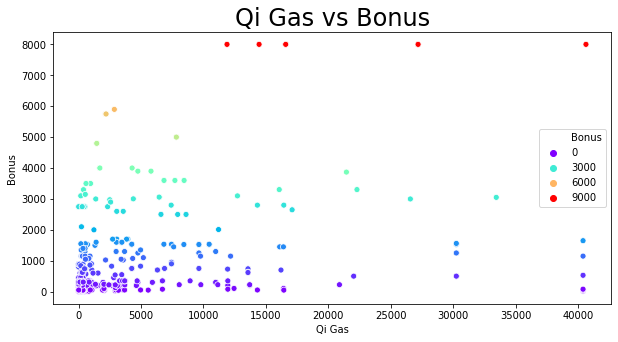

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Qi Gas vs Total Permits')

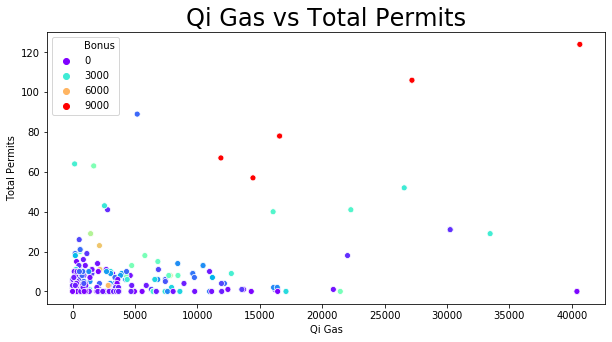

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Qi Gas vs Total Wells')

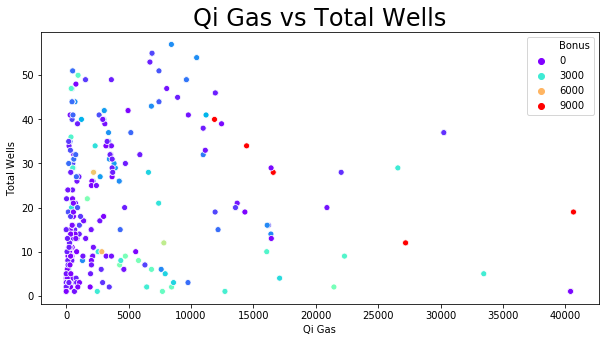

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Qi Gas vs Avg First 6 Mo Oil')

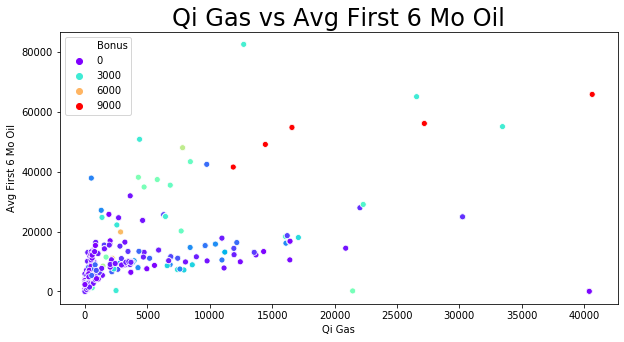

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Qi Gas vs Avg First 6 Mo Gas')

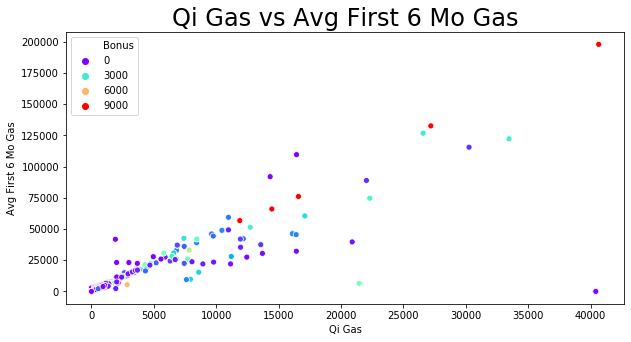

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Qi Gas vs Qi Oil')

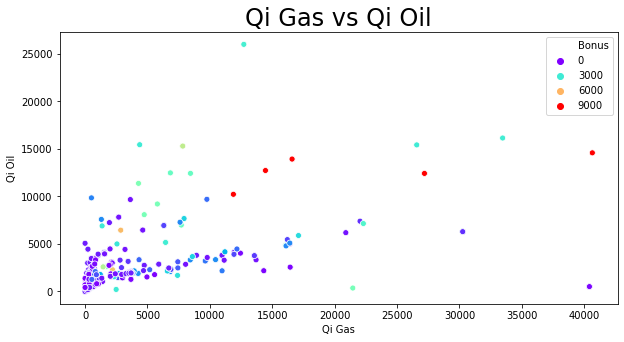

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Qi Gas vs Qi Gas')

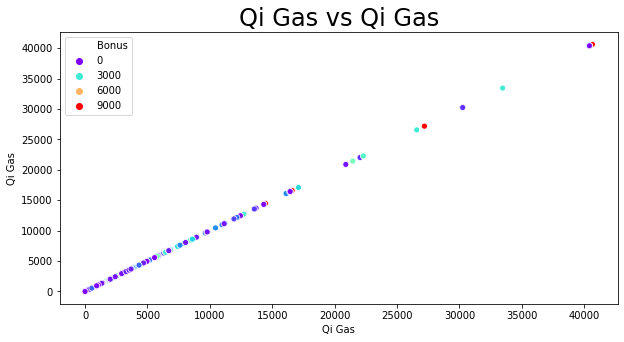

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Qi Gas vs 6 Mo Oil Revenue $')

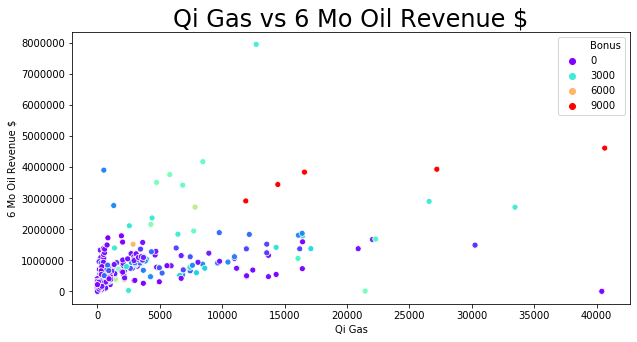

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Qi Gas vs 6 Mo Gas Rev $')

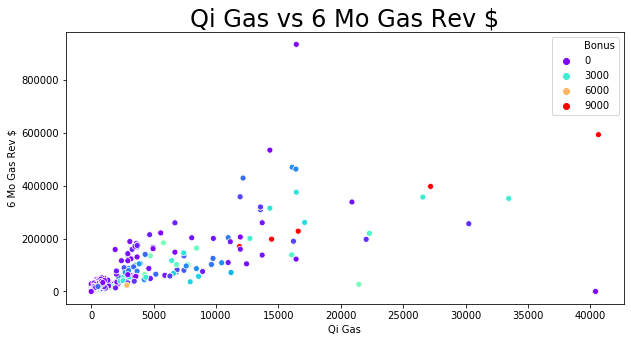

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Qi Gas vs Oil Price')

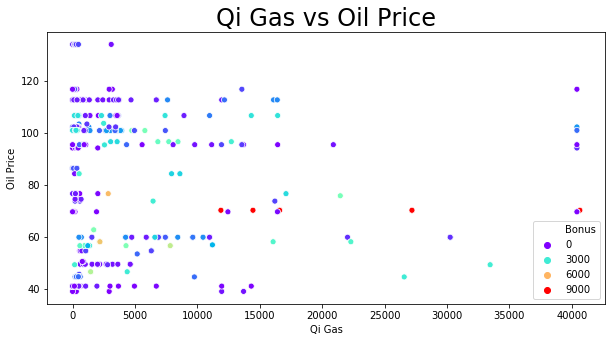

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Qi Gas vs Gas Price')

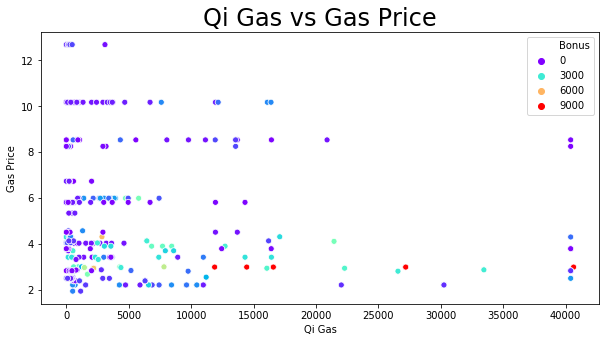

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, '6 Mo Oil Revenue $ vs Bonus')

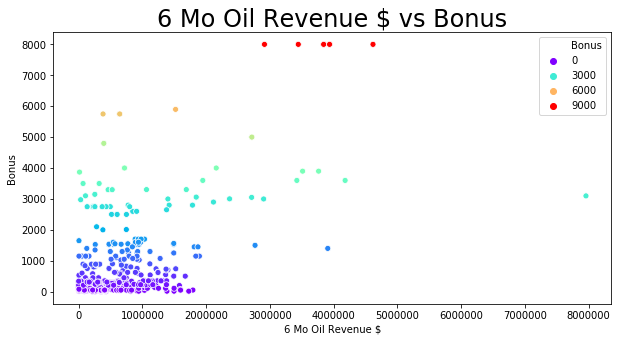

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, '6 Mo Oil Revenue $ vs Total Permits')

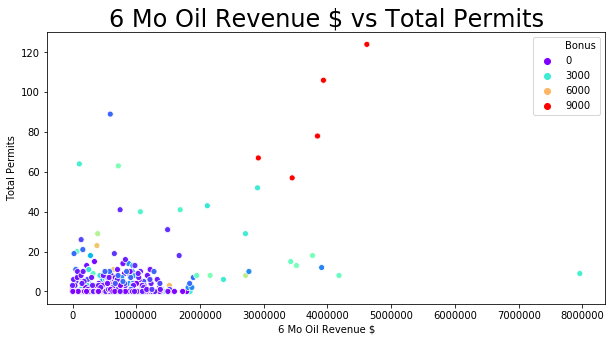

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, '6 Mo Oil Revenue $ vs Total Wells')

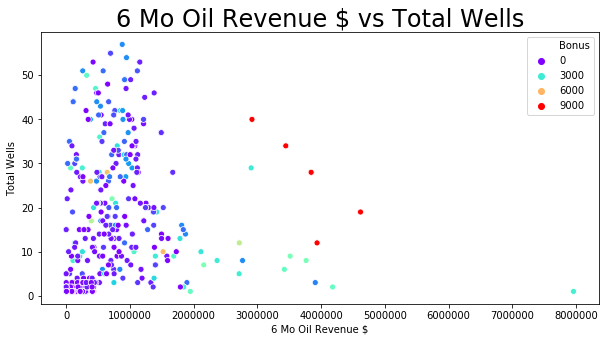

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, '6 Mo Oil Revenue $ vs Avg First 6 Mo Oil')

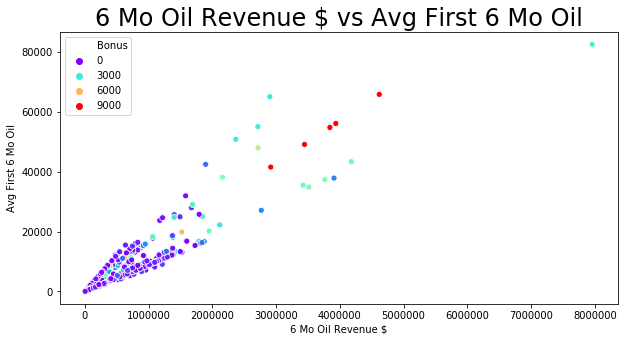

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, '6 Mo Oil Revenue $ vs Avg First 6 Mo Gas')

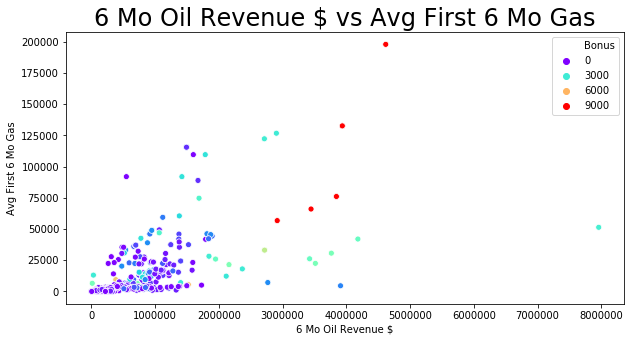

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, '6 Mo Oil Revenue $ vs Qi Oil')

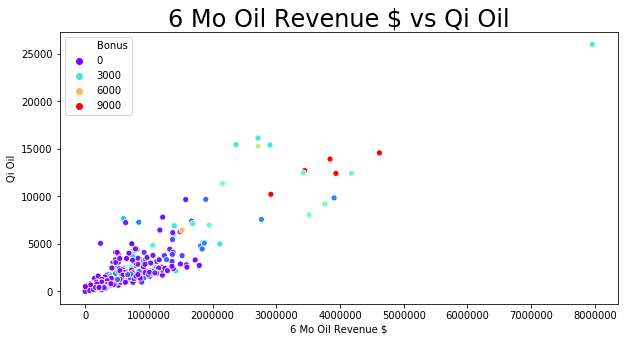

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, '6 Mo Oil Revenue $ vs Qi Gas')

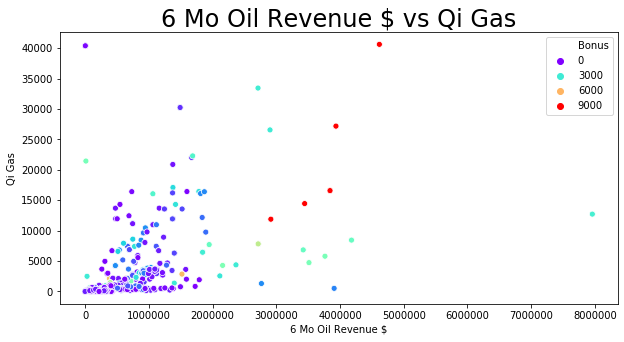

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, '6 Mo Oil Revenue $ vs 6 Mo Oil Revenue $')

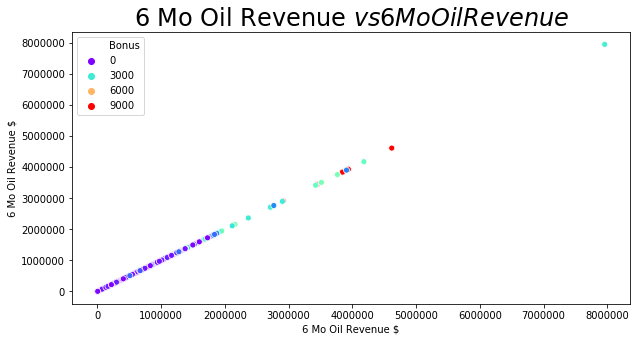

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, '6 Mo Oil Revenue $ vs 6 Mo Gas Rev $')

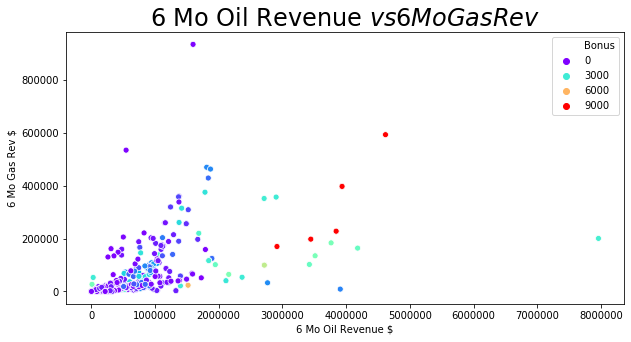

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, '6 Mo Oil Revenue $ vs Oil Price')

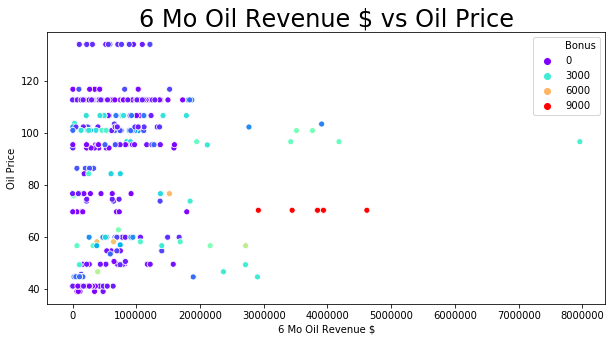

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, '6 Mo Oil Revenue $ vs Gas Price')

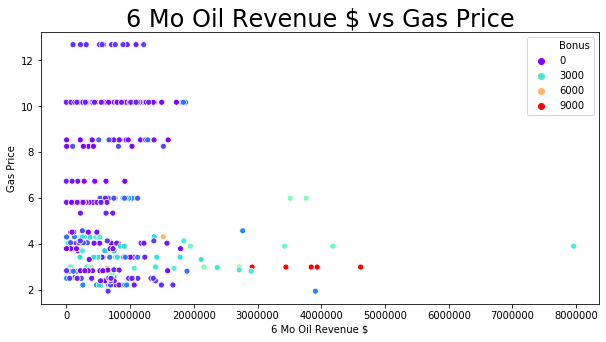

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, '6 Mo Gas Rev $ vs Bonus')

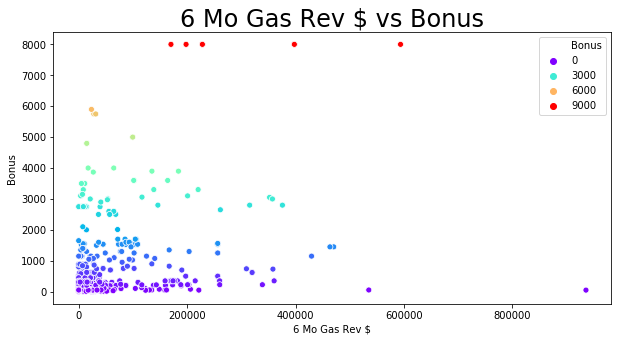

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, '6 Mo Gas Rev $ vs Total Permits')

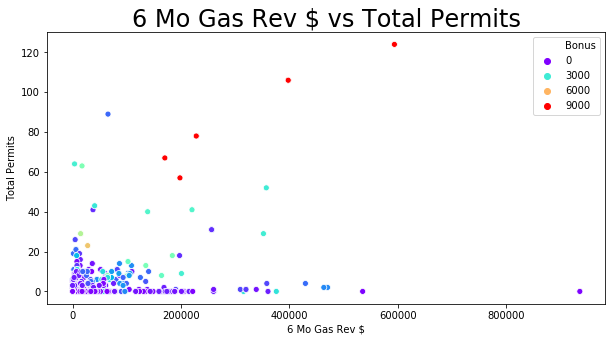

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, '6 Mo Gas Rev $ vs Total Wells')

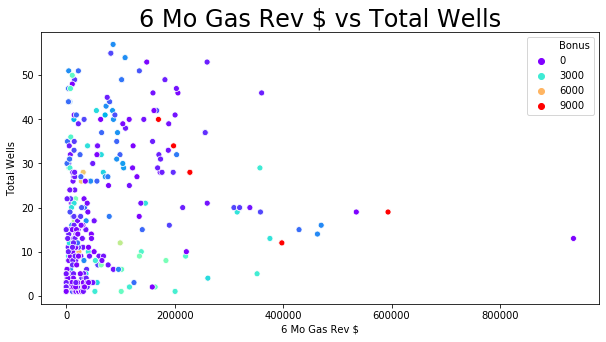

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, '6 Mo Gas Rev $ vs Avg First 6 Mo Oil')

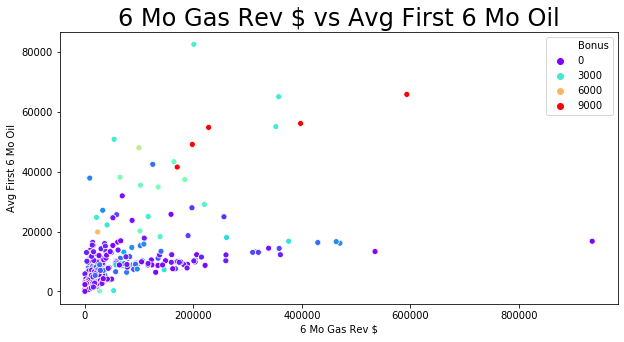

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, '6 Mo Gas Rev $ vs Avg First 6 Mo Gas')

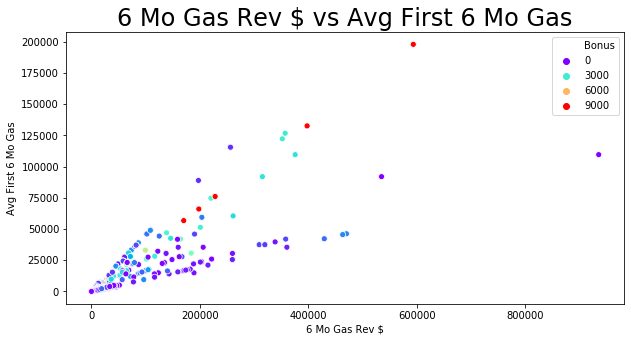

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, '6 Mo Gas Rev $ vs Qi Oil')

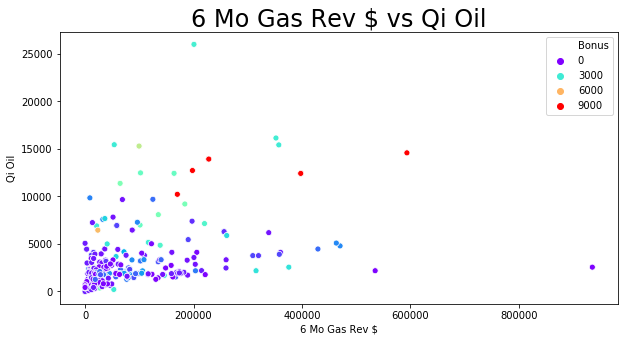

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, '6 Mo Gas Rev $ vs Qi Gas')

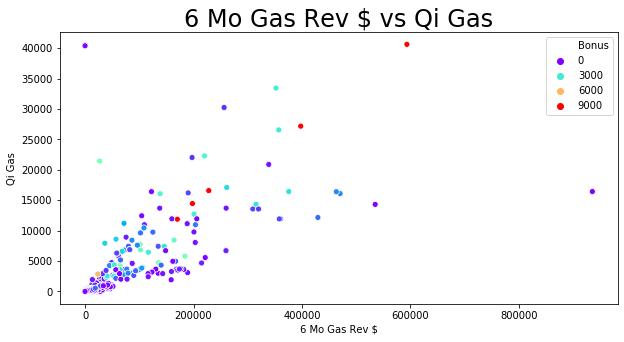

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, '6 Mo Gas Rev $ vs 6 Mo Oil Revenue $')

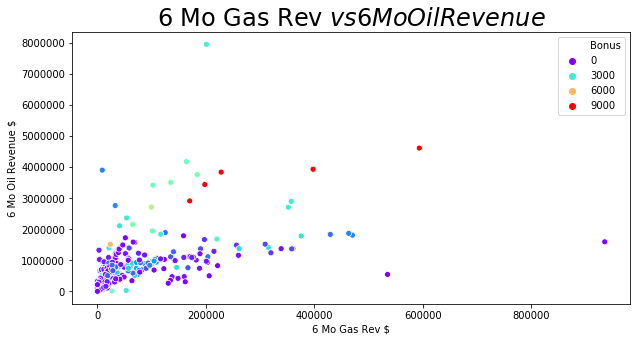

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, '6 Mo Gas Rev $ vs 6 Mo Gas Rev $')

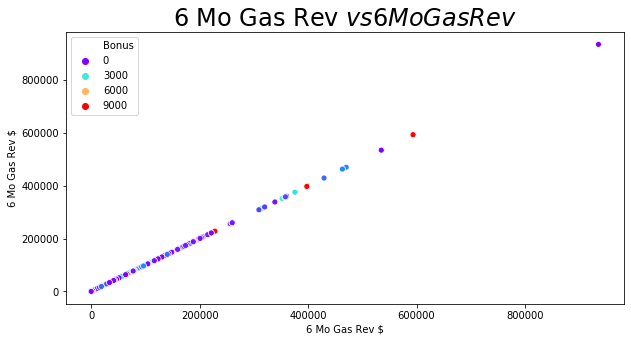

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, '6 Mo Gas Rev $ vs Oil Price')

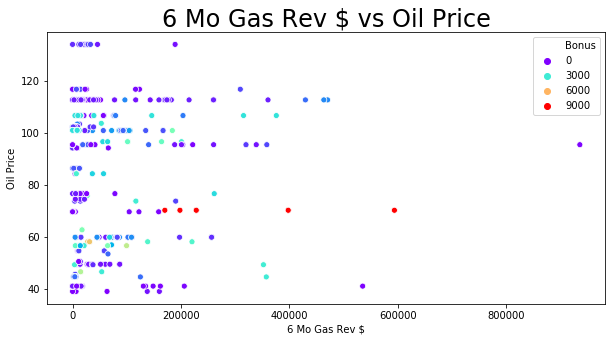

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, '6 Mo Gas Rev $ vs Gas Price')

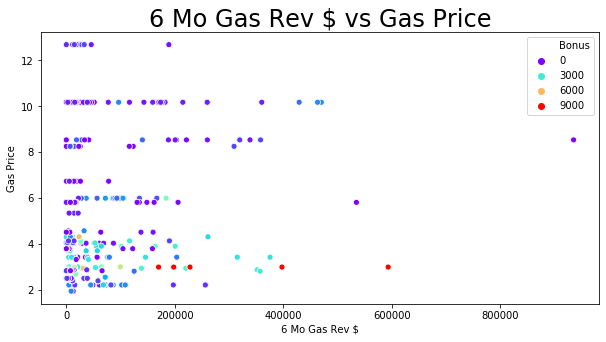

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Oil Price vs Bonus')

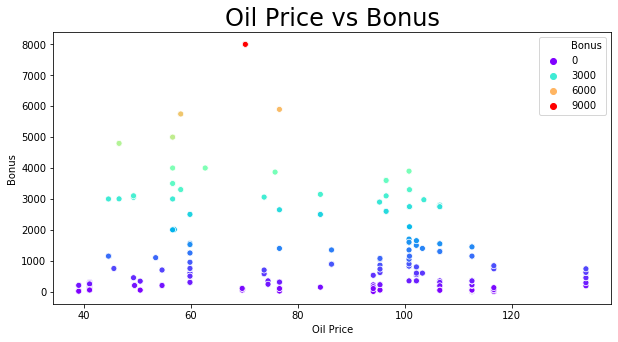

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Oil Price vs Total Permits')

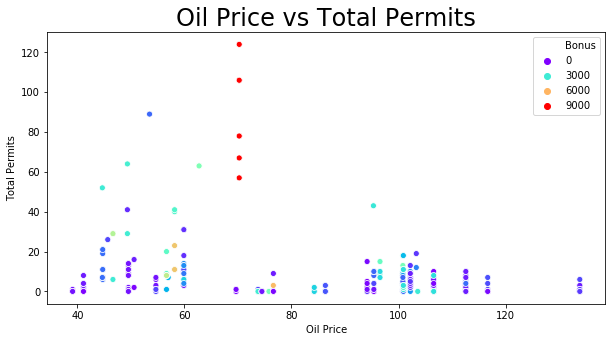

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Oil Price vs Total Wells')

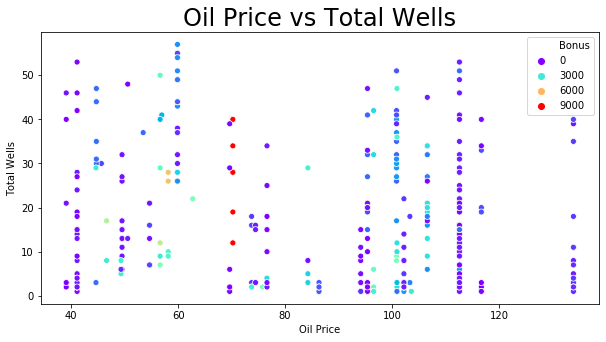

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Oil Price vs Avg First 6 Mo Oil')

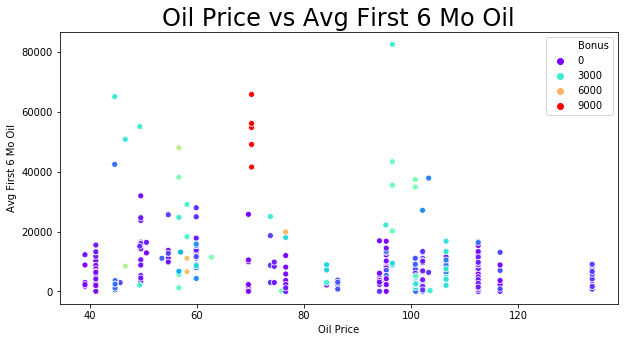

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Oil Price vs Avg First 6 Mo Gas')

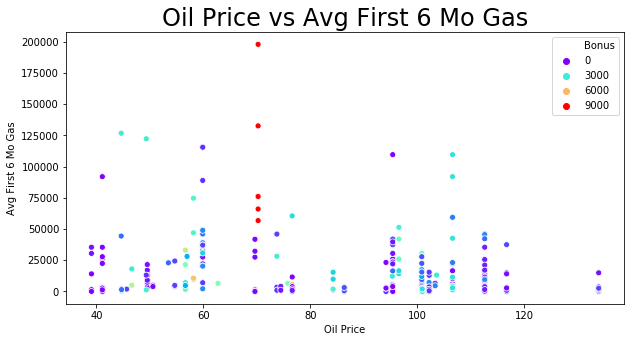

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Oil Price vs Qi Oil')

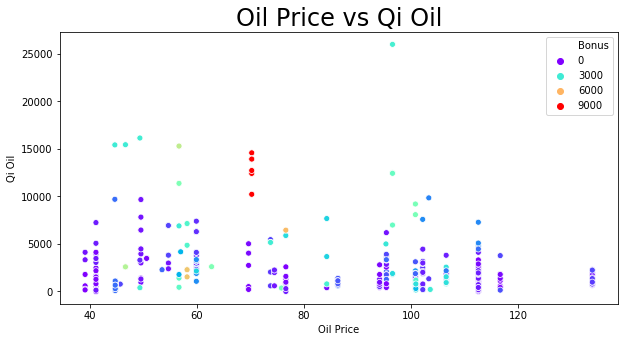

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Oil Price vs Qi Gas')

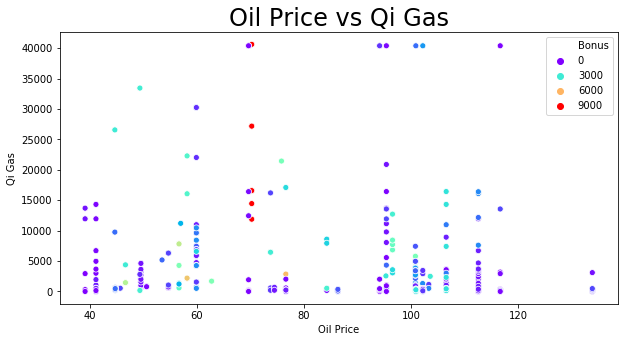

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Oil Price vs 6 Mo Oil Revenue $')

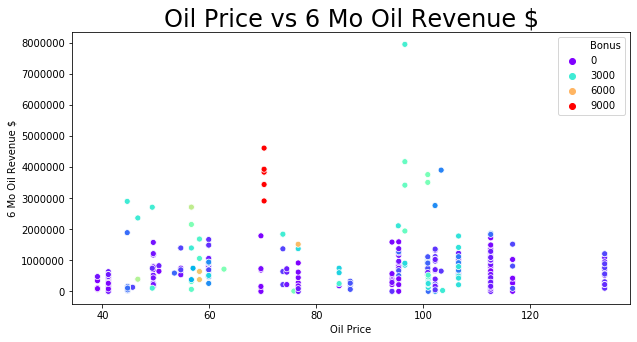

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Oil Price vs 6 Mo Gas Rev $')

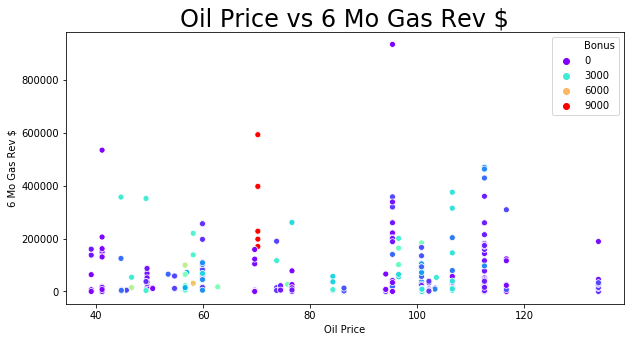

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Oil Price vs Oil Price')

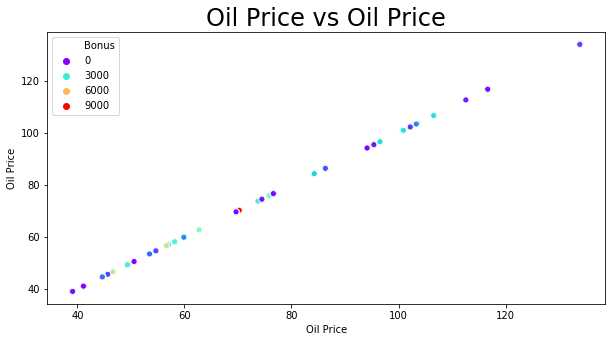

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Oil Price vs Gas Price')

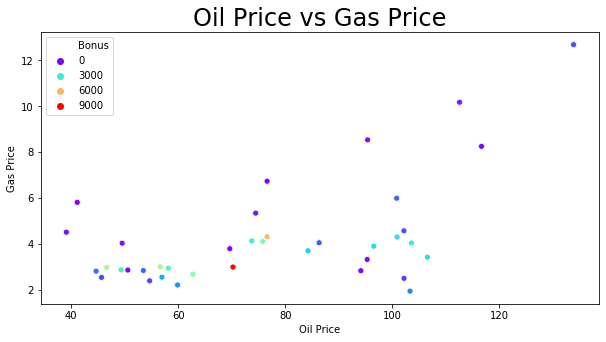

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Gas Price vs Bonus')

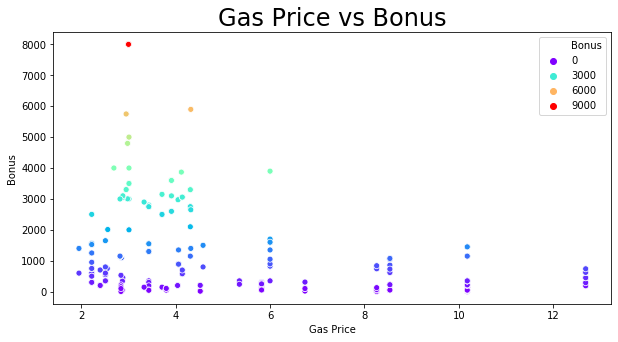

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Gas Price vs Total Permits')

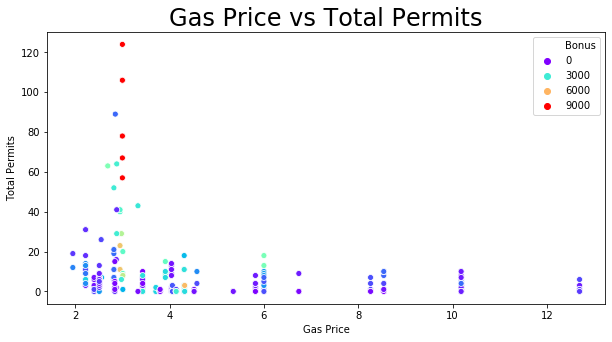

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Gas Price vs Total Wells')

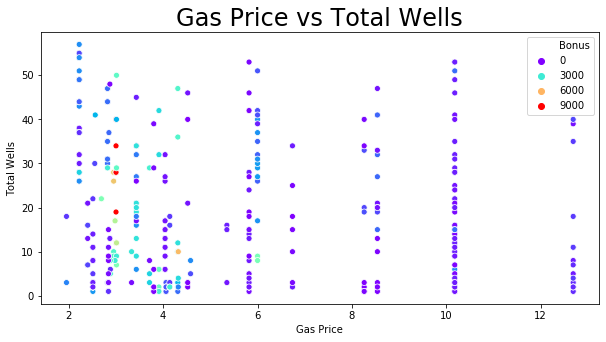

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Gas Price vs Avg First 6 Mo Oil')

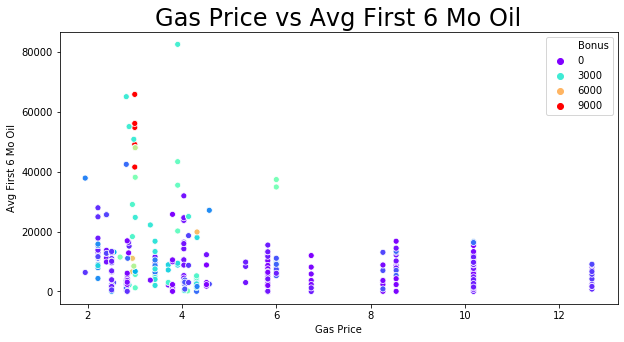

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Gas Price vs Avg First 6 Mo Gas')

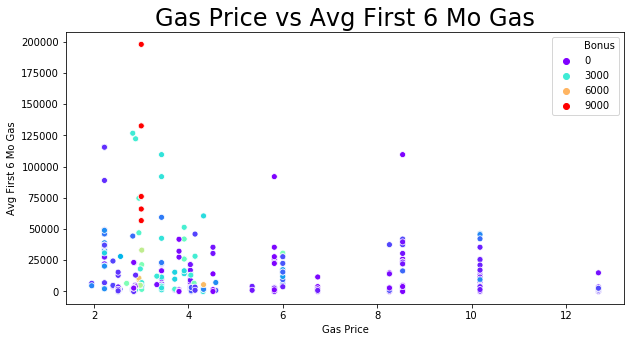

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Gas Price vs Qi Oil')

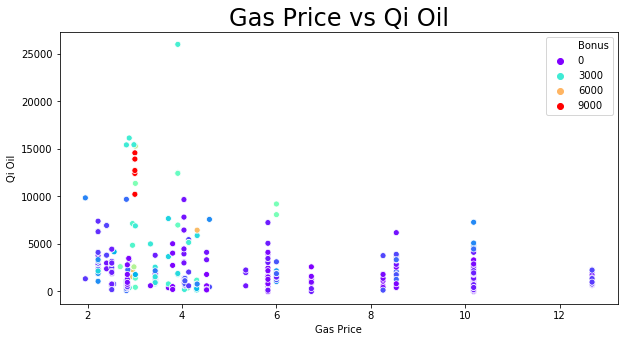

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Gas Price vs Qi Gas')

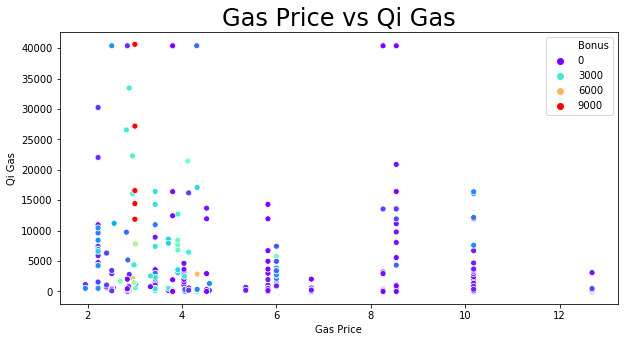

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Gas Price vs 6 Mo Oil Revenue $')

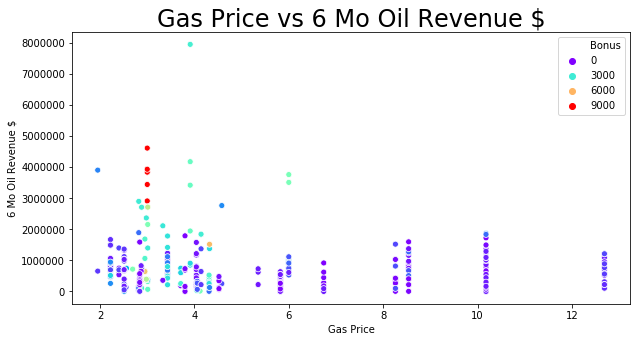

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Gas Price vs 6 Mo Gas Rev $')

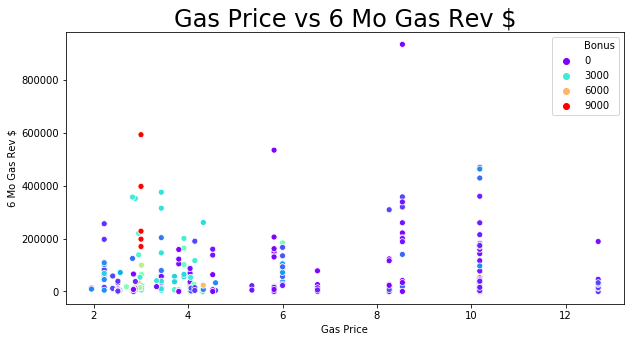

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Gas Price vs Oil Price')

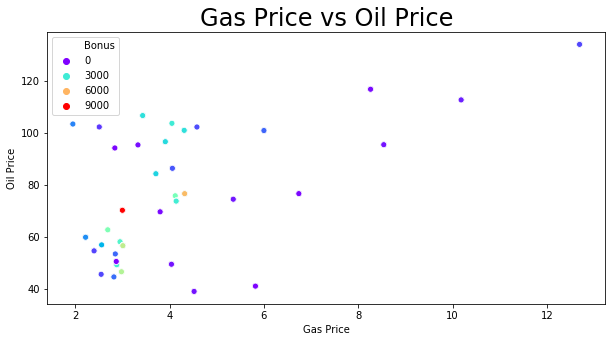

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Gas Price vs Gas Price')

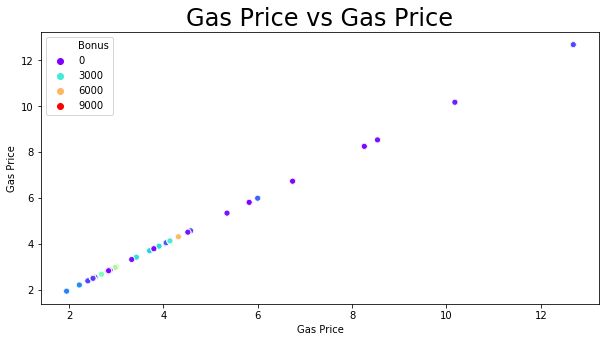

In [68]:
for xcol in MLPredandResponseCols:
    for ycol in MLPredandResponseCols:
        plt.figure(figsize=(10,5))
        sns.scatterplot(cleanedLeases[MLPredandResponseCols][xcol],cleanedLeases[MLPredandResponseCols][ycol], palette="rainbow", hue = cleanedLeases["Bonus"])
        plt.title(xcol + " vs " + ycol, size = 24)
        
        plt.show()

### Writing Cleaned Data Set to File

In [69]:
#writing cleaned Training Leases to file
cleanedLeases.to_excel("Output Data/Training Leases Activity Data/Cleaned Training Leases.xlsx")

# Testing a model with Sklearn

### Reading in Cleaned Data


In [70]:
from sklearn.preprocessing import StandardScaler

In [71]:
#reading in cleaned leases from file for easy retrieval
cleanedLeases = pd.read_excel("Output Data/Training Leases Activity Data/Cleaned Training Leases.xlsx")

In [72]:
#resetting index to original index prior to exporting to file
cleanedLeases.head()
cleanedLeases.set_index("LeaseIndex", inplace = True)

cleanedLeases.head()

LeaseIndex Record Date Record Number  Bonus  Section  Township  Range  \
0          57  2019-12-11     WYW189586   1527        3        39     73   
1          58  2019-12-11     WYW189586   1527        9        39     73   
2          59  2019-12-11     WYW189590    302       27        39     73   
3          60  2019-12-11     WYW189596   1535       32        40     73   
4          61  2019-12-11     WYW189593    752       28        40     73   

                                      geometry  \
0  POINT (450547.6131938574 4803344.147960225)   
1  POINT (448886.0374564391 4801760.549607107)   
2    POINT (450464.34694615 4796947.371161564)   
3  POINT (447329.5662888384 4804957.255790628)   
4   POINT (448968.4909649936 4806538.52595432)   

                                             buffers  Total Permits  \
0  POLYGON ((455375.6331938574 4803344.147960225,...              9   
1  POLYGON ((453714.0574564391 4801760.549607107,...             14   
2  POLYGON ((455292.36694615 4796947.371161564, 4...             10   
3  POLYGON ((452157.5862888384 4804957.255790628,...              6   
4  POLYGON ((453796.5109649936 4806538.52595432, ...              6   

   Total Wells  Avg First 6 Mo Oil  Avg First 6 Mo Gas       Qi Oil  \
0           49        15299.416667        46031.020833  3210.612245   
1           57        14679.767857        38966.214286  3319.473684   
2           38        17782.297297        49281.540541  3801.315789   
3           43         8980.725000        33128.175000  2092.325581   
4           26         7941.240000        20281.240000  1899.230769   

         Qi Gas  6 Mo Oil Revenue $  6 Mo Gas Rev $  Oil Price  Gas Price  \
0   9631.836735        9.161291e+05   102188.866250      59.88       2.22   
1   8427.894737        8.790245e+05    86504.995714      59.88       2.22   
2  10975.263158        1.064804e+06   109405.020000      59.88       2.22   
3   6826.046512        5.377658e+05    73544.548500      59.88       2.22   
4   4250.769231        4.755215e+05    45024.352800      59.88       2.22   

   TWSHP  Record Year  Log Bonus  
0  39 73         2019   7.331060  
1  39 73         2019   7.331060  
2  39 73         2019   5.710427  
3  40 73         2019   7.336286  
4  40 73         2019   6.622736

Record Date Record Number  Bonus  Section  Township  Range  \
LeaseIndex                                                              
57          2019-12-11     WYW189586   1527        3        39     73   
58          2019-12-11     WYW189586   1527        9        39     73   
59          2019-12-11     WYW189590    302       27        39     73   
60          2019-12-11     WYW189596   1535       32        40     73   
61          2019-12-11     WYW189593    752       28        40     73   

                                               geometry  \
LeaseIndex                                                
57          POINT (450547.6131938574 4803344.147960225)   
58          POINT (448886.0374564391 4801760.549607107)   
59            POINT (450464.34694615 4796947.371161564)   
60          POINT (447329.5662888384 4804957.255790628)   
61           POINT (448968.4909649936 4806538.52595432)   

                                                      buffers  Total Permits  \
LeaseIndex                                                                     
57          POLYGON ((455375.6331938574 4803344.147960225,...              9   
58          POLYGON ((453714.0574564391 4801760.549607107,...             14   
59          POLYGON ((455292.36694615 4796947.371161564, 4...             10   
60          POLYGON ((452157.5862888384 4804957.255790628,...              6   
61          POLYGON ((453796.5109649936 4806538.52595432, ...              6   

            Total Wells  Avg First 6 Mo Oil  Avg First 6 Mo Gas       Qi Oil  \
LeaseIndex                                                                     
57                   49        15299.416667        46031.020833  3210.612245   
58                   57        14679.767857        38966.214286  3319.473684   
59                   38        17782.297297        49281.540541  3801.315789   
60                   43         8980.725000        33128.175000  2092.325581   
61                   26         7941.240000        20281.240000  1899.230769   

                  Qi Gas  6 Mo Oil Revenue $  6 Mo Gas Rev $  Oil Price  \
LeaseIndex                                                                
57           9631.836735        9.161291e+05   102188.866250      59.88   
58           8427.894737        8.790245e+05    86504.995714      59.88   
59          10975.263158        1.064804e+06   109405.020000      59.88   
60           6826.046512        5.377658e+05    73544.548500      59.88   
61           4250.769231        4.755215e+05    45024.352800      59.88   

            Gas Price  TWSHP  Record Year  Log Bonus  
LeaseIndex                                            
57               2.22  39 73         2019   7.331060  
58               2.22  39 73         2019   7.331060  
59               2.22  39 73         2019   5.710427  
60               2.22  40 73         2019   7.336286  
61               2.22  40 73         2019   6.622736

### Standardizing/Scaling inputs

In [73]:
#setting columns of dataframe that will be features or independent variables
inputs = cleanedLeases[["Total Permits",'6 Mo Oil Revenue $',"Total Wells", '6 Mo Gas Rev $']]
target = cleanedLeases["Log Bonus"]

scaler = StandardScaler()
scaler.fit(inputs)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [74]:
inputs_scaled = scaler.transform(inputs)

### Variance inflation factor

In [75]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# To make this as easy as possible to use, we declare a variable where we put
# all features where we want to check for multicollinearity

#create a new data frame which will include all the VIFs
# note that each variable has its own variance inflation factor as this measure is variable specific (not model specific)
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(inputs.values, i) for i in range(inputs.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = inputs.columns

In [76]:
vif

VIF            Features
0  1.604676       Total Permits
1  2.629100  6 Mo Oil Revenue $
2  1.590175         Total Wells
3  2.217620      6 Mo Gas Rev $

### Splitting training and testing data - Fitting multilinear regression

In [77]:
# Import the module for the split
from sklearn.model_selection import train_test_split

# Split the variables with an 80-20 split and some random state
# To have the same split as mine, use random_state = 365
x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, target, test_size=0.15, random_state = 10)

In [78]:
#instantiating linear model
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Retrieving Predictions from X train features

In [79]:
#predicting bonuses based on training data
y_pred = reg.predict(x_train)

Text(0.5, 1.0, 'predicted bonus vs acutal bonus')

Text(0, 0.5, 'Prediced Log Bonus')

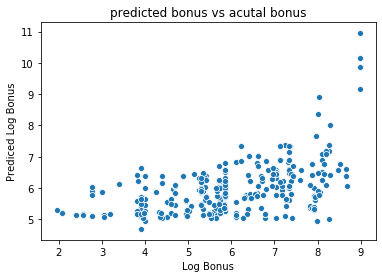

In [80]:
sns.scatterplot(y_train, y_pred)
plt.title("predicted bonus vs acutal bonus")
plt.ylabel("Prediced Log Bonus")


### Model Parameters

In [81]:
reg.coef_

inputs.columns

weights_Table = pd.DataFrame(data = reg.coef_, index = inputs.columns, columns = ["Weights"])

array([ 0.48504832,  0.39329113,  0.41489969, -0.15674212])

Index(['Total Permits', '6 Mo Oil Revenue $', 'Total Wells', '6 Mo Gas Rev $'], dtype='object')

In [82]:
weights_Table
print("Y intercept " + str(reg.intercept_))

Weights
Total Permits       0.485048
6 Mo Oil Revenue $  0.393291
Total Wells         0.414900
6 Mo Gas Rev $     -0.156742

Y intercept 5.961871600154061


### Model Results and Predictions

In [83]:
def modelPerformance(actual, predictions):
    mae = metrics.mean_absolute_error(actual,predictions)
    var = metrics.explained_variance_score(actual, predictions)
    r2 = metrics.r2_score(actual, predictions)
    
    print("Mean Absolute Error: {} \nVariance Explained: {} \nR2 Score: {}".format(mae,var,r2))

In [84]:
y_pred_Bonus = np.exp(y_pred)

In [85]:
from sklearn import metrics
results = pd.DataFrame()

results["Bonus"] = np.exp(y_train)

results["Predicted"] = y_pred_Bonus

results["Perc Error"] = ((results["Predicted"] - results["Bonus"])/results["Bonus"]) * 100

In [86]:
results["Perc Error"].apply(lambda x: abs(x)).mean()
results["Perc Error"].mean()

195.4978382371477

138.9664911195031

In [87]:
metrics.mean_absolute_error(y_pred_Bonus, np.exp(y_train))

886.5214100274991

In [88]:
results

Bonus     Predicted   Perc Error
LeaseIndex                                   
2505          55.0    589.983141   972.696620
2502        2750.0    321.279975   -88.317092
2704         350.0    371.920640     6.263040
3072          50.0    163.093619   226.187239
2356        1500.0    934.645823   -37.690278
2507        2800.0    278.794616   -90.043049
1858         451.0    920.832631   104.175750
3079         300.0    250.464652   -16.511783
3255          13.0    172.068883  1223.606789
3258          50.0    180.455393   260.910787
2899        2500.0    211.000348   -91.559986
412         3304.0   1190.724748   -63.961115
3237         140.0    175.725217    25.518012
94          1562.0   1542.612801    -1.241178
554          200.0    343.065133    71.532567
3142           8.0    187.169168  2239.614596
69          1526.0    679.228515   -55.489612
3096         300.0    406.165152    35.388384
3286         350.0    670.841528    91.669008
2026        1150.0    725.402347   -36.921535
3065          16.0    167.102957   944.393484
1688        4002.0    602.162641   -84.953457
3260          50.0    180.455393   260.910787
2028        1150.0    551.377246   -52.054152
3300         225.0    594.324167   164.144074
1807        4800.0    721.605468   -84.966553
2784         890.0    173.958257   -80.454128
915         8004.0  19119.768303   138.877665
3292        1050.0    614.236800   -41.501257
3089          90.0    158.551816    76.168685
...            ...           ...          ...
2626         530.0    151.961461   -71.328026
2624         110.0    423.345665   284.859695
3295          53.0    181.810302   243.038305
2718         800.0    213.276692   -73.340414
90          1536.0    423.209157   -72.447321
542          200.0    394.507632    97.253816
2283        3870.0    150.333216   -96.115421
3224         350.0    562.759742    60.788498
3204          50.0    286.557654   473.115308
380         5751.0    584.361651   -89.838956
3270         340.0    215.489067   -36.620863
2977        3060.0    319.747466   -89.550736
3217        1150.0    317.845641   -72.361249
73           302.0    520.066555    72.207469
3232         110.0    447.333576   306.666887
3296         630.0    290.729602   -53.852444
97          2502.0    438.940025   -82.456434
3064          21.0    159.488958   659.471228
572          200.0    364.481605    82.240802
65          1252.0    491.578228   -60.736563
3309          53.0    180.272928   240.137600
3288         350.0    499.257793    42.645084
2869        2750.0    222.099658   -91.923649
2497        2750.0    206.835605   -92.478705
2336        3600.0   1294.788858   -64.033643
3230         110.0    342.681143   211.528312
3172         450.0    255.404140   -43.243524
72           302.0    802.515116   165.733482
2338        3600.0   1212.748720   -66.312536
3078         300.0    240.848009   -19.717330

[371 rows x 3 columns]

### Merging Full Train Leases Dataframe with Model Predicted Information

In [89]:
#joining cleanedLeases information with index of predicted and training bonuses
resultsConcat = pd.concat([cleanedLeases, results], axis = 1, join="inner")

#rounding results to clean up dataframe
resultsConcat = resultsConcat.round(decimals = 0)

In [90]:
resultsConcat.head(3)
resultsConcat.columns

Record Date Record Number  Bonus  Section  Township  Range  \
LeaseIndex                                                              
57          2019-12-11     WYW189586   1527        3        39     73   
59          2019-12-11     WYW189590    302       27        39     73   
60          2019-12-11     WYW189596   1535       32        40     73   

                                               geometry  \
LeaseIndex                                                
57          POINT (450547.6131938574 4803344.147960225)   
59            POINT (450464.34694615 4796947.371161564)   
60          POINT (447329.5662888384 4804957.255790628)   

                                                      buffers  Total Permits  \
LeaseIndex                                                                     
57          POLYGON ((455375.6331938574 4803344.147960225,...              9   
59          POLYGON ((455292.36694615 4796947.371161564, 4...             10   
60          POLYGON ((452157.5862888384 4804957.255790628,...              6   

            Total Wells  Avg First 6 Mo Oil  Avg First 6 Mo Gas  Qi Oil  \
LeaseIndex                                                                
57                   49             15299.0             46031.0  3211.0   
59                   38             17782.0             49282.0  3801.0   
60                   43              8981.0             33128.0  2092.0   

             Qi Gas  6 Mo Oil Revenue $  6 Mo Gas Rev $  Oil Price  Gas Price  \
LeaseIndex                                                                      
57           9632.0            916129.0        102189.0       60.0        2.0   
59          10975.0           1064804.0        109405.0       60.0        2.0   
60           6826.0            537766.0         73545.0       60.0        2.0   

            TWSHP  Record Year  Log Bonus   Bonus  Predicted  Perc Error  
LeaseIndex                                                                
57          39 73         2019        7.0  1527.0      978.0       -36.0  
59          39 73         2019        6.0   302.0      803.0       166.0  
60          40 73         2019        7.0  1535.0      656.0       -57.0

Index(['Record Date', 'Record Number', 'Bonus', 'Section', 'Township', 'Range',
       'geometry', 'buffers', 'Total Permits', 'Total Wells',
       'Avg First 6 Mo Oil', 'Avg First 6 Mo Gas', 'Qi Oil', 'Qi Gas',
       '6 Mo Oil Revenue $', '6 Mo Gas Rev $', 'Oil Price', 'Gas Price',
       'TWSHP', 'Record Year', 'Log Bonus', 'Bonus', 'Predicted',
       'Perc Error'],
      dtype='object')

In [91]:
#counting how many leases were over predicted by over 500%
len(results)
resultsConcat[resultsConcat["Perc Error"] > 500].count()

371

Record Date           29
Record Number         29
Bonus                 29
Section               29
Township              29
Range                 29
geometry              29
buffers               29
Total Permits         29
Total Wells           29
Avg First 6 Mo Oil    29
Avg First 6 Mo Gas    29
Qi Oil                29
Qi Gas                29
6 Mo Oil Revenue $    29
6 Mo Gas Rev $        29
Oil Price             29
Gas Price             29
TWSHP                 29
Record Year           29
Log Bonus             29
Bonus                 29
Predicted             29
Perc Error            29
dtype: int64

### Univariate Distrubtion of Percent Error

<Figure size 720x288 with 0 Axes>

Text(0.5, 1.0, 'Distribution of Percent Error')

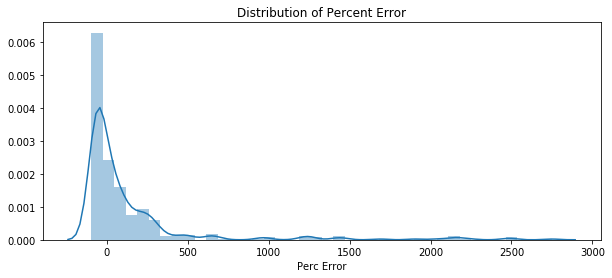

In [92]:
#looking at the distrubtion of our error

plt.figure(figsize=(10,4))
sns.distplot(resultsConcat["Perc Error"], bins = 40)
plt.title("Distribution of Percent Error")


In [93]:
resultsConcat["Perc Error"].quantile(.80)

207.0

* 80% of the training data has an error of less than 184% 
* Considering the volatility of bonus prices this is not a huge surprise

### Scatter Plot Showing Predicted vs Actual Bonus Prices - Lease by Lease

Text(0.5, 1.0, 'Actual Bonus (Green) vs Predicted Bonus (Red)')

Text(0.5, 0, 'Lease Index')

Text(0, 0.5, '$/acre')

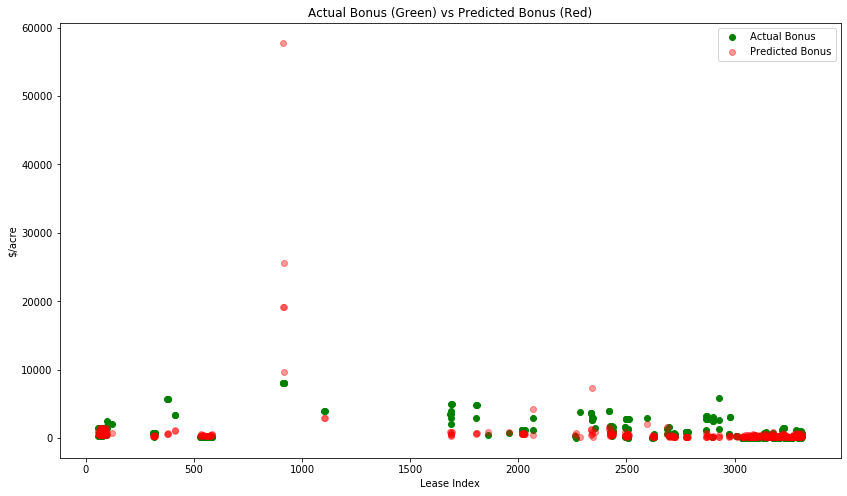

In [94]:
#scatter plot to overlay lease by lease, actual bonus vs predicted bonus
fig, ax1 = plt.subplots(1, figsize = (14,8))
ax1.scatter(resultsConcat.index, resultsConcat.iloc[:,2], c = 'g', label = "Actual Bonus")
ax1.scatter(resultsConcat.index, resultsConcat["Predicted"], c = 'r', alpha = .4, label = "Predicted Bonus")
ax1.set_title("Actual Bonus (Green) vs Predicted Bonus (Red)")
ax1.set_xlabel("Lease Index")
ax1.set_ylabel("$/acre")
ax1.legend()

#### * **We see that the model generally underestimates values** 

In [95]:
resultsConcat.describe().T

count           mean            std     min       25%  \
Bonus               371.0     990.654987    1417.418897     7.0     147.5   
Section             371.0      18.760108      10.633660     1.0       9.0   
Township            371.0      38.226415       1.071726    37.0      37.0   
Range               371.0      72.110512       1.008704    70.0      71.5   
Total Permits       371.0       6.150943      13.323780     0.0       0.0   
Total Wells         371.0      17.773585      15.641506     1.0       3.0   
Avg First 6 Mo Oil  371.0   10011.646900   11160.853019     0.0    3090.0   
Avg First 6 Mo Gas  371.0   15269.902965   25446.200952     0.0    1754.0   
Qi Oil              371.0    2619.509434    3084.854426     0.0     795.0   
Qi Gas              371.0    4281.234501    7689.151727     0.0     314.0   
6 Mo Oil Revenue $  371.0  773372.474394  827949.145549     0.0  261448.0   
6 Mo Gas Rev $      371.0   66075.455526  103604.192801     0.0    8456.5   
Oil Price           371.0      85.024259      28.303891    39.0      60.0   
Gas Price           371.0       5.835580       3.274377     2.0       3.0   
Record Year         371.0    2011.964960       4.236439  2008.0    2008.0   
Log Bonus           371.0       5.948787       1.524597     2.0       5.0   
Bonus               371.0     990.654987    1417.418897     7.0     147.5   
Predicted           371.0     823.719677    3583.324900   107.0     193.5   
Perc Error          371.0     138.983827     428.366854   -96.0     -56.5   

                         50%        75%        max  
Bonus                  350.0     1201.0     8004.0  
Section                 19.0       28.0       36.0  
Township                38.0       39.0       40.0  
Range                   72.0       73.0       74.0  
Total Permits            1.0        7.0      124.0  
Total Wells             13.0       29.0       55.0  
Avg First 6 Mo Oil    7282.0    12277.0    82446.0  
Avg First 6 Mo Gas    3628.0    20281.0   197850.0  
Qi Oil                1790.0     3104.0    26010.0  
Qi Gas                 816.0     4620.0    40644.0  
6 Mo Oil Revenue $  560349.0  1007467.5  7959337.0  
6 Mo Gas Rev $       26945.0    81225.0   935512.0  
Oil Price               95.0      113.0      134.0  
Gas Price                4.0       10.0       13.0  
Record Year           2011.0     2016.0     2019.0  
Log Bonus                6.0        7.0        9.0  
Bonus                  350.0     1201.0     8004.0  
Predicted              340.0      586.5    57728.0  
Perc Error              -1.0      142.5     2750.0

* model is predicting one huge error of 2802% and 45k/acre - throwing off avg percent error

In [96]:
resultsConcat.head(3)

Record Date Record Number  Bonus  Section  Township  Range  \
LeaseIndex                                                              
57          2019-12-11     WYW189586   1527        3        39     73   
59          2019-12-11     WYW189590    302       27        39     73   
60          2019-12-11     WYW189596   1535       32        40     73   

                                               geometry  \
LeaseIndex                                                
57          POINT (450547.6131938574 4803344.147960225)   
59            POINT (450464.34694615 4796947.371161564)   
60          POINT (447329.5662888384 4804957.255790628)   

                                                      buffers  Total Permits  \
LeaseIndex                                                                     
57          POLYGON ((455375.6331938574 4803344.147960225,...              9   
59          POLYGON ((455292.36694615 4796947.371161564, 4...             10   
60          POLYGON ((452157.5862888384 4804957.255790628,...              6   

            Total Wells  Avg First 6 Mo Oil  Avg First 6 Mo Gas  Qi Oil  \
LeaseIndex                                                                
57                   49             15299.0             46031.0  3211.0   
59                   38             17782.0             49282.0  3801.0   
60                   43              8981.0             33128.0  2092.0   

             Qi Gas  6 Mo Oil Revenue $  6 Mo Gas Rev $  Oil Price  Gas Price  \
LeaseIndex                                                                      
57           9632.0            916129.0        102189.0       60.0        2.0   
59          10975.0           1064804.0        109405.0       60.0        2.0   
60           6826.0            537766.0         73545.0       60.0        2.0   

            TWSHP  Record Year  Log Bonus   Bonus  Predicted  Perc Error  
LeaseIndex                                                                
57          39 73         2019        7.0  1527.0      978.0       -36.0  
59          39 73         2019        6.0   302.0      803.0       166.0  
60          40 73         2019        7.0  1535.0      656.0       -57.0

In [97]:
#looking at what the training parameters were for the abnormal prediciton of 40k/acre
resultsConcat.loc[resultsConcat["Predicted"]>30000]


Record Date Record Number  Bonus  Section  Township  Range  \
LeaseIndex                                                              
913         2018-09-18     WYW187435   8004       17        39     72   

                                              geometry  \
LeaseIndex                                               
913         POINT (456987.9394583493 4800362.80558945)   

                                                      buffers  Total Permits  \
LeaseIndex                                                                     
913         POLYGON ((461815.9594583493 4800362.80558945, ...            124   

            Total Wells  Avg First 6 Mo Oil  Avg First 6 Mo Gas   Qi Oil  \
LeaseIndex                                                                 
913                  19             65751.0            197850.0  14591.0   

             Qi Gas  6 Mo Oil Revenue $  6 Mo Gas Rev $  Oil Price  Gas Price  \
LeaseIndex                                                                      
913         40644.0           4617697.0        593549.0       70.0        3.0   

            TWSHP  Record Year  Log Bonus   Bonus  Predicted  Perc Error  
LeaseIndex                                                                
913         39 72         2018        9.0  8004.0    57728.0       621.0

* good news is that this abnormal prediciton occured on highest bonus in training data - leads to indication we need to tune the model with potential isotonic regression

In [98]:
DFtrainProdFilter.loc[913]

APIUWI                         OpAlias        LeaseName  \
LeaseIndex                                                                    
913         49009283320000       ANADARKO E&P ONSHORE, LLC            DILTS   
913         49009207640000               ANDERSON OIL, LTD            BALTA   
913         49009219000000  ANADARKO PETROLEUM CORPORATION  FEDERAL W-62630   
913         49009285010000        DEVON ENERGY CORPORATION     ROBBINS UNIT   
913         49009288590000        DEVON ENERGY CORPORATION     ROBBINS UNIT   
913         49009384290000      EOG RESOURCES INCORPORATED       MARYS DRAW   
913         49009338840000      EOG RESOURCES INCORPORATED         CATAPULT   
913         49009384300000      EOG RESOURCES INCORPORATED       MARYS DRAW   
913         49009356010000        DEVON ENERGY CORPORATION     RU DILTS FED   
913         49009356560000        DEVON ENERGY CORPORATION     RU STATE FED   
913         49009358730000        DEVON ENERGY CORPORATION     RU STATE FED   
913         49009352130000        DEVON ENERGY CORPORATION     RU DILTS FED   
913         49009303850000      EOG RESOURCES INCORPORATED       MARYS DRAW   
913         49009285020000        DEVON ENERGY CORPORATION     ROBBINS UNIT   
913         49009356000000        DEVON ENERGY CORPORATION     RU DILTS FED   
913         49009340560000      EOG RESOURCES INCORPORATED         CATAPULT   
913         49009340580000      EOG RESOURCES INCORPORATED         CATAPULT   
913         49009338830000      EOG RESOURCES INCORPORATED         CATAPULT   
913         49009384310000      EOG RESOURCES INCORPORATED       MARYS DRAW   

                    WellNo         County        Reservoir ProdType  \
LeaseIndex                                                            
913                   7-1H  CONVERSE (WY)         NIOBRARA      OIL   
913                  1-4 0  CONVERSE (WY)          PARKMAN      OIL   
913                    6-1  CONVERSE (WY)          PARKMAN      OIL   
913           39-72 22-1PH  CONVERSE (WY)          PARKMAN      OIL   
913           39-72 16-1PH  CONVERSE (WY)          PARKMAN      OIL   
913               60-3328H  CONVERSE (WY)           TURNER      OIL   
913              116-0136H  CONVERSE (WY)           TURNER      OIL   
913               61-3328H  CONVERSE (WY)           TURNER      OIL   
913         22-273972-3XTH  CONVERSE (WY)           TURNER      OIL   
913         16-093972-2XTH  CONVERSE (WY)           TURNER      OIL   
913         16-093972-4XTH  CONVERSE (WY)           TURNER      OIL   
913         04-093972-4XTH  CONVERSE (WY)           TURNER      OIL   
913             479-3208XH  CONVERSE (WY)         NIOBRARA      OIL   
913            39-72 4-1FH  CONVERSE (WY)         FRONTIER      OIL   
913         22-273972-1XTH  CONVERSE (WY)           TURNER      OIL   
913              297-1324H  CONVERSE (WY)  FRONTIER-TURNER      OIL   
913              697-1324H  CONVERSE (WY)  FRONTIER-TURNER      OIL   
913              117-0136H  CONVERSE (WY)           TURNER      OIL   
913              496-3328H  CONVERSE (WY)          PARKMAN      OIL   

           ProdStatus DrillType      LeaseNo FstPrdDate LstPrdDate    CumGas  \
LeaseIndex                                                                     
913            ACTIVE         H    WYW176200 2012-04-01 2020-02-01  155987.0   
913             P & A         V    WYW014370 1975-08-01 1975-09-01       NaN   
913             P & A         V    WYW062630 1981-08-01 1986-04-01       NaN   
913            ACTIVE         H    WYW153113 2014-12-01 2020-02-01  100072.0   
913           SHUT IN         H  ST 08-00210 2013-05-01 2016-05-01    5969.0   
913            ACTIVE         H    WYW152110 2018-09-01 2020-01-01  857677.0   
913            ACTIVE         H  ST 12-00083 2017-05-01 2020-01-01  735032.0   
913            ACTIVE         H    WYW152110 2018-09-01 2020-01-01  869461.0   
913            ACTIVE         H    WYW175054 2018-07-01 2020-02-01  

### Honing in on Percent Error on Bonus Price

<Figure size 1080x504 with 0 Axes>

Text(0.5, 1.0, '% Error vs. Bonus')

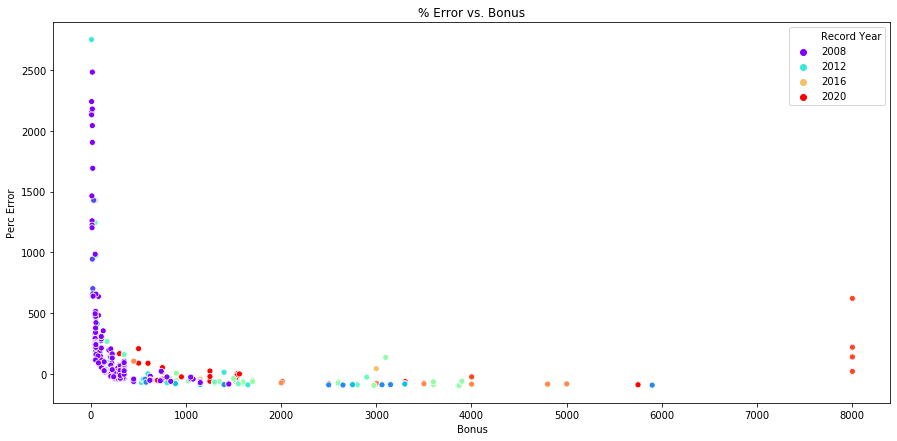

In [99]:
plt.figure(figsize=(15,7))
#bonus column is duplicated - thus - using .iloc[:,2]
sns.scatterplot(resultsConcat.iloc[:,2], resultsConcat["Perc Error"], hue = resultsConcat["Record Year"], palette = "rainbow")
plt.title("% Error vs. Bonus")

* Large errors occur at bonuses less than $500
* Need to determine how characteristics of learning features appear to look like at small bonus prices
* Also, bonuses of leases in 2008 appear to be causing the most errors - maybe we can remove 2008 lease prices for training the model

In [100]:
resultsConcat['Perc Error'].quantile(.90)
resultsConcat["Bonus"].quantile(.01)

341.0

Bonus    10.1
Bonus    10.1
Name: 0.01, dtype: float64

Text(0.5, 1.0, 'Zooming on Lease Bonus with Error \n% Error vs. Bonus\n Predicted (black) vs. Actual (rainbow)')

(0, 500)

(0, 4000)

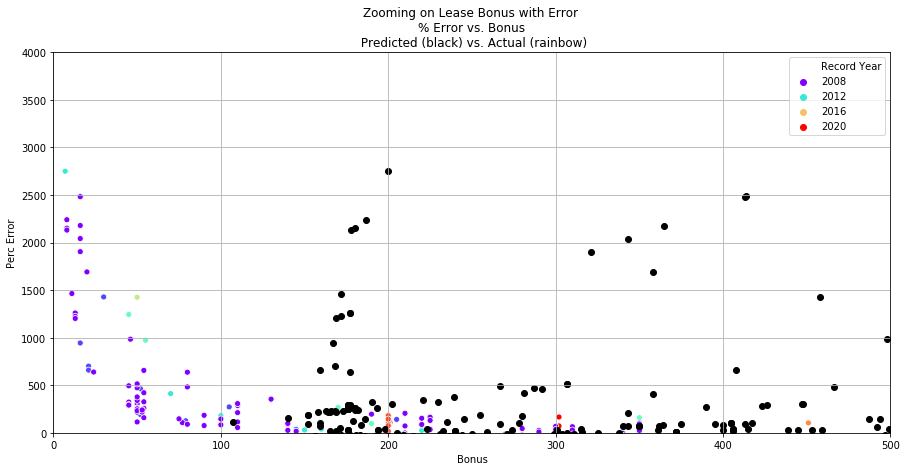

In [101]:
#Zooming in on smaller bonuses where large errors occured
fig, ax = plt.subplots(1,1, figsize=(15,7))
#bonus column is duplicated - thus - using .iloc[:,2]
sns.scatterplot(resultsConcat.iloc[:,2], resultsConcat["Perc Error"], hue = resultsConcat["Record Year"], palette = "rainbow", ax = ax)
ax.set_title("Zooming on Lease Bonus with Error \n% Error vs. Bonus\n Predicted (black) vs. Actual (rainbow)")
ax.set_xlim([0,500])
ax.set_ylim([0,4000])

ax.scatter(resultsConcat["Predicted"], resultsConcat["Perc Error"], c = "k")
plt.grid(True)

* Large errors occur under $50/acre  - multiple linear regression over entire data range may not work - may have to split up data or perform isotonic regression

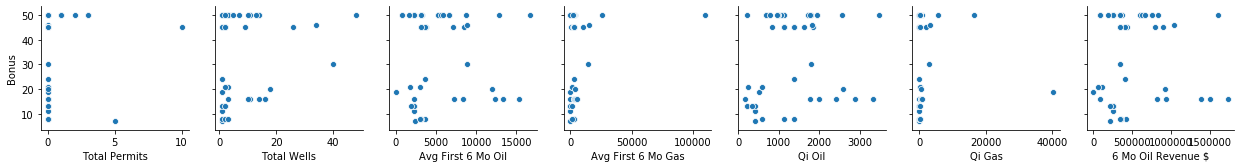

In [102]:

a = sns.pairplot(cleanedLeases[cleanedLeases["Bonus"]<51], y_vars="Bonus", x_vars = learningCols[0:7])


* we see that there is a lot high variance on bonus price when there is 0 to minimal magnitude on the learning features

* we may need to do isotonic regressions at different intervals of each learning feature to better fit low bonus priced tracts

In [103]:
cleanedLeases[cleanedLeases["Bonus"]<51][MLPredandResponseCols].describe().T

count           mean            std      min  \
Bonus                53.0      35.490566      16.842737     7.00   
Total Permits        53.0       0.490566       1.624602     0.00   
Total Wells          53.0       7.490566      10.039581     1.00   
Avg First 6 Mo Oil   53.0    4967.529563    3882.806804    43.00   
Avg First 6 Mo Gas   53.0    5113.841056   15252.805282     0.00   
Qi Oil               53.0    1258.824997     793.725356   160.00   
Qi Gas               53.0    1555.572997    5938.667088     0.00   
6 Mo Oil Revenue $   53.0  502350.609956  394242.739464  4047.59   
6 Mo Gas Rev $       53.0   43221.518428  129495.036059     0.00   
Oil Price            53.0     102.687170      23.219402    39.09   
Gas Price            53.0       8.856604       2.373885     2.84   

                              25%            50%            75%           max  
Bonus                   16.000000      45.000000      50.000000  5.000000e+01  
Total Permits            0.000000       0.000000       0.000000  1.000000e+01  
Total Wells              2.000000       3.000000      11.000000  4.800000e+01  
Avg First 6 Mo Oil    2322.333333    3089.500000    6670.000000  1.675564e+04  
Avg First 6 Mo Gas     952.666667    2228.666667    3112.500000  1.095447e+05  
Qi Oil                 690.000000    1125.000000    1770.000000  3.478125e+03  
Qi Gas                  75.000000     304.285714     372.000000  4.041000e+04  
6 Mo Oil Revenue $  258708.840000  347815.910000  663452.703333  1.727292e+06  
6 Mo Gas Rev $        6459.080000   21378.848333   31685.250000  9.355120e+05  
Oil Price              112.580000     112.580000     112.580000  1.166700e+02  
Gas Price                8.260000      10.180000      10.180000  1.018000e+01

## Decision Tree Model

In [104]:
#importing libraries for creating decision tree model
import math                                               # basic calculations like square root
from sklearn import tree                                  # tree program from scikit learn (package for machine learning)
from sklearn.tree import _tree                            # for accessing tree information
from sklearn import metrics                               # measures to check our models
from sklearn.model_selection import cross_val_score       # cross validation methods
from sklearn.tree import export_graphviz  

### Sample Decision Tree - No Scaled or Transformed Data
* Helps to interpret decision tree flow chart

In [105]:
#establishing initial simple model
treeModel = tree.DecisionTreeRegressor(criterion='mae', min_samples_leaf=4, max_depth = 4)
treeModel = treeModel.fit(scaler.inverse_transform(x_train), np.exp(y_train))

### Visualizing Decision Tree with Packages

/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


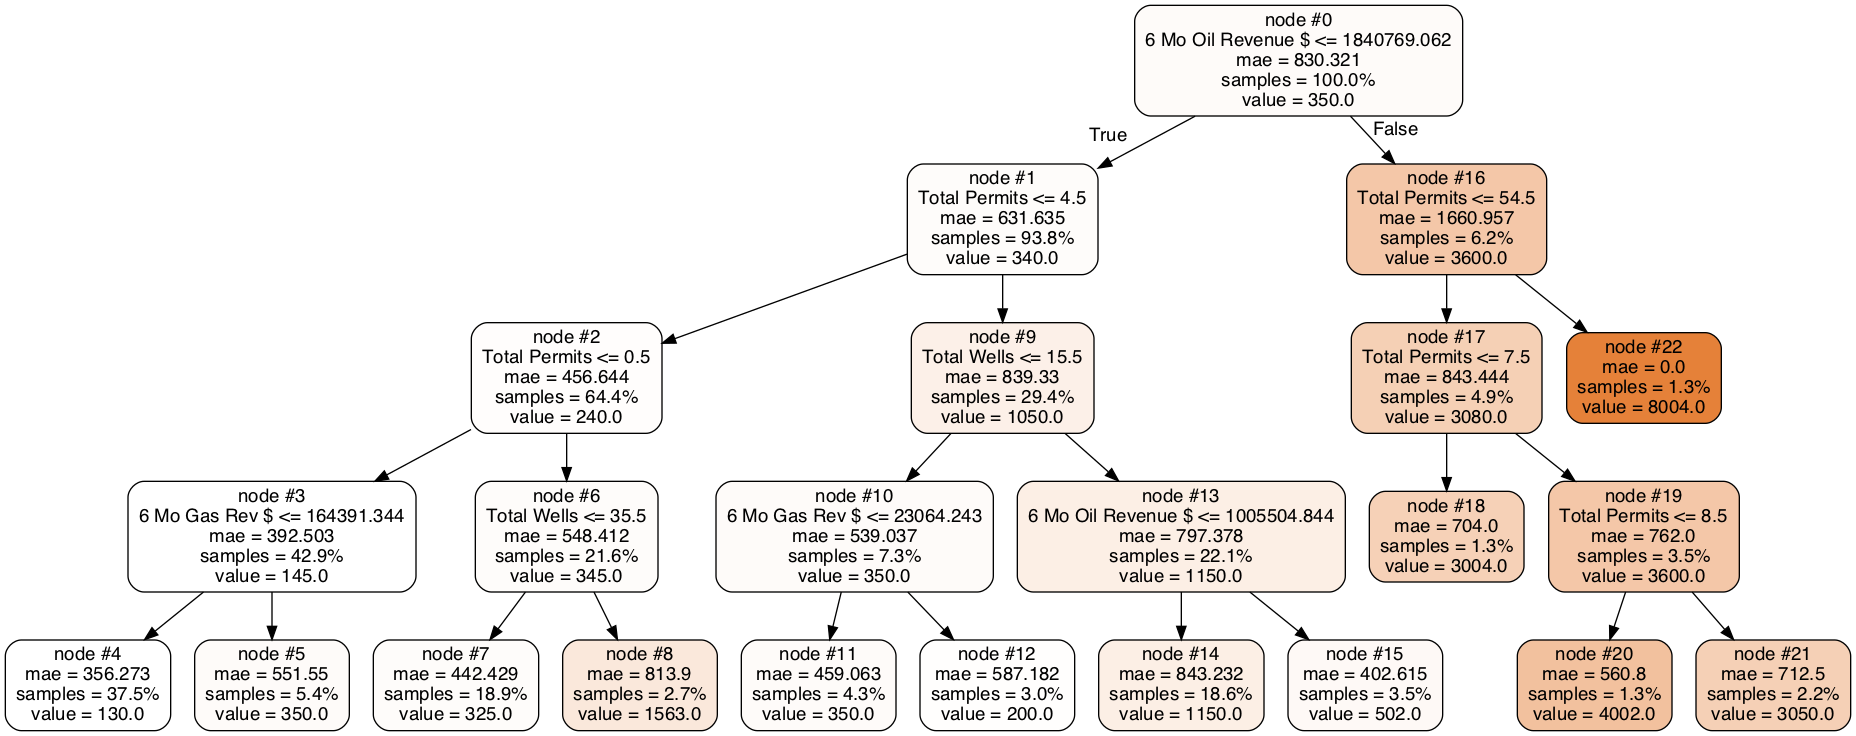

In [106]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(treeModel, out_file=dot_data, feature_names=inputs.columns,  
                filled=True, rounded=True,leaves_parallel = False, impurity = True,
                special_characters=False, node_ids = True, proportion = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [107]:
sampletreePredictions = treeModel.predict(scaler.inverse_transform(x_train))

In [108]:
metrics.mean_absolute_error(np.exp(y_train), sampletreePredictions)

509.1832884097035

### Iterating Tree Model with Different Parameters - Data is Scaled and Transformed (Inputs are standardized, Response is log transformed)

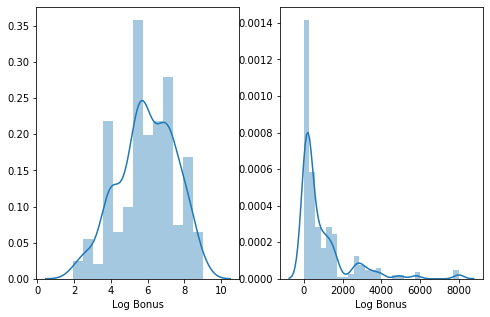

In [109]:
fig, ax = plt.subplots(1,2, figsize = (8,5))
sns.distplot(y_train, ax = ax[0])
sns.distplot(np.exp(y_train), ax = ax[1])

In [110]:
#creating empty arrays to store model data, error, information
error = []
varexp = []
treeModels = []
minSampleList = []
levels = []
minSamples = []

#looping through different sample minimums per leaf along with different levels
#running criterion on model as L1 loss function to reduce the sensitivity to outliars and large variance of response feature
for sample in range(2,16,2):
    for level in range(2,15):
        iterTreeMod = tree.DecisionTreeRegressor(criterion='mae', max_depth=level, min_samples_leaf=sample)
        iterTreeMod.fit(x_train, y_train)
        treeModels.append(iterTreeMod)
        minSamples.append(sample)
        levels.append(level)

for model in treeModels:
    error.append(metrics.mean_absolute_error(np.exp(y_train), np.exp(model.predict(x_train))))
    varexp.append(metrics.explained_variance_score(np.exp(y_train), np.exp(model.predict(x_train))))

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=9,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=11,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=12,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=13,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=14,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=9,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=11,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=12,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=13,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=14,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=9,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=11,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=12,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=13,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=14,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=9,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=11,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=12,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=13,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=14,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=9,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=11,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=12,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=13,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=14,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=9,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=11,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=12,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=13,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=14,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=9,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=11,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=12,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=13,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=14,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

<Figure size 864x504 with 0 Axes>

Text(0.5, 1.0, 'Absolute Mean Error vs Tree Branches - Colored by Min Sample Size in Each Leaf')

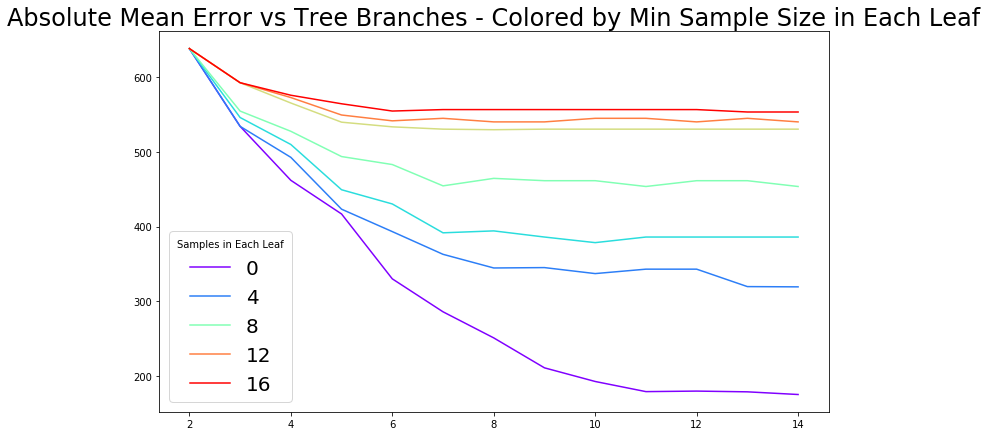

In [111]:
plt.figure(figsize=(12,7))
sns.lineplot(x=levels, y = error, hue = minSamples, palette="rainbow")
plt.title("Absolute Mean Error vs Tree Branches - Colored by Min Sample Size in Each Leaf", size = 24)
plt.legend(title = "Samples in Each Leaf", prop={'size': 20})

<Figure size 864x504 with 0 Axes>

Text(0.5, 1.0, 'Variance Explained vs Tree Branches - Colored by Min Sample Size in Each Leaf')

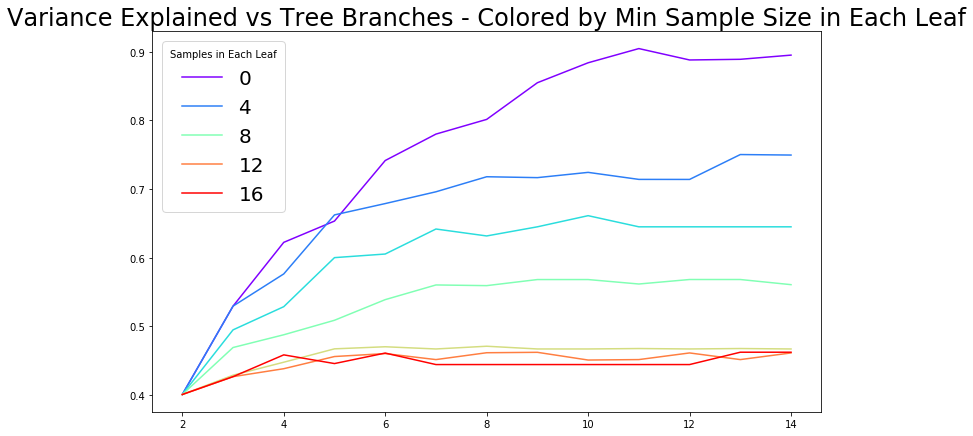

In [112]:
plt.figure(figsize=(12,7))
sns.lineplot(x=levels, y = varexp, hue = minSamples, palette="rainbow")
plt.title("Variance Explained vs Tree Branches - Colored by Min Sample Size in Each Leaf", size = 24)
plt.legend(title = "Samples in Each Leaf", prop={'size': 20})

* We see the most optimal model, one that does not overfit, while still producing an error under 400, appears to be model with 4 samples as minimum, and 6-8 levels

In [113]:
finalTreeModel = tree.DecisionTreeRegressor(criterion='mae', max_depth=8, min_samples_leaf=4)
finalTreeModel=finalTreeModel.fit(x_train,y_train)
treePredictions = np.exp(finalTreeModel.predict(x_train))


In [114]:
modelPerformance(np.exp(y_train), treePredictions)

Mean Absolute Error: 351.44743935309975 
Variance Explained: 0.7062158987272302 
R2 Score: 0.693732282624669


In [115]:
treeResults = pd.DataFrame()
treeResults["Actual Bonus"] = np.exp(y_train)
treeResults["Tree Predicted Bonus"] = treePredictions
treeResults

Actual Bonus  Tree Predicted Bonus
LeaseIndex                                    
2505                55.0            350.000000
2502              2750.0            570.000000
2704               350.0            350.000000
3072                50.0             52.000000
2356              1500.0           2085.665361
2507              2800.0           2927.114620
1858               451.0           1220.698161
3079               300.0            570.000000
3255                13.0             45.000000
3258                50.0             50.000000
2899              2500.0            270.000000
412               3304.0           1220.698161
3237               140.0             50.000000
94                1562.0           1061.508361
554                200.0            200.000000
3142                 8.0            250.000000
69                1526.0           2001.000000
3096               300.0            300.000000
3286               350.0            350.000000
2026              1150.0           1150.000000
3065                16.0             33.674916
1688              4002.0           3950.670829
3260                50.0             50.000000
2028              1150.0           1150.000000
3300               225.0            350.000000
1807              4800.0           4382.875768
2784               890.0            890.000000
915               8004.0           8004.000000
3292              1050.0            601.000000
3089                90.0             52.000000
...                  ...                   ...
2626               530.0            890.000000
2624               110.0            350.000000
3295                53.0             50.000000
2718               800.0            600.000000
90                1536.0           1535.000000
542                200.0            150.000000
2283              3870.0            450.000000
3224               350.0            350.000000
3204                50.0            450.000000
380               5751.0           1700.000000
3270               340.0            350.000000
2977              3060.0           2927.114620
3217              1150.0            450.000000
73                 302.0            350.000000
3232               110.0            110.000000
3296               630.0            620.000000
97                2502.0           1535.000000
3064                21.0             52.000000
572                200.0            209.761770
65                1252.0            350.000000
3309                53.0             50.000000
3288               350.0            350.000000
2869              2750.0            200.000000
2497              2750.0            250.000000
2336              3600.0           3600.000000
3230               110.0            110.000000
3172               450.0            450.000000
72                 302.0            302.000000
2338              3600.0           3600.000000
3078               300.0            300.000000

[371 rows x 2 columns]

In [116]:
resultsConcat = pd.concat([resultsConcat, treeResults["Tree Predicted Bonus"]], axis=1, join="inner")

In [117]:
resultsConcat["Diff Linear vs Tree"] = resultsConcat["Predicted"] - resultsConcat["Tree Predicted Bonus"]

In [118]:

resultsConcat.describe().T

count           mean            std          min  \
Bonus                 371.0     990.654987    1417.418897     7.000000   
Section               371.0      18.760108      10.633660     1.000000   
Township              371.0      38.226415       1.071726    37.000000   
Range                 371.0      72.110512       1.008704    70.000000   
Total Permits         371.0       6.150943      13.323780     0.000000   
Total Wells           371.0      17.773585      15.641506     1.000000   
Avg First 6 Mo Oil    371.0   10011.646900   11160.853019     0.000000   
Avg First 6 Mo Gas    371.0   15269.902965   25446.200952     0.000000   
Qi Oil                371.0    2619.509434    3084.854426     0.000000   
Qi Gas                371.0    4281.234501    7689.151727     0.000000   
6 Mo Oil Revenue $    371.0  773372.474394  827949.145549     0.000000   
6 Mo Gas Rev $        371.0   66075.455526  103604.192801     0.000000   
Oil Price             371.0      85.024259      28.303891    39.000000   
Gas Price             371.0       5.835580       3.274377     2.000000   
Record Year           371.0    2011.964960       4.236439  2008.000000   
Log Bonus             371.0       5.948787       1.524597     2.000000   
Bonus                 371.0     990.654987    1417.418897     7.000000   
Predicted             371.0     823.719677    3583.324900   107.000000   
Perc Error            371.0     138.983827     428.366854   -96.000000   
Tree Predicted Bonus  371.0     832.500204    1232.914638    16.000000   
Diff Linear vs Tree   371.0      -8.780528    2971.016824 -3660.875768   

                           25%       50%        75%        max  
Bonus                    147.5     350.0     1201.0     8004.0  
Section                    9.0      19.0       28.0       36.0  
Township                  37.0      38.0       39.0       40.0  
Range                     71.5      72.0       73.0       74.0  
Total Permits              0.0       1.0        7.0      124.0  
Total Wells                3.0      13.0       29.0       55.0  
Avg First 6 Mo Oil      3090.0    7282.0    12277.0    82446.0  
Avg First 6 Mo Gas      1754.0    3628.0    20281.0   197850.0  
Qi Oil                   795.0    1790.0     3104.0    26010.0  
Qi Gas                   314.0     816.0     4620.0    40644.0  
6 Mo Oil Revenue $    261448.0  560349.0  1007467.5  7959337.0  
6 Mo Gas Rev $          8456.5   26945.0    81225.0   935512.0  
Oil Price                 60.0      95.0      113.0      134.0  
Gas Price                  3.0       4.0       10.0       13.0  
Record Year             2008.0    2011.0     2016.0     2019.0  
Log Bonus                  5.0       6.0        7.0        9.0  
Bonus                    147.5     350.0     1201.0     8004.0  
Predicted                193.5     340.0      586.5    57728.0  
Perc Error               -56.5      -1.0      142.5     2750.0  
Tree Predicted Bonus     200.0     350.0     1150.0     8004.0  
Diff Linear vs Tree     -428.0       7.0      141.0    49724.0

## Testing Tree and Linear Model on Y Test

In [119]:
linearTest = np.exp(reg.predict(x_test))
print("Linear Model")
modelPerformance(np.exp(y_test), linearTest)


treeTest = np.exp(finalTreeModel.predict(x_test))
print("\nDecision Tree")
modelPerformance(np.exp(y_test), treeTest)

Linear Model
Mean Absolute Error: 880.9124659663399 
Variance Explained: -1.9842780934169775 
R2 Score: -2.00268352390639

Decision Tree
Mean Absolute Error: 541.4933157825843 
Variance Explained: 0.6379381594259557 
R2 Score: 0.6339003098515796



## Applying Model to Sales Tracts

### Data Preparation

In [120]:
%store -r saleDate
%store -r tractshp

In [121]:
#adding record date to tractshp in order for it to work with getTrainingMeasures functions
tractshp["Record Date"] = saleDate

#filtering leaes within AOI where model data was built on
leasesInAOI = tractshp.loc[tractshp["geometry"].within(AOI["geometry"].iloc[0])]

### Looping through all tracts within selected AOI to gather permit and production data

In [122]:
%store -r prodshp
%store -r permitshp

In [123]:
for i in leasesInAOI.index:
    getTrainingMeasures(leasesInAOI, i, prodshp, permitshp)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 16789  4900948392     None       NaT 2020-01-28 2022-01-27    WY   
 19790  4900948280     None       NaT 2020-01-28 2022-01-27    WY   
 21385  4900943869     None       NaT 2019-01-17 2021-01-16    WY   
 22427  4900942810     None       NaT 2018-12-27 2020-12-26    WY   
 22435  4900941533     None       NaT 2018-12-27 2020-12-26    WY   
 22524  4900943868     None       NaT 2019-01-17 2021-01-16    WY   
 22959  4900948278     None       NaT 2020-01-28 2022-01-27    WY   
 25458  4900942825     None       NaT 2018-12-27 2020-12-26    WY   
 27787  4900948279     None       NaT 2020-01-28 2022-01-27    WY   
 40327  4900941632     None       NaT 2018-12-27 2020-12-26    WY   
 40330  4900942079     None       NaT 2018-12-27 2020-12-26    WY   
 46037  4900942077     None       NaT 2018-12-27 2020-12-26    WY   
 
               County OpAlias        LeaseName          WellNo Formation  \
 16789  CONVERSE (WY)   D

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 16789  4900948392     None       NaT 2020-01-28 2022-01-27    WY   
 19790  4900948280     None       NaT 2020-01-28 2022-01-27    WY   
 21385  4900943869     None       NaT 2019-01-17 2021-01-16    WY   
 22435  4900941533     None       NaT 2018-12-27 2020-12-26    WY   
 22524  4900943868     None       NaT 2019-01-17 2021-01-16    WY   
 22959  4900948278     None       NaT 2020-01-28 2022-01-27    WY   
 27787  4900948279     None       NaT 2020-01-28 2022-01-27    WY   
 40327  4900941632     None       NaT 2018-12-27 2020-12-26    WY   
 40330  4900942079     None       NaT 2018-12-27 2020-12-26    WY   
 46037  4900942077     None       NaT 2018-12-27 2020-12-26    WY   
 
               County OpAlias        LeaseName          WellNo Formation  \
 16789  CONVERSE (WY)   DEVON  SDU TILLARD FED  02-113771-7XNH  NIOBRARA   
 19790  CONVERSE (WY)   DEVON  SDU TILLARD FED  12-013771-5XNH  NIOBRARA   
 21385  CON

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 9059   4900940541     None       NaT 2018-06-15 2020-06-14    WY   
 21385  4900943869     None       NaT 2019-01-17 2021-01-16    WY   
 22427  4900942810     None       NaT 2018-12-27 2020-12-26    WY   
 22431  4900942811     None       NaT 2018-12-27 2020-12-26    WY   
 22435  4900941533     None       NaT 2018-12-27 2020-12-26    WY   
 22524  4900943868     None       NaT 2019-01-17 2021-01-16    WY   
 25458  4900942825     None       NaT 2018-12-27 2020-12-26    WY   
 29920  4900942809     None       NaT 2018-12-27 2020-12-26    WY   
 40325  4900942812     None       NaT 2018-12-27 2020-12-26    WY   
 40327  4900941632     None       NaT 2018-12-27 2020-12-26    WY   
 40330  4900942079     None       NaT 2018-12-27 2020-12-26    WY   
 45097  4900946701     None       NaT 2019-06-06 2021-06-05    WY   
 46037  4900942077     None       NaT 2018-12-27 2020-12-26    WY   
 
               County OpAlias   

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 3585   4900937066     None       NaT 2019-09-18 2021-09-17    WY   
 8838   4900946613     None       NaT 2019-09-18 2021-09-17    WY   
 8839   4900946614     None       NaT 2019-09-18 2021-09-17    WY   
 15615  4900937057     None       NaT 2019-09-18 2021-09-17    WY   
 16450  4900937053     None       NaT 2019-09-18 2021-09-17    WY   
 16452  4900946611     None       NaT 2019-09-18 2021-09-17    WY   
 19217  4900938466     None       NaT 2019-02-07 2021-02-06    WY   
 25694  4900938469     None       NaT 2019-02-07 2021-02-06    WY   
 36837  4900938468     None       NaT 2019-02-07 2021-02-06    WY   
 36842  4900938467     None       NaT 2019-02-07 2021-02-06    WY   
 41511  4900938408     None       NaT 2018-12-26 2020-12-25    WY   
 
               County OpAlias   LeaseName           WellNo Formation  \
 3585   CONVERSE (WY)   DEVON         WYO      163971-4TUH    TURNER   
 8838   CONVERSE (WY)   DE

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 3585   4900937066     None       NaT 2019-09-18 2021-09-17    WY   
 8838   4900946613     None       NaT 2019-09-18 2021-09-17    WY   
 8839   4900946614     None       NaT 2019-09-18 2021-09-17    WY   
 15615  4900937057     None       NaT 2019-09-18 2021-09-17    WY   
 16450  4900937053     None       NaT 2019-09-18 2021-09-17    WY   
 16452  4900946611     None       NaT 2019-09-18 2021-09-17    WY   
 19217  4900938466     None       NaT 2019-02-07 2021-02-06    WY   
 19662  4900938452     None       NaT 2020-01-09 2022-01-08    WY   
 21261  4900941634     None       NaT 2018-12-21 2020-12-20    WY   
 22752  4900938451     None       NaT 2019-05-29 2021-05-28    WY   
 25694  4900938469     None       NaT 2019-02-07 2021-02-06    WY   
 26175  4900941635     None       NaT 2018-12-21 2020-12-20    WY   
 26238  4900938423     None       NaT 2019-02-19 2021-02-18    WY   
 26239  4900938424     None       

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 3585   4900937066     None       NaT 2019-09-18 2021-09-17    WY   
 8838   4900946613     None       NaT 2019-09-18 2021-09-17    WY   
 8839   4900946614     None       NaT 2019-09-18 2021-09-17    WY   
 15615  4900937057     None       NaT 2019-09-18 2021-09-17    WY   
 16450  4900937053     None       NaT 2019-09-18 2021-09-17    WY   
 16452  4900946611     None       NaT 2019-09-18 2021-09-17    WY   
 19217  4900938466     None       NaT 2019-02-07 2021-02-06    WY   
 25694  4900938469     None       NaT 2019-02-07 2021-02-06    WY   
 36837  4900938468     None       NaT 2019-02-07 2021-02-06    WY   
 36842  4900938467     None       NaT 2019-02-07 2021-02-06    WY   
 41511  4900938408     None       NaT 2018-12-26 2020-12-25    WY   
 
               County OpAlias   LeaseName           WellNo Formation  \
 3585   CONVERSE (WY)   DEVON         WYO      163971-4TUH    TURNER   
 8838   CONVERSE (WY)   DE

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 2849   4900937397     None       NaT 2019-09-16 2021-09-15    WY   
 3426   4900937409     None       NaT 2019-08-21 2021-08-20    WY   
 3585   4900937066     None       NaT 2019-09-18 2021-09-17    WY   
 5995   4900937408     None       NaT 2019-08-21 2021-08-20    WY   
 8833   4900937396     None       NaT 2019-09-16 2021-09-15    WY   
 8838   4900946613     None       NaT 2019-09-18 2021-09-17    WY   
 8839   4900946614     None       NaT 2019-09-18 2021-09-17    WY   
 9498   4900937834     None       NaT 2019-08-23 2021-08-22    WY   
 9499   4900937838     None       NaT 2019-08-23 2021-08-22    WY   
 9501   4900937835     None       NaT 2019-08-23 2021-08-22    WY   
 9502   4900937837     None       NaT 2019-08-23 2021-08-22    WY   
 13472  4900937399     None       NaT 2019-09-16 2021-09-15    WY   
 14450  4900937405     None       NaT 2019-08-21 2021-08-20    WY   
 15461  4900937836     None       

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 2849   4900937397     None       NaT 2019-09-16 2021-09-15    WY   
 3585   4900937066     None       NaT 2019-09-18 2021-09-17    WY   
 5995   4900937408     None       NaT 2019-08-21 2021-08-20    WY   
 8833   4900937396     None       NaT 2019-09-16 2021-09-15    WY   
 8838   4900946613     None       NaT 2019-09-18 2021-09-17    WY   
 8839   4900946614     None       NaT 2019-09-18 2021-09-17    WY   
 9498   4900937834     None       NaT 2019-08-23 2021-08-22    WY   
 9499   4900937838     None       NaT 2019-08-23 2021-08-22    WY   
 9501   4900937835     None       NaT 2019-08-23 2021-08-22    WY   
 15462  4900937840     None       NaT 2019-08-23 2021-08-22    WY   
 15615  4900937057     None       NaT 2019-09-18 2021-09-17    WY   
 16450  4900937053     None       NaT 2019-09-18 2021-09-17    WY   
 16452  4900946611     None       NaT 2019-09-18 2021-09-17    WY   
 
               County OpAlias Le

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 3585   4900937066     None       NaT 2019-09-18 2021-09-17    WY   
 8569   4900945450     None       NaT 2019-04-29 2021-04-28    WY   
 8838   4900946613     None       NaT 2019-09-18 2021-09-17    WY   
 8839   4900946614     None       NaT 2019-09-18 2021-09-17    WY   
 10648  4900941626     None       NaT 2019-04-29 2021-04-28    WY   
 15615  4900937057     None       NaT 2019-09-18 2021-09-17    WY   
 16450  4900937053     None       NaT 2019-09-18 2021-09-17    WY   
 16452  4900946611     None       NaT 2019-09-18 2021-09-17    WY   
 19217  4900938466     None       NaT 2019-02-07 2021-02-06    WY   
 19662  4900938452     None       NaT 2020-01-09 2022-01-08    WY   
 20622  4900945449     None       NaT 2019-04-29 2021-04-28    WY   
 22752  4900938451     None       NaT 2019-05-29 2021-05-28    WY   
 25694  4900938469     None       NaT 2019-02-07 2021-02-06    WY   
 26238  4900938423     None       

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 3585   4900937066     None       NaT 2019-09-18 2021-09-17    WY   
 4386   4900938414     None       NaT 2018-05-17 2020-05-16    WY   
 8569   4900945450     None       NaT 2019-04-29 2021-04-28    WY   
 8838   4900946613     None       NaT 2019-09-18 2021-09-17    WY   
 8839   4900946614     None       NaT 2019-09-18 2021-09-17    WY   
 10648  4900941626     None       NaT 2019-04-29 2021-04-28    WY   
 11071  4900940385     None       NaT 2018-05-18 2020-05-17    WY   
 15615  4900937057     None       NaT 2019-09-18 2021-09-17    WY   
 16450  4900937053     None       NaT 2019-09-18 2021-09-17    WY   
 16452  4900946611     None       NaT 2019-09-18 2021-09-17    WY   
 19035  4900940342     None       NaT 2018-05-18 2020-05-17    WY   
 19217  4900938466     None       NaT 2019-02-07 2021-02-06    WY   
 19662  4900938452     None       NaT 2020-01-09 2022-01-08    WY   
 20622  4900945449     None       

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 3585   4900937066     None       NaT 2019-09-18 2021-09-17    WY   
 8569   4900945450     None       NaT 2019-04-29 2021-04-28    WY   
 8838   4900946613     None       NaT 2019-09-18 2021-09-17    WY   
 8839   4900946614     None       NaT 2019-09-18 2021-09-17    WY   
 10648  4900941626     None       NaT 2019-04-29 2021-04-28    WY   
 15615  4900937057     None       NaT 2019-09-18 2021-09-17    WY   
 16450  4900937053     None       NaT 2019-09-18 2021-09-17    WY   
 16452  4900946611     None       NaT 2019-09-18 2021-09-17    WY   
 19217  4900938466     None       NaT 2019-02-07 2021-02-06    WY   
 19662  4900938452     None       NaT 2020-01-09 2022-01-08    WY   
 20622  4900945449     None       NaT 2019-04-29 2021-04-28    WY   
 22752  4900938451     None       NaT 2019-05-29 2021-05-28    WY   
 25694  4900938469     None       NaT 2019-02-07 2021-02-06    WY   
 26238  4900938423     None       

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 3585   4900937066     None       NaT 2019-09-18 2021-09-17    WY   
 8569   4900945450     None       NaT 2019-04-29 2021-04-28    WY   
 8838   4900946613     None       NaT 2019-09-18 2021-09-17    WY   
 8839   4900946614     None       NaT 2019-09-18 2021-09-17    WY   
 10648  4900941626     None       NaT 2019-04-29 2021-04-28    WY   
 15615  4900937057     None       NaT 2019-09-18 2021-09-17    WY   
 16450  4900937053     None       NaT 2019-09-18 2021-09-17    WY   
 16452  4900946611     None       NaT 2019-09-18 2021-09-17    WY   
 19217  4900938466     None       NaT 2019-02-07 2021-02-06    WY   
 20622  4900945449     None       NaT 2019-04-29 2021-04-28    WY   
 25694  4900938469     None       NaT 2019-02-07 2021-02-06    WY   
 36837  4900938468     None       NaT 2019-02-07 2021-02-06    WY   
 36842  4900938467     None       NaT 2019-02-07 2021-02-06    WY   
 41511  4900938408     None       

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 3585   4900937066     None       NaT 2019-09-18 2021-09-17    WY   
 8838   4900946613     None       NaT 2019-09-18 2021-09-17    WY   
 8839   4900946614     None       NaT 2019-09-18 2021-09-17    WY   
 15615  4900937057     None       NaT 2019-09-18 2021-09-17    WY   
 16450  4900937053     None       NaT 2019-09-18 2021-09-17    WY   
 16452  4900946611     None       NaT 2019-09-18 2021-09-17    WY   
 19217  4900938466     None       NaT 2019-02-07 2021-02-06    WY   
 25694  4900938469     None       NaT 2019-02-07 2021-02-06    WY   
 36837  4900938468     None       NaT 2019-02-07 2021-02-06    WY   
 36842  4900938467     None       NaT 2019-02-07 2021-02-06    WY   
 
               County OpAlias   LeaseName           WellNo Formation  \
 3585   CONVERSE (WY)   DEVON         WYO      163971-4TUH    TURNER   
 8838   CONVERSE (WY)   DEVON     JRJ FED      153971-4TLH    TURNER   
 8839   CONVERSE (WY)  

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 4960   4900940043     None       NaT 2020-02-26 2022-02-25    WY   
 9945   4900940042     None       NaT 2020-02-26 2022-02-25    WY   
 14867  4900941928     None       NaT 2020-02-19 2022-02-18    WY   
 15830  4900941395     None       NaT 2020-02-18 2022-02-17    WY   
 15908  4900941359     None       NaT 2020-02-27 2022-02-26    WY   
 15909  4900941358     None       NaT 2020-02-27 2022-02-26    WY   
 15914  4900941702     None       NaT 2020-02-27 2022-02-26    WY   
 15915  4900941700     None       NaT 2020-02-27 2022-02-26    WY   
 16673  4900941387     None       NaT 2020-01-07 2022-01-06    WY   
 16675  4900941379     None       NaT 2020-01-07 2022-01-06    WY   
 16927  4900941906     None       NaT 2020-02-19 2022-02-18    WY   
 16928  4900941910     None       NaT 2020-02-19 2022-02-18    WY   
 18619  4900941388     None       NaT 2020-01-07 2022-01-06    WY   
 18621  4900941380     None       

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 4960   4900940043     None       NaT 2020-02-26 2022-02-25    WY   
 9945   4900940042     None       NaT 2020-02-26 2022-02-25    WY   
 14867  4900941928     None       NaT 2020-02-19 2022-02-18    WY   
 15914  4900941702     None       NaT 2020-02-27 2022-02-26    WY   
 15915  4900941700     None       NaT 2020-02-27 2022-02-26    WY   
 16673  4900941387     None       NaT 2020-01-07 2022-01-06    WY   
 16675  4900941379     None       NaT 2020-01-07 2022-01-06    WY   
 18619  4900941388     None       NaT 2020-01-07 2022-01-06    WY   
 18621  4900941380     None       NaT 2020-01-07 2022-01-06    WY   
 18998  4900941386     None       NaT 2020-03-17 2022-03-17    WY   
 27909  4900941701     None       NaT 2020-02-18 2022-02-17    WY   
 27928  4900941927     None       NaT 2020-02-19 2022-02-18    WY   
 27959  4900943141     None       NaT 2020-02-27 2022-02-26    WY   
 30998  4900941384     None       

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 4960   4900940043     None       NaT 2020-02-26 2022-02-25    WY   
 9945   4900940042     None       NaT 2020-02-26 2022-02-25    WY   
 14867  4900941928     None       NaT 2020-02-19 2022-02-18    WY   
 15914  4900941702     None       NaT 2020-02-27 2022-02-26    WY   
 15915  4900941700     None       NaT 2020-02-27 2022-02-26    WY   
 16673  4900941387     None       NaT 2020-01-07 2022-01-06    WY   
 16675  4900941379     None       NaT 2020-01-07 2022-01-06    WY   
 18619  4900941388     None       NaT 2020-01-07 2022-01-06    WY   
 18621  4900941380     None       NaT 2020-01-07 2022-01-06    WY   
 18998  4900941386     None       NaT 2020-03-17 2022-03-17    WY   
 27909  4900941701     None       NaT 2020-02-18 2022-02-17    WY   
 27928  4900941927     None       NaT 2020-02-19 2022-02-18    WY   
 27959  4900943141     None       NaT 2020-02-27 2022-02-26    WY   
 30998  4900941384     None       

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 4960   4900940043     None       NaT 2020-02-26 2022-02-25    WY   
 9945   4900940042     None       NaT 2020-02-26 2022-02-25    WY   
 15914  4900941702     None       NaT 2020-02-27 2022-02-26    WY   
 15915  4900941700     None       NaT 2020-02-27 2022-02-26    WY   
 27909  4900941701     None       NaT 2020-02-18 2022-02-17    WY   
 27959  4900943141     None       NaT 2020-02-27 2022-02-26    WY   
 43631  4900936266     None       NaT 2019-06-18 2021-06-17    WY   
 43638  4900936264     None       NaT 2019-06-18 2021-06-17    WY   
 43654  4900936265     None       NaT 2019-06-18 2021-06-17    WY   
 
               County                   OpAlias         LeaseName  \
 4960   CONVERSE (WY)         EOG RESOURCES INC         AMBERJACK   
 9945   CONVERSE (WY)         EOG RESOURCES INC         AMBERJACK   
 15914  CONVERSE (WY)    ELEPHANT OPERATING LLC            NIMITZ   
 15915  CONVERSE (WY)    ELEPHAN

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 7855   4900941111     None       NaT 2019-07-31 2021-07-30    WY   
 43631  4900936266     None       NaT 2019-06-18 2021-06-17    WY   
 43638  4900936264     None       NaT 2019-06-18 2021-06-17    WY   
 43654  4900936265     None       NaT 2019-06-18 2021-06-17    WY   
 
               County                   OpAlias   LeaseName           WellNo  \
 7855   CONVERSE (WY)      WOLD ENERGY PARTNERS   PATTERSON  3874-22-15-3BFH   
 43631  CONVERSE (WY)  WOLD ENERGY PARTNERS LLC  HORNBUCKLE  3873-20-17-2F3H   
 43638  CONVERSE (WY)  WOLD ENERGY PARTNERS LLC  HORNBUCKLE   3873-20-17-2FH   
 43654  CONVERSE (WY)      WOLD ENERGY PARTNERS  HORNBUCKLE  3873-20-17-2F2H   
 
       Formation  PermDepth      TVD PermitType WellType DrillType WellStatus  \
 7855   FRONTIER    22895.0  13382.0   NewDrill      OIL         H  PERMITTED   
 43631  FRONTIER    21846.0  12059.0   NewDrill      OIL         H  PERMITTED   
 43638  

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 9945   4900940042     None       NaT 2020-02-26 2022-02-25    WY   
 15914  4900941702     None       NaT 2020-02-27 2022-02-26    WY   
 27909  4900941701     None       NaT 2020-02-18 2022-02-17    WY   
 27959  4900943141     None       NaT 2020-02-27 2022-02-26    WY   
 43631  4900936266     None       NaT 2019-06-18 2021-06-17    WY   
 43638  4900936264     None       NaT 2019-06-18 2021-06-17    WY   
 43654  4900936265     None       NaT 2019-06-18 2021-06-17    WY   
 
               County                   OpAlias         LeaseName  \
 9945   CONVERSE (WY)         EOG RESOURCES INC         AMBERJACK   
 15914  CONVERSE (WY)    ELEPHANT OPERATING LLC            NIMITZ   
 27909  CONVERSE (WY)    ELEPHANT OPERATING LLC            NIMITZ   
 27959  CONVERSE (WY)    ELEPHANT OPERATING LLC  NIMITZ 3873-1522   
 43631  CONVERSE (WY)  WOLD ENERGY PARTNERS LLC        HORNBUCKLE   
 43638  CONVERSE (WY)  WOLD ENER

In [124]:
#detecting null columns that may have occured when getting training measures that did not have wells to generate revenue, Qi oil, etc
nullCols = leasesInAOI.columns[leasesInAOI.isnull().any()]

In [125]:
#filling null values with a loop, as df.fillna does not work on a geo dataframe - therefore have to iterate through columns
nullCols
for col in nullCols:
    leasesInAOI[col].fillna(0,inplace=True)

Index(['Avg First 6 Mo Oil', 'Avg First 6 Mo Gas', 'Qi Oil', 'Qi Gas',
       '6 Mo Oil Revenue $', '6 Mo Gas Rev $'],
      dtype='object')

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [126]:
#exporting training measures on sale tracts to file
leasesInAOI.to_excel("Output Data/Sale Tracts Learning Measures.xlsx")

### Read In Prepared Data
### Preparing model by gathering inputs, scaling, and predicting based on training model

In [127]:
#reading in leasesinAOI from file for model
leasesInAOI = pd.read_excel("Output Data/Sale Tracts Learning Measures.xlsx", index_col = 0)
leasesInAOI.head()

SaleParcel  lot_no  tract_id       short_code            label  \
16  WY-201Q-014   64921        40  BLMWY-2020-Q1-3  WY-2020-03-6317   
17  WY-201Q-100   65007        41  BLMWY-2020-Q1-3  WY-2020-03-6318   
18  WY-201Q-101   65008        42  BLMWY-2020-Q1-3  WY-2020-03-6319   
19  WY-201Q-015   64922        45  BLMWY-2020-Q1-3  WY-2020-03-6324   
20  WY-201Q-102   65009        44  BLMWY-2020-Q1-3  WY-2020-03-6322   

                                             geometry  \
16  POLYGON ((470775.3766748243 4783849.638091538,...   
17  POLYGON ((470776.0512321209 4785061.1477955, 4...   
18  MULTIPOLYGON (((467495.5528191004 4784235.8869...   
19  MULTIPOLYGON (((466663.7560363491 4802008.3005...   
20  POLYGON ((467881.7929990217 4802005.905810955,...   

                                      centroids  Acres  \
16   POINT (469958.273277905 4783844.910772996)    325   
17  POINT (469953.1518195324 4784853.058404164)    166   
18   POINT (467757.130082407 4784036.616042774)    494   
19  POINT (468832.8359083962 4802293.450434712)   1539   
20   POINT (467608.471182364 4801534.516088142)    243   

                                              buffers  \
16  POLYGON ((474786.293277905 4783844.910772996, ...   
17  POLYGON ((474781.1718195324 4784853.058404164,...   
18  POLYGON ((472585.150082407 4784036.616042774, ...   
19  POLYGON ((473660.8559083962 4802293.450434712,...   
20  POLYGON ((472436.491182364 4801534.516088142, ...   

                                       Permit Summary  \
16  In a 3 mile radius there are 12 active permits...   
17  In a 3 mile radius there are 10 active permits...   
18  In a 3 mile radius there are 13 active permits...   
19  In a 3 mile radius there are 11 active permits...   
20  In a 3 mile radius there are 20 active permits...   

                                       Leases Summary  \
16  In a 3 mile radius, the latest leases with bon...   
17  In a 3 mile radius, the latest leases with bon...   
18  In a 3 mile radius, the latest leases with bon...   
19  In a 3 mile radius, the latest leases with bon...   
20  In a 3 mile radius, the latest leases with bon...   

                               Old Production Summary  \
16  No old wells within tract or in 3 mile radius ...   
17  No old wells within tract or in 3 mile radius ...   
18  No old wells within tract or in 3 mile radius ...   
19  No old wells within tract or in 3 mile radius ...   
20  No old wells within tract or in 3 mile radius ...   

                                  Recent Prod Summary Record Date  \
16  There are 6 wells within 3 mile radius that ha...  2020-03-23   
17  There are 5 wells within 3 mile radius that ha...  2020-03-23   
18  There are 10 wells within 3 mile radius that h...  2020-03-23   
19  There are 15 wells within 3 mile radius that h...  2020-03-23   
20  There are 22 wells within 3 mile radius that h...  2020-03-23   

    Total Permits  Total Wells  Avg First 6 Mo Oil  Avg First 6 Mo Gas  \
16             12            6       107657.200000        85665.000000   
17             10            5       107657.200000        85665.000000   
18             13           10       122775.000000        85716.833333   
19             11           15        84078.600000       136917.200000   
20             20           22       103078.416667       211061.500000   

          Qi Oil        Qi Gas  6 Mo Oil Revenue $  6 Mo Gas Rev $  Oil Price  \
16  26755.000000  20090.000000        2.691430e+06   153340.350000         25   
17  27732.000000  18996.000000        2.691430e+06   153340.350000         25   
18  27903.000000  18525.000000        3.069375e+06   153433.131667         25   
19  19838.000000  32556.000000        2.101965e+06   245081.788000         25   
20  23465.454545  38686.363636        2.576960e+06   377800.085000         25   

    Gas Price  
16       1.79  
17       1.79  
18       1.79  
19       1.79  
20       1.79

### Scaling Inputs and Predicting Bonuses Based on Models

In [128]:
#getting inputs based on the model defined before
inputsTractProjection = leasesInAOI[inputs.columns]

#scaling independent variables and tranforming
scaler.fit(inputsTractProjection)
inputsTractProjection = scaler.transform(inputsTractProjection)

#predicting bonuses
projBonus = reg.predict(inputsTractProjection)

#creating column for projected Bonuses
leasesInAOI["Projected Bonus"] = np.exp(projBonus)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [129]:
leasesInAOI["Tree Predicted Bonus"] = np.exp(finalTreeModel.predict(inputsTractProjection))

In [130]:
#rounding numeric values for cleaner presentation
leasesInAOI = leasesInAOI.round()

In [131]:
#Since we had model error - we will use it to get an estimated range  - since this model tended to underestimate - we will use the projected value x only 75% to get low end and 200% to get highend

In [132]:
def getBidIntervals(lowEndRate, highEndRate, BaseBonus):
    
    '''
    This function will create an interval based on adjustments to the projected BaseBonus prices
    BaseBonus price will be a pandas series
    lowEndRate and highEndRate will be user defined based on the error of the model
    Basebonus will be a pandas series and the function should be called on the dataframe apply method
    '''
    
    lowProjection = BaseBonus * lowEndRate
    highProjection = BaseBonus * highEndRate
    average = (lowProjection + highProjection) /2
    
    return [lowProjection, highProjection]
    

In [133]:
leasesInAOI["Expected Bonus Range"] = leasesInAOI["Projected Bonus"].apply(lambda x: getBidIntervals(.75, 2, x))

In [134]:
leasesInAOI

SaleParcel  lot_no  tract_id       short_code            label  \
16  WY-201Q-014   64921        40  BLMWY-2020-Q1-3  WY-2020-03-6317   
17  WY-201Q-100   65007        41  BLMWY-2020-Q1-3  WY-2020-03-6318   
18  WY-201Q-101   65008        42  BLMWY-2020-Q1-3  WY-2020-03-6319   
19  WY-201Q-015   64922        45  BLMWY-2020-Q1-3  WY-2020-03-6324   
20  WY-201Q-102   65009        44  BLMWY-2020-Q1-3  WY-2020-03-6322   
21  WY-201Q-016   64923        49  BLMWY-2020-Q1-3  WY-2020-03-6340   
22  WY-201Q-017   64924        46  BLMWY-2020-Q1-3  WY-2020-03-6331   
23  WY-201Q-103   65010        60  BLMWY-2020-Q1-3  WY-2020-03-6401   
24  WY-201Q-018   64925        47  BLMWY-2020-Q1-3  WY-2020-03-6333   
25  WY-201Q-019   64926        51  BLMWY-2020-Q1-3  WY-2020-03-6345   
26  WY-201Q-020   64927        48  BLMWY-2020-Q1-3  WY-2020-03-6335   
27  WY-201Q-021   64928        43  BLMWY-2020-Q1-3  WY-2020-03-6321   
28  WY-201Q-022   64929        50  BLMWY-2020-Q1-3  WY-2020-03-6342   
32  WY-201Q-026   64933        57  BLMWY-2020-Q1-3  WY-2020-03-6398   
33  WY-201Q-027   64934        59  BLMWY-2020-Q1-3  WY-2020-03-6400   
34  WY-201Q-028   64935        61  BLMWY-2020-Q1-3  WY-2020-03-6402   
35  WY-201Q-029   64936        56  BLMWY-2020-Q1-3  WY-2020-03-6397   
36  WY-201Q-030   64937        53  BLMWY-2020-Q1-3  WY-2020-03-6374   
37  WY-201Q-031   64938        58  BLMWY-2020-Q1-3  WY-2020-03-6399   

                                             geometry  \
16  POLYGON ((470775.3766748243 4783849.638091538,...   
17  POLYGON ((470776.0512321209 4785061.1477955, 4...   
18  MULTIPOLYGON (((467495.5528191004 4784235.8869...   
19  MULTIPOLYGON (((466663.7560363491 4802008.3005...   
20  POLYGON ((467881.7929990217 4802005.905810955,...   
21  POLYGON ((468685.6574361854 4801198.093584971,...   
22  POLYGON ((472330.6638150535 4800025.069974388,...   
23  POLYGON ((471122.0037354486 4801241.216803673,...   
24  MULTIPOLYGON (((467066.8207937301 4801197.1337...   
25  POLYGON ((465830.3683772773 4798767.101425705,...   
26  POLYGON ((467055.8841481433 4799577.560766404,...   
27  POLYGON ((469083.3774875944 4799178.917583397,...   
28  POLYGON ((470701.7128884639 4799215.388265088,...   
32  POLYGON ((449604.4699246621 4793699.210653428,...   
33  MULTIPOLYGON (((447998.4914872372 4793741.4216...   
34  POLYGON ((447600.3182270684 4794139.568428458,...   
35  POLYGON ((447185.9603839262 4792547.069950781,...   
36  POLYGON ((444792.8150660271 4790153.151919761,...   
37  MULTIPOLYGON (((445169.4727996021 4790151.2744...   

                                      centroids  Acres  \
16   POINT (469958.273277905 4783844.910772996)    325   
17  POINT (469953.1518195324 4784853.058404164)    166   
18   POINT (467757.130082407 4784036.616042774)    494   
19  POINT (468832.8359083962 4802293.450434712)   1539   
20   POINT (467608.471182364 4801534.516088142)    243   
21  POINT (468890.6774940442 4801400.067115995)     40   
22  POINT (471858.2048892394 4800294.277369834)    243   
23  POINT (471114.8075752032 4800429.924610612)    325   
24  POINT (467602.4846453754 4799779.674300328)    243   
25  POINT (465426.4270627511 4798968.314839863)    243   
26  POINT (466746.2136945967 4798869.261029639)    489   
27   POINT (468271.8925895233 4799175.72778338)    324   
28    POINT (469892.76265296 4799196.952564376)    324   
32   POINT (449805.1564049294 4793898.46923826)     39   
33  POINT (448805.3325036266 4793919.754942623)     79   
34  POINT (447694.6175132183 4793446.594994583)    157   
35  POINT (446851.1472105166 4792477.806125961)    119   
36  POINT (444980.5661090591 4789952.455238507)     37   
37  POINT (445771.1327411023 4790347.606312461)     79   

                                              buffers  \
16  POLYGON ((474786.293277905 4783844.910772996, ...   
17  POLYGON ((474781.1718195324 4784853.058404164,...   
18  POLYGON ((472585.150082407 4784036.616042774, ...   
19  POLYGON ((473660.8559083962 4802293.450434712,... 

## Sales Results - Compare Projected Prices vs What was Sold

### Reading sales results excel file

In [135]:
salesResults = pd.read_excel('Data/Sales_Results.xlsx', header = 4)
#removing unamed null columns
salesResults = salesResults.drop(columns = salesResults.columns[[1,-1]])
#renaming column for merging
salesResults.rename(columns = {'PAR': 'Label Code'}, inplace = True)

In [136]:
#generating label code from sales results to make a primary key to join published sale results with presale codes
leasesInAOI["Label Code"] = leasesInAOI["label"].apply(lambda x: int(x.split('-')[3]))

In [137]:
#checking datatypes to ensure matching column for joining contain same datatype
salesResults.dtypes
leasesInAOI.dtypes

SERIAL         object
Label Code     object
NAME           object
ADDRESS        object
CITY           object
ST             object
ZIP            object
Bid/Acre       object
ACRES          object
Total Bonus    object
dtype: object

SaleParcel                        object
lot_no                             int64
tract_id                           int64
short_code                        object
label                             object
geometry                          object
centroids                         object
Acres                              int64
buffers                           object
Permit Summary                    object
Leases Summary                    object
Old Production Summary            object
Recent Prod Summary               object
Record Date               datetime64[ns]
Total Permits                      int64
Total Wells                        int64
Avg First 6 Mo Oil               float64
Avg First 6 Mo Gas               float64
Qi Oil                           float64
Qi Gas                           float64
6 Mo Oil Revenue $               float64
6 Mo Gas Rev $                   float64
Oil Price                          int64
Gas Price                        float64
Projected Bonus 

In [138]:
#converting to string in order for joining to work when inner joining the sales results
leasesInAOI["Label Code"] = leasesInAOI["Label Code"].apply(lambda x: str(x))
salesResults["Label Code"] = salesResults["Label Code"].astype(str)

In [139]:
#checking datatypes to ensure matching column for joining contain same datatype
salesResults.dtypes
leasesInAOI.dtypes

SERIAL         object
Label Code     object
NAME           object
ADDRESS        object
CITY           object
ST             object
ZIP            object
Bid/Acre       object
ACRES          object
Total Bonus    object
dtype: object

SaleParcel                        object
lot_no                             int64
tract_id                           int64
short_code                        object
label                             object
geometry                          object
centroids                         object
Acres                              int64
buffers                           object
Permit Summary                    object
Leases Summary                    object
Old Production Summary            object
Recent Prod Summary               object
Record Date               datetime64[ns]
Total Permits                      int64
Total Wells                        int64
Avg First 6 Mo Oil               float64
Avg First 6 Mo Gas               float64
Qi Oil                           float64
Qi Gas                           float64
6 Mo Oil Revenue $               float64
6 Mo Gas Rev $                   float64
Oil Price                          int64
Gas Price                        float64
Projected Bonus 

In [140]:
FullResultsandTracts = pd.merge(leasesInAOI, salesResults)

In [141]:
FullResultsandTracts.head()

SaleParcel  lot_no  tract_id       short_code            label  \
0  WY-201Q-014   64921        40  BLMWY-2020-Q1-3  WY-2020-03-6317   
1  WY-201Q-100   65007        41  BLMWY-2020-Q1-3  WY-2020-03-6318   
2  WY-201Q-101   65008        42  BLMWY-2020-Q1-3  WY-2020-03-6319   
3  WY-201Q-015   64922        45  BLMWY-2020-Q1-3  WY-2020-03-6324   
4  WY-201Q-102   65009        44  BLMWY-2020-Q1-3  WY-2020-03-6322   

                                            geometry  \
0  POLYGON ((470775.3766748243 4783849.638091538,...   
1  POLYGON ((470776.0512321209 4785061.1477955, 4...   
2  MULTIPOLYGON (((467495.5528191004 4784235.8869...   
3  MULTIPOLYGON (((466663.7560363491 4802008.3005...   
4  POLYGON ((467881.7929990217 4802005.905810955,...   

                                     centroids  Acres  \
0   POINT (469958.273277905 4783844.910772996)    325   
1  POINT (469953.1518195324 4784853.058404164)    166   
2   POINT (467757.130082407 4784036.616042774)    494   
3  POINT (468832.8359083962 4802293.450434712)   1539   
4   POINT (467608.471182364 4801534.516088142)    243   

                                             buffers  \
0  POLYGON ((474786.293277905 4783844.910772996, ...   
1  POLYGON ((474781.1718195324 4784853.058404164,...   
2  POLYGON ((472585.150082407 4784036.616042774, ...   
3  POLYGON ((473660.8559083962 4802293.450434712,...   
4  POLYGON ((472436.491182364 4801534.516088142, ...   

                                      Permit Summary  \
0  In a 3 mile radius there are 12 active permits...   
1  In a 3 mile radius there are 10 active permits...   
2  In a 3 mile radius there are 13 active permits...   
3  In a 3 mile radius there are 11 active permits...   
4  In a 3 mile radius there are 20 active permits...   

                                      Leases Summary  \
0  In a 3 mile radius, the latest leases with bon...   
1  In a 3 mile radius, the latest leases with bon...   
2  In a 3 mile radius, the latest leases with bon...   
3  In a 3 mile radius, the latest leases with bon...   
4  In a 3 mile radius, the latest leases with bon...   

                              Old Production Summary  \
0  No old wells within tract or in 3 mile radius ...   
1  No old wells within tract or in 3 mile radius ...   
2  No old wells within tract or in 3 mile radius ...   
3  No old wells within tract or in 3 mile radius ...   
4  No old wells within tract or in 3 mile radius ...   

                                 Recent Prod Summary Record Date  \
0  There are 6 wells within 3 mile radius that ha...  2020-03-23   
1  There are 5 wells within 3 mile radius that ha...  2020-03-23   
2  There are 10 wells within 3 mile radius that h...  2020-03-23   
3  There are 15 wells within 3 mile radius that h...  2020-03-23   
4  There are 22 wells within 3 mile radius that h...  2020-03-23   

   Total Permits  Total Wells  Avg First 6 Mo Oil  Avg First 6 Mo Gas  \
0             12            6            107657.0             85665.0   
1             10            5            107657.0             85665.0   
2             13           10            122775.0             85717.0   
3             11           15             84079.0            136917.0   
4             20           22            103078.0            211062.0   

    Qi Oil   Qi Gas  6 Mo Oil Revenue $  6 Mo Gas Rev $  Oil Price  Gas Price  \
0  26755.0  20090.0           2691430.0        153340.0         25        2.0   
1  27732.0  18996.0           2691430.0        153340.0         25        2.0   
2  27903.0  18525.0           3069375.0        153433.0         25        2.0   
3  19838.0  32556.0           2101965.0        245082.0         25        2.0   
4  23465.0  38686.0           2576960.0        377800.0         25        2.0   

   Projected Bonus  Tree Predicted Bonus Expected Bonus Range Label Code  \
0            347.0                 250.0      [260.25, 694.0]       6317   
1            287.0                 250.0      [215.25, 574.0]       

In [142]:
ProjectedvsActual = FullResultsandTracts.loc[FullResultsandTracts["NAME"] == "R&R ROYALTY LTD"][["Projected Bonus", "Bid/Acre", "Expected Bonus Range", "Tree Predicted Bonus"]]

### Results - Projected Bonus vs Actual Bonus (Bid/Acre)

In [143]:
ProjectedvsActual

Projected Bonus Bid/Acre Expected Bonus Range  Tree Predicted Bonus
0             347.0      516      [260.25, 694.0]                 250.0
3             427.0      389      [320.25, 854.0]                 270.0
6             396.0      203       [297.0, 792.0]                1221.0
7             221.0      526      [165.75, 442.0]                 450.0
8             958.0      525      [718.5, 1916.0]                1700.0
10            428.0      525       [321.0, 856.0]                 350.0
11            205.0      357      [153.75, 410.0]                1300.0
12            654.0      681      [490.5, 1308.0]                1221.0
13            246.0      554       [184.5, 492.0]                1221.0
14            168.0      511       [126.0, 336.0]                 600.0
15            168.0       14       [126.0, 336.0]                 600.0
18            231.0      982      [173.25, 462.0]                2927.0